## 빅데이터 기반 AI 응용 솔루션 개발자 전문 과정

#### 교과목명 : 모델 성능 평가
- 평가일 : 08.27
- 성명 :
- 점수 :

Q1. iris data를 불러와서 붓꽃의 종류를 분류하는 모델링을 수행한 후 오차행렬과 정확도를 평가하세요.
- test_size = 0.2, 분류기는 DecisionTreeClassifier를 이용
- 정확도는 소수점 4째 자리까지 표현

In [1]:
from sklearn.datasets import load_iris
import pandas as pd
iris = load_iris()
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

Q2. Q1을 classification_report()로 평가 및 출력하세요.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2 , random_state = 156)

dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train,y_train)

dt_clf_pred = dt_clf.predict(X_test)

print(round(accuracy_score(y_test,dt_clf_pred),4))

1.0


Q3. train.csv 파일을 불러와서 분류모델링 평가를 아래와 같이 수행하세요.
- 하기 사항들을 처리하여 분석용 데이터셋 구축하였다. 수정이 필요한 부분을 찾아서 조치
 - 불필요한 컬럼 삭제 : ['PassengerId','Ticket','Cabin'] 
 - Null 처리 : ['Embarked','Age'] * 최빈도시, Name컬럼의 호칭 활용
 - 레이블 인코딩 : ['Sex','Embarked']
 - Age 범주화 : 6개 범주
 - 파생변수 Family : 가족수별 범주화
 - one-hot encoding : Embarked, Family_size, Age_cat
 - Fair_cat 컬럼 생성 : Fair 범주화
 
- dt, lr, rf, knn, svm 5개 분류 모델링 및 생존자 예측 정확도 평가
- dt, lr, rf, knn 모델별로 accuracy에 추가하여 confusion matrix, accuracy, precision, recall,roc auc score 평가하고 svm은 classification으로 평가하세요.

In [7]:
import pandas as pd
tdf = pd.read_csv('dataset/train.csv')

In [8]:
# 사용자 함수
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder


# 불필요한 칼럼 삭제
def drop_features(df):
    df.drop(['PassengerId','Ticket','Cabin'], axis=1, inplace=True)
    return df

# Null 처리
def fillna(df):   
    most_town = df['Embarked'].value_counts(dropna=True).idxmax()
    df['Embarked'].fillna(most_town, inplace=True)
    return df

#  레이블 인코딩
def format_features(df):
    
    features=['Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        df[feature] = le.fit_transform(df[feature])
    return df

# 앞에서 설정한 Data Processing 함수 호출
def transform_features(df):
    drop_features(df)
    fillna(df)
    format_features(df)
    
    return df

tdf = transform_features(tdf)
tdf.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,7.2500,2
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,71.2833,0
2,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,7.9250,2
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,53.1000,2
4,0,3,"Allen, Mr. William Henry",1,35.0,0,0,8.0500,2


In [10]:
# Null 처리 방법
# Embarked - 빈도가 가장 많은 도시로 대체
# Age - 'Name' 컬럼에 있는 호칭을 이용하여 Title 컬럼을 만들고 아래와 같은 공통 그룹 평균으로 대체

tdf['Title']= tdf.Name.str.extract('([A-Za-z]+)\.')

tdf['Title'].replace(['Mr','Miss','Mrs','Master','Rev', 'Dr','Col','Major','Ms','Mlle','Countess',
'Sir','Jonkheer','Dona','Capt','Lady','Don','Mme'], ['Mr','Miss','Mrs','Master','Mr','Other','Mr','Mr',
'Mrs','Miss','Mrs','Mr','Mr','Other','Mr','Mrs','Mr','Mms'], inplace=True)

tdf.groupby('Title').Age.describe()

tdf.loc[(tdf.Age.isnull()) & (tdf.Title == 'Mr'), 'Age'] = tdf[tdf.Title == 'Mr'].Age.mean()
tdf.loc[(tdf.Age.isnull()) & (tdf.Title == 'Miss'), 'Age'] = tdf[tdf.Title == 'Miss'].Age.mean()
tdf.loc[(tdf.Age.isnull()) & (tdf.Title == 'Mms'), 'Age'] = tdf[tdf.Title == 'Mms'].Age.mean()
tdf.loc[(tdf.Age.isnull()) & (tdf.Title == 'Mrs'), 'Age'] = tdf[tdf.Title == 'Mrs'].Age.mean()
tdf.loc[(tdf.Age.isnull()) & (tdf.Title == 'Master'), 'Age'] = tdf[tdf.Title == 'Master'].Age.mean()
tdf.loc[(tdf.Age.isnull()) & (tdf.Title == 'Other'), 'Age'] = tdf.Age.mean()
tdf.Age.isnull().sum()

def get_category(age):
    cat = ''
    if age < 10: cat = '10s'
    elif age < 20: cat = '20s'
    elif age < 30: cat = '30s'
    elif age < 40: cat = '40s'
    elif age < 50: cat = '50s'    
    else : cat = 'Elderly'
    
    return cat

tdf['Age_cat'] = tdf['Age'].apply(lambda x : get_category(x) )
tdf[['Age', 'Age_cat']].head()

# 가족 수별로 카테고리화. (1인: Single, 2~4인: Small, 5인: Big)
tdf['Family'] = tdf.SibSp + tdf.Parch

def cat_size(x):
    if x == 0:
        return 'Single'
    elif x < 4:
        return 'Small'
    else:
        return 'Big'
    
tdf['Family_size'] = tdf.Family.apply(lambda x: cat_size(x))

# Embarked, Family_size, Age_cat 칼럼 one-hot encoding
tdf = pd.get_dummies(data = tdf, columns = ['Embarked'], prefix = 'Town')
tdf = pd.get_dummies(data = tdf, columns = ['Family_size'], prefix = 'Family')
tdf = pd.get_dummies(data = tdf, columns = ['Age_cat'], prefix='Age')
tdf.head()

bins = [0,4,8,14,31,513]
bin_name = [0,1,2,3,4]
tdf['Fare_cat'] = pd.cut(tdf['Fare'],bins = bins,labels=bin_name,include_lowest = True)

tdf1 =tdf.drop(['Name','Age','SibSp','Parch','Title','Family','Fare','Pclass'],axis= 1 )
tdf1.head()

,Survived,Sex,Town_0,Town_1,Town_2,Family_Big,Family_Single,Family_Small,Age_10s,Age_20s,Age_30s,Age_40s,Age_50s,Age_Elderly,Fare_cat
0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1
1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,4
2,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1
3,1,0,0,0,1,0,0,1,0,0,0,1,0,0,4
4,0,1,0,0,1,0,1,0,0,0,0,1,0,0,2


In [11]:
import pandas as pd
tdf1.to_pickle('dataset/tdf1.pkl')

import pandas as pd
tdf1 = pd.read_pickle('dataset/tdf1.pkl')
tdf1.head()

,Survived,Sex,Town_0,Town_1,Town_2,Family_Big,Family_Single,Family_Small,Age_10s,Age_20s,Age_30s,Age_40s,Age_50s,Age_Elderly,Fare_cat
0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1
1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,4
2,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1
3,1,0,0,0,1,0,0,1,0,0,0,1,0,0,4
4,0,1,0,0,1,0,1,0,0,0,0,1,0,0,2


In [12]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# 독립변수, 종속변수 분리
X = tdf1.drop('Survived',axis=1)
y = tdf1['Survived']

# 독립변수 정규화(평균 0, 분산 1인 표준정규분포)
X = preprocessing.StandardScaler().fit(X).transform(X)

# 학습용 테이터와 평가용 데이터를 8:2로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, \
                                                    random_state=10) 



- dt, lr, rf, knn, svm 5개 분류 모델링 및 생존자 예측 정확도 평가
- dt, lr, rf, knn 모델별로 accuracy에 추가하여 confusion matrix, accuracy, precision, recall,roc auc score 평가하고 svm은 classification으로 평가하세요.

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, classification_report

dt_clf = DecisionTreeClassifier()
lr = LogisticRegression()
rf_clf = RandomForestClassifier()
knn = KNeighborsClassifier()
svm = SVC()

def get_eval_model(model, X_train, X_test, y_train, y_test):
    
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    print(model ,accuracy_score(y_test, pred))

In [24]:
model_list = [dt_clf, lr, rf_clf, knn]

for i in model_list:
    get_eval_model(i, X_train, X_test, y_train, y_test)

DecisionTreeClassifier() 0.8603351955307262
LogisticRegression() 0.8324022346368715
RandomForestClassifier() 0.8491620111731844
KNeighborsClassifier() 0.8100558659217877


In [39]:
def get_eval_metrics(model, pred, pred_proba):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    matrix = confusion_matrix(y_test, pred)
    recall = recall_score(y_test, pred)
    roc = roc_auc_score(y_test, pred_proba)
    
    print('{}\n{}'.format(model, matrix))
    
    print('정확도:{}\n,정밀도:{}\n재현율:{}\nROC:{}'.format(accuracy, precision, recall, roc))
    
def get_eval(model, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)[:,1]
    
    get_eval_metrics(model, pred, pred_proba)
    print()

In [40]:
for model in model_list:
    get_eval(model,X_train, X_test, y_train, y_test)

DecisionTreeClassifier()
[[107  10]
 [ 15  47]]
정확도:0.8603351955307262
,정밀도:0.8245614035087719
재현율:0.7580645161290323
ROC:0.8529087400055141

LogisticRegression()
[[103  14]
 [ 16  46]]
정확도:0.8324022346368715
,정밀도:0.7666666666666667
재현율:0.7419354838709677
ROC:0.8563551144196306

RandomForestClassifier()
[[104  13]
 [ 15  47]]
정확도:0.8435754189944135
,정밀도:0.7833333333333333
재현율:0.7580645161290323
ROC:0.8773090708574581

KNeighborsClassifier()
[[97 20]
 [14 48]]
정확도:0.8100558659217877
,정밀도:0.7058823529411765
재현율:0.7741935483870968
ROC:0.8553212020953955



In [43]:
svm.fit(X_train,y_train)
svm_pred = svm.predict(X_test)

print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       117
           1       0.78      0.76      0.77        62

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



Q4. Q3에서 랜덤포레스트로 생성한 모델로 교차검증(cv=5)을 수행하고 평균 정확도를 출력하세요.

In [48]:
from sklearn.model_selection import cross_val_score
import numpy as np

score = cross_val_score(rf_clf, X, y, cv=5)

np.round(score,4)

array([0.7821, 0.8034, 0.7753, 0.7697, 0.8315])

In [49]:
rf_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Q5. Q3에서 랜덤포레스트로 생성한 예측모델에 대하여 교차 검증 및 성능 개선을 수행하세요.(GridSearchCV 활용)

In [66]:
from sklearn.model_selection import GridSearchCV

rf_params = { 'max_depth':[2,4,6,8,10], 'max_leaf_node': [5,10,15], 'n_estimators':[100,200,300]}

params = {'n_estimators':[50,100,200],
         'max_depth':[2, 4, 6, 8, 10],
         'min_samples_leaf':[2,8,14,20],
         'min_samples_split':[2,8.14,20]}

rf_grid = GridSearchCV(rf_clf, param_grid = params, cv=5, refit=True)
rf_grid.fit(X_train, y_train)

print('최적 하이퍼 파라미터', rf_grid.best_params_)
print('최적 예측도', rf_grid.best_score_)

get_eval(rf_gird.best_estimator_,X_train, X_test, y_train, y_test)

최적 하이퍼 파라미터 {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 50}
최적 예측도 0.8188121737417511


NameError: name 'rf_gird' is not defined

In [72]:
rf_best = rf_grid.best_estimator_

get_eval(rf_best,X_train, X_test, y_train, y_test)

RandomForestClassifier(max_depth=4, min_samples_leaf=2, min_samples_split=20,
                       n_estimators=50)
[[102  15]
 [ 14  48]]
정확도:0.8379888268156425
,정밀도:0.7619047619047619
재현율:0.7741935483870968
ROC:0.8719327267714364



Q6. 'dataset/diabetes.csv'을 불러와서 피마 인디언 당뇨병 예측을 수행한 후 임곗값을 0.3에서 0.5까지 변화시키면서 정밀도와 재현율이 조정되는 과정을 그래프로 표현하고 재현율을 올리면서 정확도와 정밀도를 적정하게 유지할 수 있는 임계값을 선택하여 평가를 수행하세요. 

In [230]:
import pandas as pd

df = pd.read_csv('dataset/diabetes.csv')

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [233]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.681605,72.254807,26.606479,118.660163,32.450805,0.471876,33.240885,0.348958
std,3.369578,30.436016,12.115932,9.631241,93.080358,6.875374,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,20.536458,79.799479,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,79.799479,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [232]:
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness','Insulin','BMI']

for i in zero_features:
    df[i].replace(0,df[i].mean(),inplace=True)

In [100]:
from sklearn.preprocessing import StandardScaler

y = df.Outcome
X = df.drop('Outcome',axis=1)
scaler = StandardScaler()
X= scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1)

lr = LogisticRegression()
lr.fit(X_train,y_train)
lr_pred = lr.predict(X_test)
lr_pred_proba = lr.predict_proba(X_test)

In [101]:
from sklearn.metrics import accuracy_score , precision_score, recall_score, f1_score, roc_curve, confusion_matrix

def evaluation(y_test, predict):
    
    confusion = confusion_matrix(y_test, predict)
    accuracy = accuracy_score(y_test, predict)
    precision = precision_score(y_test, predict)
    recall = recall_score(y_test, predict)
    f1 = f1_score(y_test, predict)
    
    
    print('오차행렬\n',confusion)
    print('정확도: ', accuracy)
    print('정밀도: ', precision)
    print('재현율: ', recall)
    print('f1: ', f1)
    
evaluation(y_test, lr_pred)

오차행렬
 [[88 11]
 [22 33]]
정확도:  0.7857142857142857
정밀도:  0.75
재현율:  0.6
f1:  0.6666666666666665


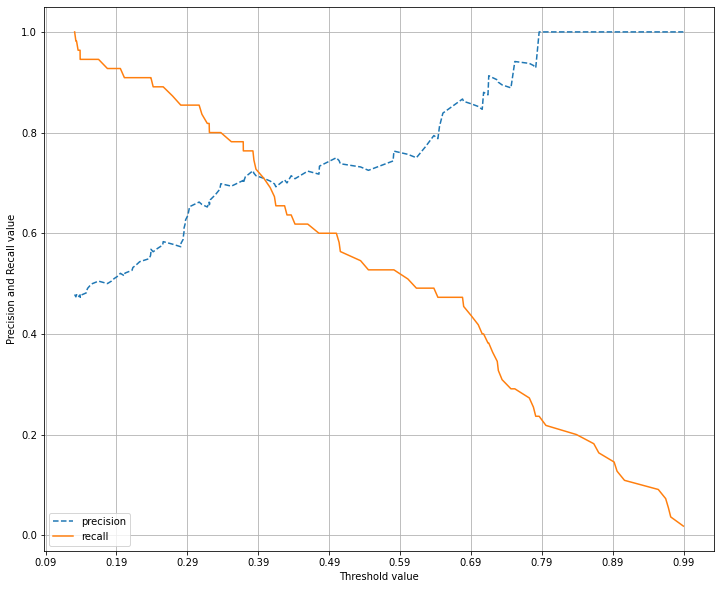

In [111]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt


precision, recalls, threshold = precision_recall_curve(y_test, lr_pred_proba[:,1])

plt.figure(figsize=(12,10))

threshold_boundary = threshold.shape[0]
plt.plot(threshold, precision[0:threshold_boundary],linestyle='--',label='precision')
plt.plot(threshold, recalls[0:threshold_boundary],label='recall')

 # threshold 값 X 축의 Scale을 0.1 단위로 변경
start, end = plt.xlim()
plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
plt.legend(); plt.grid()

Q7. "dataset/auto-mpg.xlsx"을 불러와서 weight의 변화에 따른 mpg를 예측하는 회귀 모델을 생성하고 MSE, RMSE, R2로 평가를 수행하세요.

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df = pd.read_excel("dataset/auto-mpg.xlsx")
ndf = df[['mpg','weight']]
ndf.head()

,mpg,weight
0,18.0,3504
1,15.0,3693
2,18.0,3436
3,16.0,3433
4,17.0,3449


In [124]:
X = ndf[['weight']]
y = ndf['mpg']

X_train, X_test, y_train, y_test = train_test_split(X,y , test_size = 0.2, random_state=156)

In [128]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train,y_train)
lr_pred = lr.predict(X_test)


In [130]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, lr_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, lr_pred)

print('MSE: {}\nRMSE: {}\nR2: {}'.format(mse, rmse, r2))

MSE: 13.203729560108732
RMSE: 3.633693652484856
R2: 0.7616885922825556


Q8. 'auto-mpg.xlsx'를 불러와서 다음을 수행하세요
- 필요한 전처리를 수행하고 mpg를 종속변수, horsepower를 독립변수로 설정후 단순 선형회귀모델을 생성 및 평가
- 다항회귀모델로 변환하여 평가 

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel('dataset/auto-mpg.xlsx')
ndf = df[['mpg','horsepower']]
ndf.head()

,mpg,horsepower
0,18.0,130
1,15.0,165
2,18.0,150
3,16.0,150
4,17.0,140


In [134]:
ndf.horsepower.unique()
ndf.horsepower.replace('?',np.nan,inplace=True)
ndf.dropna(subset=['horsepower'], inplace=True)

In [135]:
ndf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   mpg         392 non-null    float64
 1   horsepower  392 non-null    float64
dtypes: float64(2)
memory usage: 9.2 KB


In [138]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = ndf[['horsepower']]
y = ndf.mpg

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 156)

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

mse = mean_squared_error(y_test, lr_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, lr_pred)

print('MSE: {}\nRMSE: {}\nR2: {}'.format(mse, rmse, r2))

MSE: 26.274821926781218
RMSE: 5.125897182618982
R2: 0.5997385219891043


In [150]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

lr.fit(X_train_poly, y_train)

poly_pred = lr.predict(X_test_poly)

mse = mean_squared_error(y_test, poly_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, poly_pred)

print('MSE: {}\nRMSE: {}\nR2: {}'.format(mse, rmse, r2))

MSE: 18.816659228949504
RMSE: 4.337817334668382
R2: 0.7133535726637998


Q9. santander 은행 데이터에 대하여 필요한 전처리를 수행한 후 고객 만족, 불만족 예측 모델을 다음 2가지 방법으로 생성하고 ROC_AUC로 평가하세요.(단, n_estimators=200으로 설정)
- XGBoost
- LightGBM

In [172]:
bank = pd.read_csv('dataset/bank_train.csv')

bank.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [173]:
bank.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [174]:
bank.var3.replace(-999999,2,inplace=True)

In [175]:
bank.drop('ID',axis=1, inplace=True)

In [186]:
X.shape

(76020, 369)

In [187]:
y = bank.TARGET
X = bank.drop('TARGET',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.2, random_state= 0, stratify=y)

In [188]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators = 200, random_state = 10)
xgb.fit(X_train,y_train, early_stopping_rounds = 100, eval_metric='auc', eval_set=[(X_train,y_train),(X_test,y_test)])

xgb_pred = xgb.predict(X_test)

[0]	validation_0-auc:0.82569	validation_1-auc:0.79283
[1]	validation_0-auc:0.84010	validation_1-auc:0.80737
[2]	validation_0-auc:0.84361	validation_1-auc:0.81021
[3]	validation_0-auc:0.84783	validation_1-auc:0.81287
[4]	validation_0-auc:0.85123	validation_1-auc:0.81469
[5]	validation_0-auc:0.85518	validation_1-auc:0.81860
[6]	validation_0-auc:0.85922	validation_1-auc:0.81977
[7]	validation_0-auc:0.86238	validation_1-auc:0.82034
[8]	validation_0-auc:0.86570	validation_1-auc:0.82147
[9]	validation_0-auc:0.86798	validation_1-auc:0.82301
[10]	validation_0-auc:0.87104	validation_1-auc:0.82379
[11]	validation_0-auc:0.87448	validation_1-auc:0.82456
[12]	validation_0-auc:0.87687	validation_1-auc:0.82401
[13]	validation_0-auc:0.87918	validation_1-auc:0.82467
[14]	validation_0-auc:0.88081	validation_1-auc:0.82508
[15]	validation_0-auc:0.88331	validation_1-auc:0.82379
[16]	validation_0-auc:0.88569	validation_1-auc:0.82457
[17]	validation_0-auc:0.88674	validation_1-auc:0.82453
[18]	validation_0-au

In [189]:
xgb_pred_proba = xgb.predict_proba(X_test)[:,1]

xgb_roc_score = roc_auc_score(y_test, xgb_pred_proba, average='macro')
xgb_roc_score

0.8250790293597425

In [191]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(n_estimators=200)
lgbm.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc', eval_set=[(X_test,y_test)])

[1]	valid_0's auc: 0.795963	valid_0's binary_logloss: 0.159288
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.801789	valid_0's binary_logloss: 0.155038
[3]	valid_0's auc: 0.803367	valid_0's binary_logloss: 0.15185
[4]	valid_0's auc: 0.805168	valid_0's binary_logloss: 0.14961
[5]	valid_0's auc: 0.809401	valid_0's binary_logloss: 0.147695
[6]	valid_0's auc: 0.810671	valid_0's binary_logloss: 0.146234
[7]	valid_0's auc: 0.815356	valid_0's binary_logloss: 0.144877
[8]	valid_0's auc: 0.816777	valid_0's binary_logloss: 0.143783
[9]	valid_0's auc: 0.817821	valid_0's binary_logloss: 0.143084
[10]	valid_0's auc: 0.818637	valid_0's binary_logloss: 0.142272
[11]	valid_0's auc: 0.81939	valid_0's binary_logloss: 0.141623
[12]	valid_0's auc: 0.821106	valid_0's binary_logloss: 0.141043
[13]	valid_0's auc: 0.822008	valid_0's binary_logloss: 0.140628
[14]	valid_0's auc: 0.822584	valid_0's binary_logloss: 0.140198
[15]	valid_0's auc: 0.822291	valid_0's binary_logloss:

[132]	valid_0's auc: 0.812236	valid_0's binary_logloss: 0.141618
[133]	valid_0's auc: 0.812159	valid_0's binary_logloss: 0.141665
[134]	valid_0's auc: 0.811863	valid_0's binary_logloss: 0.141757
[135]	valid_0's auc: 0.811658	valid_0's binary_logloss: 0.141818
[136]	valid_0's auc: 0.811612	valid_0's binary_logloss: 0.141817
[137]	valid_0's auc: 0.811529	valid_0's binary_logloss: 0.14184
[138]	valid_0's auc: 0.811442	valid_0's binary_logloss: 0.141896
[139]	valid_0's auc: 0.811524	valid_0's binary_logloss: 0.141931
[140]	valid_0's auc: 0.811309	valid_0's binary_logloss: 0.142004
[141]	valid_0's auc: 0.811321	valid_0's binary_logloss: 0.142035
[142]	valid_0's auc: 0.811275	valid_0's binary_logloss: 0.142077
[143]	valid_0's auc: 0.811453	valid_0's binary_logloss: 0.142082
Early stopping, best iteration is:
[43]	valid_0's auc: 0.823891	valid_0's binary_logloss: 0.138182


LGBMClassifier(n_estimators=200)

In [193]:
lgbm_pred_proba = lgbm.predict_proba(X_test)[:,1]
lgbm_roc_score = roc_auc_score(y_test, lgbm_pred_proba)
lgbm_roc_score

0.8238910293542823

Q10. Q9번에서 lightgbm 방식의 성능 개선 작업을 수행 후 최적의 하이퍼 파라미터를 적용하여 평가를 수행하세요.

In [197]:
lgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 200,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [208]:
import time
time.time()

1630172583.6686597

In [209]:
from sklearn.model_selection import GridSearchCV
import time

params = {
    'max_depth':[-1,0,1],
    'min_child_sample':[10,20],
    'n_estimators':[100,200],
    'learning_rate':[0.1,0.2],
}

start_time = time.time()
lgbm_grid = GridSearchCV(lgbm ,param_grid = params)
lgbm_grid.fit(X,y, eval_metric='auc', early_stopping_rounds=100, eval_set = [(X_train,y_train),(X_test,y_test)])

print(time.time()-start_time)

[LightGBM] [Warning] Unknown parameter: min_child_sample
[1]	valid_0's auc: 0.819331	valid_0's binary_logloss: 0.15761	valid_1's auc: 0.797228	valid_1's binary_logloss: 0.158536
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.83581	valid_0's binary_logloss: 0.152122	valid_1's auc: 0.818052	valid_1's binary_logloss: 0.153354
[3]	valid_0's auc: 0.840284	valid_0's binary_logloss: 0.148058	valid_1's auc: 0.823824	valid_1's binary_logloss: 0.149452
[4]	valid_0's auc: 0.842371	valid_0's binary_logloss: 0.145012	valid_1's auc: 0.82804	valid_1's binary_logloss: 0.146777
[5]	valid_0's auc: 0.846114	valid_0's binary_logloss: 0.142513	valid_1's auc: 0.831234	valid_1's binary_logloss: 0.14445
[6]	valid_0's auc: 0.84854	valid_0's binary_logloss: 0.140397	valid_1's auc: 0.831708	valid_1's binary_logloss: 0.14264
[7]	valid_0's auc: 0.849884	valid_0's binary_logloss: 0.138611	valid_1's auc: 0.834341	valid_1's binary_logloss: 0.141109
[8]	valid_0's auc: 0.852763	valid

[75]	valid_0's auc: 0.90048	valid_0's binary_logloss: 0.115188	valid_1's auc: 0.886279	valid_1's binary_logloss: 0.119101
[76]	valid_0's auc: 0.900604	valid_0's binary_logloss: 0.115094	valid_1's auc: 0.886294	valid_1's binary_logloss: 0.119039
[77]	valid_0's auc: 0.901102	valid_0's binary_logloss: 0.114881	valid_1's auc: 0.886324	valid_1's binary_logloss: 0.118976
[78]	valid_0's auc: 0.901481	valid_0's binary_logloss: 0.114764	valid_1's auc: 0.886715	valid_1's binary_logloss: 0.118888
[79]	valid_0's auc: 0.901712	valid_0's binary_logloss: 0.114649	valid_1's auc: 0.886897	valid_1's binary_logloss: 0.118786
[80]	valid_0's auc: 0.901878	valid_0's binary_logloss: 0.114565	valid_1's auc: 0.887203	valid_1's binary_logloss: 0.118633
[81]	valid_0's auc: 0.902492	valid_0's binary_logloss: 0.114376	valid_1's auc: 0.88761	valid_1's binary_logloss: 0.118543
[82]	valid_0's auc: 0.902869	valid_0's binary_logloss: 0.11421	valid_1's auc: 0.887983	valid_1's binary_logloss: 0.118393
[83]	valid_0's auc:

[50]	valid_0's auc: 0.889952	valid_0's binary_logloss: 0.119477	valid_1's auc: 0.875608	valid_1's binary_logloss: 0.1231
[51]	valid_0's auc: 0.890537	valid_0's binary_logloss: 0.119271	valid_1's auc: 0.876256	valid_1's binary_logloss: 0.122816
[52]	valid_0's auc: 0.890847	valid_0's binary_logloss: 0.119107	valid_1's auc: 0.876695	valid_1's binary_logloss: 0.122632
[53]	valid_0's auc: 0.891327	valid_0's binary_logloss: 0.118923	valid_1's auc: 0.877148	valid_1's binary_logloss: 0.122451
[54]	valid_0's auc: 0.892036	valid_0's binary_logloss: 0.118693	valid_1's auc: 0.877396	valid_1's binary_logloss: 0.122289
[55]	valid_0's auc: 0.892625	valid_0's binary_logloss: 0.118472	valid_1's auc: 0.877842	valid_1's binary_logloss: 0.122153
[56]	valid_0's auc: 0.892936	valid_0's binary_logloss: 0.118321	valid_1's auc: 0.878597	valid_1's binary_logloss: 0.121906
[57]	valid_0's auc: 0.893252	valid_0's binary_logloss: 0.118178	valid_1's auc: 0.878737	valid_1's binary_logloss: 0.121848
[58]	valid_0's auc

[26]	valid_0's auc: 0.875327	valid_0's binary_logloss: 0.125001	valid_1's auc: 0.85978	valid_1's binary_logloss: 0.128666
[27]	valid_0's auc: 0.876802	valid_0's binary_logloss: 0.124608	valid_1's auc: 0.861642	valid_1's binary_logloss: 0.12834
[28]	valid_0's auc: 0.8774	valid_0's binary_logloss: 0.124328	valid_1's auc: 0.86268	valid_1's binary_logloss: 0.127933
[29]	valid_0's auc: 0.878392	valid_0's binary_logloss: 0.123971	valid_1's auc: 0.863361	valid_1's binary_logloss: 0.127764
[30]	valid_0's auc: 0.879032	valid_0's binary_logloss: 0.123689	valid_1's auc: 0.863984	valid_1's binary_logloss: 0.127531
[31]	valid_0's auc: 0.880177	valid_0's binary_logloss: 0.123351	valid_1's auc: 0.864521	valid_1's binary_logloss: 0.127274
[32]	valid_0's auc: 0.881058	valid_0's binary_logloss: 0.123023	valid_1's auc: 0.864784	valid_1's binary_logloss: 0.127141
[33]	valid_0's auc: 0.881492	valid_0's binary_logloss: 0.122812	valid_1's auc: 0.866371	valid_1's binary_logloss: 0.126728
[34]	valid_0's auc: 0

[99]	valid_0's auc: 0.907172	valid_0's binary_logloss: 0.111999	valid_1's auc: 0.900989	valid_1's binary_logloss: 0.114283
[100]	valid_0's auc: 0.907317	valid_0's binary_logloss: 0.111918	valid_1's auc: 0.901011	valid_1's binary_logloss: 0.114232
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.907317	valid_0's binary_logloss: 0.111918	valid_1's auc: 0.901011	valid_1's binary_logloss: 0.114232
[LightGBM] [Warning] Unknown parameter: min_child_sample
[1]	valid_0's auc: 0.824467	valid_0's binary_logloss: 0.157787	valid_1's auc: 0.80336	valid_1's binary_logloss: 0.158048
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.831639	valid_0's binary_logloss: 0.152469	valid_1's auc: 0.816192	valid_1's binary_logloss: 0.152998
[3]	valid_0's auc: 0.837251	valid_0's binary_logloss: 0.148597	valid_1's auc: 0.823948	valid_1's binary_logloss: 0.149203
[4]	valid_0's auc: 0.841582	valid_0's binary_logloss: 0.145552	valid_1's auc: 0.82786	valid_1's b

[72]	valid_0's auc: 0.901271	valid_0's binary_logloss: 0.115914	valid_1's auc: 0.893725	valid_1's binary_logloss: 0.116861
[73]	valid_0's auc: 0.901632	valid_0's binary_logloss: 0.115722	valid_1's auc: 0.893887	valid_1's binary_logloss: 0.116712
[74]	valid_0's auc: 0.902228	valid_0's binary_logloss: 0.115487	valid_1's auc: 0.894831	valid_1's binary_logloss: 0.116452
[75]	valid_0's auc: 0.902814	valid_0's binary_logloss: 0.115294	valid_1's auc: 0.895534	valid_1's binary_logloss: 0.116254
[76]	valid_0's auc: 0.90298	valid_0's binary_logloss: 0.115193	valid_1's auc: 0.895759	valid_1's binary_logloss: 0.116135
[77]	valid_0's auc: 0.903186	valid_0's binary_logloss: 0.115062	valid_1's auc: 0.896337	valid_1's binary_logloss: 0.115873
[78]	valid_0's auc: 0.903563	valid_0's binary_logloss: 0.114877	valid_1's auc: 0.896688	valid_1's binary_logloss: 0.115684
[79]	valid_0's auc: 0.903712	valid_0's binary_logloss: 0.114763	valid_1's auc: 0.896779	valid_1's binary_logloss: 0.115589
[80]	valid_0's au

[36]	valid_0's auc: 0.884284	valid_0's binary_logloss: 0.122152	valid_1's auc: 0.873193	valid_1's binary_logloss: 0.12478
[37]	valid_0's auc: 0.885425	valid_0's binary_logloss: 0.121857	valid_1's auc: 0.873455	valid_1's binary_logloss: 0.124649
[38]	valid_0's auc: 0.885933	valid_0's binary_logloss: 0.121629	valid_1's auc: 0.874255	valid_1's binary_logloss: 0.124367
[39]	valid_0's auc: 0.886511	valid_0's binary_logloss: 0.121375	valid_1's auc: 0.874931	valid_1's binary_logloss: 0.124087
[40]	valid_0's auc: 0.887341	valid_0's binary_logloss: 0.121141	valid_1's auc: 0.87679	valid_1's binary_logloss: 0.123593
[41]	valid_0's auc: 0.888079	valid_0's binary_logloss: 0.120871	valid_1's auc: 0.877751	valid_1's binary_logloss: 0.123355
[42]	valid_0's auc: 0.888314	valid_0's binary_logloss: 0.120705	valid_1's auc: 0.8778	valid_1's binary_logloss: 0.12318
[43]	valid_0's auc: 0.888694	valid_0's binary_logloss: 0.120509	valid_1's auc: 0.87806	valid_1's binary_logloss: 0.12301
[44]	valid_0's auc: 0.8

[14]	valid_0's auc: 0.861589	valid_0's binary_logloss: 0.131112	valid_1's auc: 0.846187	valid_1's binary_logloss: 0.134279
[15]	valid_0's auc: 0.862515	valid_0's binary_logloss: 0.130455	valid_1's auc: 0.846775	valid_1's binary_logloss: 0.133721
[16]	valid_0's auc: 0.86359	valid_0's binary_logloss: 0.129854	valid_1's auc: 0.847157	valid_1's binary_logloss: 0.133234
[17]	valid_0's auc: 0.864609	valid_0's binary_logloss: 0.129255	valid_1's auc: 0.848427	valid_1's binary_logloss: 0.13281
[18]	valid_0's auc: 0.86573	valid_0's binary_logloss: 0.128734	valid_1's auc: 0.849249	valid_1's binary_logloss: 0.132346
[19]	valid_0's auc: 0.8668	valid_0's binary_logloss: 0.128248	valid_1's auc: 0.8523	valid_1's binary_logloss: 0.131684
[20]	valid_0's auc: 0.867662	valid_0's binary_logloss: 0.127778	valid_1's auc: 0.852834	valid_1's binary_logloss: 0.131271
[21]	valid_0's auc: 0.868915	valid_0's binary_logloss: 0.127229	valid_1's auc: 0.854019	valid_1's binary_logloss: 0.130902
[22]	valid_0's auc: 0.8

[87]	valid_0's auc: 0.903914	valid_0's binary_logloss: 0.113671	valid_1's auc: 0.889166	valid_1's binary_logloss: 0.117798
[88]	valid_0's auc: 0.904357	valid_0's binary_logloss: 0.113524	valid_1's auc: 0.889932	valid_1's binary_logloss: 0.117589
[89]	valid_0's auc: 0.904579	valid_0's binary_logloss: 0.113392	valid_1's auc: 0.890133	valid_1's binary_logloss: 0.117499
[90]	valid_0's auc: 0.904865	valid_0's binary_logloss: 0.113246	valid_1's auc: 0.890737	valid_1's binary_logloss: 0.117243
[91]	valid_0's auc: 0.905019	valid_0's binary_logloss: 0.113145	valid_1's auc: 0.890855	valid_1's binary_logloss: 0.117172
[92]	valid_0's auc: 0.905527	valid_0's binary_logloss: 0.112946	valid_1's auc: 0.891782	valid_1's binary_logloss: 0.116889
[93]	valid_0's auc: 0.906125	valid_0's binary_logloss: 0.11273	valid_1's auc: 0.891933	valid_1's binary_logloss: 0.11678
[94]	valid_0's auc: 0.906446	valid_0's binary_logloss: 0.112579	valid_1's auc: 0.892456	valid_1's binary_logloss: 0.116565
[95]	valid_0's auc

[162]	valid_0's auc: 0.921788	valid_0's binary_logloss: 0.104605	valid_1's auc: 0.908278	valid_1's binary_logloss: 0.10933
[163]	valid_0's auc: 0.92187	valid_0's binary_logloss: 0.104544	valid_1's auc: 0.908335	valid_1's binary_logloss: 0.109291
[164]	valid_0's auc: 0.921961	valid_0's binary_logloss: 0.104463	valid_1's auc: 0.908409	valid_1's binary_logloss: 0.109222
[165]	valid_0's auc: 0.922044	valid_0's binary_logloss: 0.104416	valid_1's auc: 0.908485	valid_1's binary_logloss: 0.109173
[166]	valid_0's auc: 0.922049	valid_0's binary_logloss: 0.104391	valid_1's auc: 0.908458	valid_1's binary_logloss: 0.109121
[167]	valid_0's auc: 0.9221	valid_0's binary_logloss: 0.104339	valid_1's auc: 0.908576	valid_1's binary_logloss: 0.109038
[168]	valid_0's auc: 0.922134	valid_0's binary_logloss: 0.104299	valid_1's auc: 0.908663	valid_1's binary_logloss: 0.108981
[169]	valid_0's auc: 0.922201	valid_0's binary_logloss: 0.104228	valid_1's auc: 0.9087	valid_1's binary_logloss: 0.108931
[170]	valid_0'

[38]	valid_0's auc: 0.883285	valid_0's binary_logloss: 0.121961	valid_1's auc: 0.870481	valid_1's binary_logloss: 0.125231
[39]	valid_0's auc: 0.883743	valid_0's binary_logloss: 0.121766	valid_1's auc: 0.870956	valid_1's binary_logloss: 0.125037
[40]	valid_0's auc: 0.884143	valid_0's binary_logloss: 0.121586	valid_1's auc: 0.871433	valid_1's binary_logloss: 0.12483
[41]	valid_0's auc: 0.8848	valid_0's binary_logloss: 0.121323	valid_1's auc: 0.872161	valid_1's binary_logloss: 0.12453
[42]	valid_0's auc: 0.885865	valid_0's binary_logloss: 0.12106	valid_1's auc: 0.873122	valid_1's binary_logloss: 0.124357
[43]	valid_0's auc: 0.886821	valid_0's binary_logloss: 0.120824	valid_1's auc: 0.87329	valid_1's binary_logloss: 0.124235
[44]	valid_0's auc: 0.887227	valid_0's binary_logloss: 0.120628	valid_1's auc: 0.873696	valid_1's binary_logloss: 0.124035
[45]	valid_0's auc: 0.887707	valid_0's binary_logloss: 0.120426	valid_1's auc: 0.873875	valid_1's binary_logloss: 0.123862
[46]	valid_0's auc: 0.

[108]	valid_0's auc: 0.906794	valid_0's binary_logloss: 0.111556	valid_1's auc: 0.892184	valid_1's binary_logloss: 0.115143
[109]	valid_0's auc: 0.907659	valid_0's binary_logloss: 0.11132	valid_1's auc: 0.893237	valid_1's binary_logloss: 0.114928
[110]	valid_0's auc: 0.908174	valid_0's binary_logloss: 0.1111	valid_1's auc: 0.893314	valid_1's binary_logloss: 0.114875
[111]	valid_0's auc: 0.908481	valid_0's binary_logloss: 0.11094	valid_1's auc: 0.893634	valid_1's binary_logloss: 0.114682
[112]	valid_0's auc: 0.909131	valid_0's binary_logloss: 0.110768	valid_1's auc: 0.894507	valid_1's binary_logloss: 0.114506
[113]	valid_0's auc: 0.909597	valid_0's binary_logloss: 0.110574	valid_1's auc: 0.894813	valid_1's binary_logloss: 0.114368
[114]	valid_0's auc: 0.909782	valid_0's binary_logloss: 0.110463	valid_1's auc: 0.894993	valid_1's binary_logloss: 0.114247
[115]	valid_0's auc: 0.910038	valid_0's binary_logloss: 0.110307	valid_1's auc: 0.895207	valid_1's binary_logloss: 0.114099
[116]	valid_

[184]	valid_0's auc: 0.922125	valid_0's binary_logloss: 0.103764	valid_1's auc: 0.907834	valid_1's binary_logloss: 0.107411
[185]	valid_0's auc: 0.922169	valid_0's binary_logloss: 0.103705	valid_1's auc: 0.907858	valid_1's binary_logloss: 0.107369
[186]	valid_0's auc: 0.92241	valid_0's binary_logloss: 0.103581	valid_1's auc: 0.908243	valid_1's binary_logloss: 0.107239
[187]	valid_0's auc: 0.922616	valid_0's binary_logloss: 0.103471	valid_1's auc: 0.908421	valid_1's binary_logloss: 0.107134
[188]	valid_0's auc: 0.922825	valid_0's binary_logloss: 0.103355	valid_1's auc: 0.9086	valid_1's binary_logloss: 0.107013
[189]	valid_0's auc: 0.923045	valid_0's binary_logloss: 0.10325	valid_1's auc: 0.908777	valid_1's binary_logloss: 0.106924
[190]	valid_0's auc: 0.923156	valid_0's binary_logloss: 0.103176	valid_1's auc: 0.908729	valid_1's binary_logloss: 0.10688
[191]	valid_0's auc: 0.92322	valid_0's binary_logloss: 0.103112	valid_1's auc: 0.908849	valid_1's binary_logloss: 0.106803
[192]	valid_0'

[49]	valid_0's auc: 0.891417	valid_0's binary_logloss: 0.119245	valid_1's auc: 0.88048	valid_1's binary_logloss: 0.122559
[50]	valid_0's auc: 0.891737	valid_0's binary_logloss: 0.119064	valid_1's auc: 0.880778	valid_1's binary_logloss: 0.122369
[51]	valid_0's auc: 0.891918	valid_0's binary_logloss: 0.118945	valid_1's auc: 0.880877	valid_1's binary_logloss: 0.12225
[52]	valid_0's auc: 0.892152	valid_0's binary_logloss: 0.118828	valid_1's auc: 0.881447	valid_1's binary_logloss: 0.122091
[53]	valid_0's auc: 0.892412	valid_0's binary_logloss: 0.118677	valid_1's auc: 0.881678	valid_1's binary_logloss: 0.121931
[54]	valid_0's auc: 0.892625	valid_0's binary_logloss: 0.118551	valid_1's auc: 0.882131	valid_1's binary_logloss: 0.121739
[55]	valid_0's auc: 0.892755	valid_0's binary_logloss: 0.118441	valid_1's auc: 0.882469	valid_1's binary_logloss: 0.121585
[56]	valid_0's auc: 0.893095	valid_0's binary_logloss: 0.118266	valid_1's auc: 0.882726	valid_1's binary_logloss: 0.121427
[57]	valid_0's auc

[124]	valid_0's auc: 0.911893	valid_0's binary_logloss: 0.109432	valid_1's auc: 0.907053	valid_1's binary_logloss: 0.111206
[125]	valid_0's auc: 0.912157	valid_0's binary_logloss: 0.109274	valid_1's auc: 0.90716	valid_1's binary_logloss: 0.111091
[126]	valid_0's auc: 0.912609	valid_0's binary_logloss: 0.109086	valid_1's auc: 0.907784	valid_1's binary_logloss: 0.110856
[127]	valid_0's auc: 0.912869	valid_0's binary_logloss: 0.108947	valid_1's auc: 0.907946	valid_1's binary_logloss: 0.110772
[128]	valid_0's auc: 0.91307	valid_0's binary_logloss: 0.108821	valid_1's auc: 0.908141	valid_1's binary_logloss: 0.110633
[129]	valid_0's auc: 0.913386	valid_0's binary_logloss: 0.108676	valid_1's auc: 0.908267	valid_1's binary_logloss: 0.110527
[130]	valid_0's auc: 0.913748	valid_0's binary_logloss: 0.108532	valid_1's auc: 0.908591	valid_1's binary_logloss: 0.110414
[131]	valid_0's auc: 0.91389	valid_0's binary_logloss: 0.108453	valid_1's auc: 0.908875	valid_1's binary_logloss: 0.110274
[132]	valid

[LightGBM] [Warning] Unknown parameter: min_child_sample
[1]	valid_0's auc: 0.824467	valid_0's binary_logloss: 0.157787	valid_1's auc: 0.80336	valid_1's binary_logloss: 0.158048
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.831639	valid_0's binary_logloss: 0.152469	valid_1's auc: 0.816192	valid_1's binary_logloss: 0.152998
[3]	valid_0's auc: 0.837251	valid_0's binary_logloss: 0.148597	valid_1's auc: 0.823948	valid_1's binary_logloss: 0.149203
[4]	valid_0's auc: 0.841582	valid_0's binary_logloss: 0.145552	valid_1's auc: 0.82786	valid_1's binary_logloss: 0.146261
[5]	valid_0's auc: 0.847454	valid_0's binary_logloss: 0.142962	valid_1's auc: 0.834332	valid_1's binary_logloss: 0.143959
[6]	valid_0's auc: 0.84977	valid_0's binary_logloss: 0.140869	valid_1's auc: 0.835757	valid_1's binary_logloss: 0.14188
[7]	valid_0's auc: 0.852273	valid_0's binary_logloss: 0.139054	valid_1's auc: 0.838449	valid_1's binary_logloss: 0.140342
[8]	valid_0's auc: 0.853991	val

[72]	valid_0's auc: 0.901271	valid_0's binary_logloss: 0.115914	valid_1's auc: 0.893725	valid_1's binary_logloss: 0.116861
[73]	valid_0's auc: 0.901632	valid_0's binary_logloss: 0.115722	valid_1's auc: 0.893887	valid_1's binary_logloss: 0.116712
[74]	valid_0's auc: 0.902228	valid_0's binary_logloss: 0.115487	valid_1's auc: 0.894831	valid_1's binary_logloss: 0.116452
[75]	valid_0's auc: 0.902814	valid_0's binary_logloss: 0.115294	valid_1's auc: 0.895534	valid_1's binary_logloss: 0.116254
[76]	valid_0's auc: 0.90298	valid_0's binary_logloss: 0.115193	valid_1's auc: 0.895759	valid_1's binary_logloss: 0.116135
[77]	valid_0's auc: 0.903186	valid_0's binary_logloss: 0.115062	valid_1's auc: 0.896337	valid_1's binary_logloss: 0.115873
[78]	valid_0's auc: 0.903563	valid_0's binary_logloss: 0.114877	valid_1's auc: 0.896688	valid_1's binary_logloss: 0.115684
[79]	valid_0's auc: 0.903712	valid_0's binary_logloss: 0.114763	valid_1's auc: 0.896779	valid_1's binary_logloss: 0.115589
[80]	valid_0's au

[149]	valid_0's auc: 0.919684	valid_0's binary_logloss: 0.106503	valid_1's auc: 0.913607	valid_1's binary_logloss: 0.106761
[150]	valid_0's auc: 0.919717	valid_0's binary_logloss: 0.106434	valid_1's auc: 0.913678	valid_1's binary_logloss: 0.106682
[151]	valid_0's auc: 0.91986	valid_0's binary_logloss: 0.106342	valid_1's auc: 0.913748	valid_1's binary_logloss: 0.106579
[152]	valid_0's auc: 0.919904	valid_0's binary_logloss: 0.106284	valid_1's auc: 0.913751	valid_1's binary_logloss: 0.106537
[153]	valid_0's auc: 0.920089	valid_0's binary_logloss: 0.106172	valid_1's auc: 0.913913	valid_1's binary_logloss: 0.10642
[154]	valid_0's auc: 0.920171	valid_0's binary_logloss: 0.106103	valid_1's auc: 0.913894	valid_1's binary_logloss: 0.106404
[155]	valid_0's auc: 0.920221	valid_0's binary_logloss: 0.106049	valid_1's auc: 0.913917	valid_1's binary_logloss: 0.106357
[156]	valid_0's auc: 0.920248	valid_0's binary_logloss: 0.105995	valid_1's auc: 0.913994	valid_1's binary_logloss: 0.106306
[157]	vali

[13]	valid_0's auc: 0.86008	valid_0's binary_logloss: 0.131964	valid_1's auc: 0.846838	valid_1's binary_logloss: 0.13425
[14]	valid_0's auc: 0.861596	valid_0's binary_logloss: 0.131166	valid_1's auc: 0.847656	valid_1's binary_logloss: 0.133651
[15]	valid_0's auc: 0.863151	valid_0's binary_logloss: 0.130447	valid_1's auc: 0.849374	valid_1's binary_logloss: 0.133003
[16]	valid_0's auc: 0.863849	valid_0's binary_logloss: 0.129835	valid_1's auc: 0.849932	valid_1's binary_logloss: 0.13236
[17]	valid_0's auc: 0.865536	valid_0's binary_logloss: 0.129215	valid_1's auc: 0.85189	valid_1's binary_logloss: 0.131854
[18]	valid_0's auc: 0.867009	valid_0's binary_logloss: 0.128647	valid_1's auc: 0.85245	valid_1's binary_logloss: 0.131537
[19]	valid_0's auc: 0.868323	valid_0's binary_logloss: 0.128104	valid_1's auc: 0.853871	valid_1's binary_logloss: 0.131161
[20]	valid_0's auc: 0.869366	valid_0's binary_logloss: 0.127612	valid_1's auc: 0.855344	valid_1's binary_logloss: 0.130627
[21]	valid_0's auc: 0

[86]	valid_0's auc: 0.905127	valid_0's binary_logloss: 0.113523	valid_1's auc: 0.895736	valid_1's binary_logloss: 0.115675
[87]	valid_0's auc: 0.9055	valid_0's binary_logloss: 0.11336	valid_1's auc: 0.896205	valid_1's binary_logloss: 0.115442
[88]	valid_0's auc: 0.90593	valid_0's binary_logloss: 0.113206	valid_1's auc: 0.896865	valid_1's binary_logloss: 0.115219
[89]	valid_0's auc: 0.906076	valid_0's binary_logloss: 0.113108	valid_1's auc: 0.896829	valid_1's binary_logloss: 0.115183
[90]	valid_0's auc: 0.906207	valid_0's binary_logloss: 0.11297	valid_1's auc: 0.897055	valid_1's binary_logloss: 0.115054
[91]	valid_0's auc: 0.906653	valid_0's binary_logloss: 0.112736	valid_1's auc: 0.897312	valid_1's binary_logloss: 0.114918
[92]	valid_0's auc: 0.906863	valid_0's binary_logloss: 0.112632	valid_1's auc: 0.897735	valid_1's binary_logloss: 0.114726
[93]	valid_0's auc: 0.906983	valid_0's binary_logloss: 0.112542	valid_1's auc: 0.897874	valid_1's binary_logloss: 0.114616
[94]	valid_0's auc: 0

[160]	valid_0's auc: 0.91702	valid_0's binary_logloss: 0.10628	valid_1's auc: 0.91183	valid_1's binary_logloss: 0.107326
[161]	valid_0's auc: 0.917056	valid_0's binary_logloss: 0.106236	valid_1's auc: 0.911917	valid_1's binary_logloss: 0.107266
[162]	valid_0's auc: 0.917126	valid_0's binary_logloss: 0.106164	valid_1's auc: 0.911927	valid_1's binary_logloss: 0.107212
[163]	valid_0's auc: 0.917518	valid_0's binary_logloss: 0.106053	valid_1's auc: 0.911906	valid_1's binary_logloss: 0.107188
[164]	valid_0's auc: 0.917497	valid_0's binary_logloss: 0.106012	valid_1's auc: 0.911981	valid_1's binary_logloss: 0.107139
[165]	valid_0's auc: 0.917565	valid_0's binary_logloss: 0.105947	valid_1's auc: 0.912022	valid_1's binary_logloss: 0.107064
[166]	valid_0's auc: 0.918088	valid_0's binary_logloss: 0.10577	valid_1's auc: 0.91241	valid_1's binary_logloss: 0.106951
[167]	valid_0's auc: 0.918328	valid_0's binary_logloss: 0.105621	valid_1's auc: 0.91284	valid_1's binary_logloss: 0.106793
[168]	valid_0'

[25]	valid_0's auc: 0.874856	valid_0's binary_logloss: 0.125448	valid_1's auc: 0.858806	valid_1's binary_logloss: 0.129413
[26]	valid_0's auc: 0.875272	valid_0's binary_logloss: 0.125137	valid_1's auc: 0.86037	valid_1's binary_logloss: 0.129001
[27]	valid_0's auc: 0.875968	valid_0's binary_logloss: 0.124819	valid_1's auc: 0.862251	valid_1's binary_logloss: 0.128436
[28]	valid_0's auc: 0.876651	valid_0's binary_logloss: 0.124516	valid_1's auc: 0.86299	valid_1's binary_logloss: 0.128102
[29]	valid_0's auc: 0.877225	valid_0's binary_logloss: 0.124244	valid_1's auc: 0.863604	valid_1's binary_logloss: 0.127791
[30]	valid_0's auc: 0.877925	valid_0's binary_logloss: 0.123956	valid_1's auc: 0.863946	valid_1's binary_logloss: 0.12757
[31]	valid_0's auc: 0.878632	valid_0's binary_logloss: 0.123695	valid_1's auc: 0.864916	valid_1's binary_logloss: 0.127208
[32]	valid_0's auc: 0.879316	valid_0's binary_logloss: 0.123431	valid_1's auc: 0.865937	valid_1's binary_logloss: 0.126937
[33]	valid_0's auc:

[97]	valid_0's auc: 0.907144	valid_0's binary_logloss: 0.11222	valid_1's auc: 0.89383	valid_1's binary_logloss: 0.116123
[98]	valid_0's auc: 0.907603	valid_0's binary_logloss: 0.112006	valid_1's auc: 0.894581	valid_1's binary_logloss: 0.115834
[99]	valid_0's auc: 0.907985	valid_0's binary_logloss: 0.111846	valid_1's auc: 0.894826	valid_1's binary_logloss: 0.115653
[100]	valid_0's auc: 0.908187	valid_0's binary_logloss: 0.111717	valid_1's auc: 0.894976	valid_1's binary_logloss: 0.11552
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.908187	valid_0's binary_logloss: 0.111717	valid_1's auc: 0.894976	valid_1's binary_logloss: 0.11552
[LightGBM] [Warning] Unknown parameter: min_child_sample
[1]	valid_0's auc: 0.824254	valid_0's binary_logloss: 0.157446	valid_1's auc: 0.804164	valid_1's binary_logloss: 0.158391
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.830298	valid_0's binary_logloss: 0.151948	valid_1's auc: 0.812741	valid_1's b

[72]	valid_0's auc: 0.898723	valid_0's binary_logloss: 0.115746	valid_1's auc: 0.883696	valid_1's binary_logloss: 0.119535
[73]	valid_0's auc: 0.898911	valid_0's binary_logloss: 0.115638	valid_1's auc: 0.884085	valid_1's binary_logloss: 0.119302
[74]	valid_0's auc: 0.899045	valid_0's binary_logloss: 0.115531	valid_1's auc: 0.884254	valid_1's binary_logloss: 0.119236
[75]	valid_0's auc: 0.899365	valid_0's binary_logloss: 0.115381	valid_1's auc: 0.884563	valid_1's binary_logloss: 0.119044
[76]	valid_0's auc: 0.899506	valid_0's binary_logloss: 0.115284	valid_1's auc: 0.884994	valid_1's binary_logloss: 0.118916
[77]	valid_0's auc: 0.899771	valid_0's binary_logloss: 0.115166	valid_1's auc: 0.885276	valid_1's binary_logloss: 0.118766
[78]	valid_0's auc: 0.900146	valid_0's binary_logloss: 0.114995	valid_1's auc: 0.885111	valid_1's binary_logloss: 0.11872
[79]	valid_0's auc: 0.900376	valid_0's binary_logloss: 0.114862	valid_1's auc: 0.885195	valid_1's binary_logloss: 0.118673
[80]	valid_0's au

[39]	valid_0's auc: 0.88602	valid_0's binary_logloss: 0.121175	valid_1's auc: 0.872235	valid_1's binary_logloss: 0.12517
[40]	valid_0's auc: 0.886361	valid_0's binary_logloss: 0.12098	valid_1's auc: 0.872679	valid_1's binary_logloss: 0.12489
[41]	valid_0's auc: 0.886947	valid_0's binary_logloss: 0.120743	valid_1's auc: 0.873619	valid_1's binary_logloss: 0.12454
[42]	valid_0's auc: 0.887638	valid_0's binary_logloss: 0.120508	valid_1's auc: 0.874691	valid_1's binary_logloss: 0.124212
[43]	valid_0's auc: 0.888294	valid_0's binary_logloss: 0.120323	valid_1's auc: 0.876243	valid_1's binary_logloss: 0.123865
[44]	valid_0's auc: 0.889111	valid_0's binary_logloss: 0.12012	valid_1's auc: 0.87726	valid_1's binary_logloss: 0.123665
[45]	valid_0's auc: 0.889795	valid_0's binary_logloss: 0.119916	valid_1's auc: 0.878222	valid_1's binary_logloss: 0.123401
[46]	valid_0's auc: 0.890222	valid_0's binary_logloss: 0.119739	valid_1's auc: 0.878519	valid_1's binary_logloss: 0.123221
[47]	valid_0's auc: 0.8

[13]	valid_0's auc: 0.862371	valid_0's binary_logloss: 0.132267	valid_1's auc: 0.847791	valid_1's binary_logloss: 0.134033
[14]	valid_0's auc: 0.864056	valid_0's binary_logloss: 0.131485	valid_1's auc: 0.848373	valid_1's binary_logloss: 0.133416
[15]	valid_0's auc: 0.865261	valid_0's binary_logloss: 0.130802	valid_1's auc: 0.848786	valid_1's binary_logloss: 0.132868
[16]	valid_0's auc: 0.865757	valid_0's binary_logloss: 0.130241	valid_1's auc: 0.849811	valid_1's binary_logloss: 0.13224
[17]	valid_0's auc: 0.866523	valid_0's binary_logloss: 0.129697	valid_1's auc: 0.850286	valid_1's binary_logloss: 0.13176
[18]	valid_0's auc: 0.867397	valid_0's binary_logloss: 0.129166	valid_1's auc: 0.851612	valid_1's binary_logloss: 0.131201
[19]	valid_0's auc: 0.868828	valid_0's binary_logloss: 0.128614	valid_1's auc: 0.853091	valid_1's binary_logloss: 0.130674
[20]	valid_0's auc: 0.869385	valid_0's binary_logloss: 0.128174	valid_1's auc: 0.853746	valid_1's binary_logloss: 0.130261
[21]	valid_0's auc

[87]	valid_0's auc: 0.905755	valid_0's binary_logloss: 0.113668	valid_1's auc: 0.899719	valid_1's binary_logloss: 0.114264
[88]	valid_0's auc: 0.906266	valid_0's binary_logloss: 0.113478	valid_1's auc: 0.900293	valid_1's binary_logloss: 0.113955
[89]	valid_0's auc: 0.906754	valid_0's binary_logloss: 0.113278	valid_1's auc: 0.900692	valid_1's binary_logloss: 0.113758
[90]	valid_0's auc: 0.906969	valid_0's binary_logloss: 0.113182	valid_1's auc: 0.900795	valid_1's binary_logloss: 0.113683
[91]	valid_0's auc: 0.90718	valid_0's binary_logloss: 0.113058	valid_1's auc: 0.900936	valid_1's binary_logloss: 0.113557
[92]	valid_0's auc: 0.907245	valid_0's binary_logloss: 0.112965	valid_1's auc: 0.901025	valid_1's binary_logloss: 0.113512
[93]	valid_0's auc: 0.907554	valid_0's binary_logloss: 0.112824	valid_1's auc: 0.901158	valid_1's binary_logloss: 0.113419
[94]	valid_0's auc: 0.907591	valid_0's binary_logloss: 0.112775	valid_1's auc: 0.901272	valid_1's binary_logloss: 0.11333
[95]	valid_0's auc

[61]	valid_0's auc: 0.897353	valid_0's binary_logloss: 0.117187	valid_1's auc: 0.884842	valid_1's binary_logloss: 0.120132
[62]	valid_0's auc: 0.897727	valid_0's binary_logloss: 0.117019	valid_1's auc: 0.885209	valid_1's binary_logloss: 0.119994
[63]	valid_0's auc: 0.898119	valid_0's binary_logloss: 0.11684	valid_1's auc: 0.885799	valid_1's binary_logloss: 0.119759
[64]	valid_0's auc: 0.898441	valid_0's binary_logloss: 0.116665	valid_1's auc: 0.886487	valid_1's binary_logloss: 0.119527
[65]	valid_0's auc: 0.898947	valid_0's binary_logloss: 0.116466	valid_1's auc: 0.887387	valid_1's binary_logloss: 0.119189
[66]	valid_0's auc: 0.899458	valid_0's binary_logloss: 0.116269	valid_1's auc: 0.888179	valid_1's binary_logloss: 0.118906
[67]	valid_0's auc: 0.899544	valid_0's binary_logloss: 0.116194	valid_1's auc: 0.888243	valid_1's binary_logloss: 0.118822
[68]	valid_0's auc: 0.899985	valid_0's binary_logloss: 0.116047	valid_1's auc: 0.888741	valid_1's binary_logloss: 0.11872
[69]	valid_0's auc

[34]	valid_0's auc: 0.88079	valid_0's binary_logloss: 0.122839	valid_1's auc: 0.866711	valid_1's binary_logloss: 0.126491
[35]	valid_0's auc: 0.882111	valid_0's binary_logloss: 0.122514	valid_1's auc: 0.867342	valid_1's binary_logloss: 0.126277
[36]	valid_0's auc: 0.882673	valid_0's binary_logloss: 0.122297	valid_1's auc: 0.867981	valid_1's binary_logloss: 0.126042
[37]	valid_0's auc: 0.883171	valid_0's binary_logloss: 0.122069	valid_1's auc: 0.868421	valid_1's binary_logloss: 0.125793
[38]	valid_0's auc: 0.884003	valid_0's binary_logloss: 0.121814	valid_1's auc: 0.869037	valid_1's binary_logloss: 0.125582
[39]	valid_0's auc: 0.885224	valid_0's binary_logloss: 0.121533	valid_1's auc: 0.870117	valid_1's binary_logloss: 0.125365
[40]	valid_0's auc: 0.885724	valid_0's binary_logloss: 0.121335	valid_1's auc: 0.871179	valid_1's binary_logloss: 0.125118
[41]	valid_0's auc: 0.886255	valid_0's binary_logloss: 0.121104	valid_1's auc: 0.871642	valid_1's binary_logloss: 0.124984
[42]	valid_0's au

[109]	valid_0's auc: 0.910752	valid_0's binary_logloss: 0.11052	valid_1's auc: 0.896155	valid_1's binary_logloss: 0.114821
[110]	valid_0's auc: 0.911054	valid_0's binary_logloss: 0.110362	valid_1's auc: 0.896491	valid_1's binary_logloss: 0.114676
[111]	valid_0's auc: 0.911265	valid_0's binary_logloss: 0.110243	valid_1's auc: 0.896542	valid_1's binary_logloss: 0.114577
[112]	valid_0's auc: 0.911324	valid_0's binary_logloss: 0.110183	valid_1's auc: 0.896576	valid_1's binary_logloss: 0.114527
[113]	valid_0's auc: 0.911358	valid_0's binary_logloss: 0.110136	valid_1's auc: 0.896653	valid_1's binary_logloss: 0.114462
[114]	valid_0's auc: 0.911447	valid_0's binary_logloss: 0.110051	valid_1's auc: 0.896903	valid_1's binary_logloss: 0.114336
[115]	valid_0's auc: 0.911575	valid_0's binary_logloss: 0.109971	valid_1's auc: 0.896803	valid_1's binary_logloss: 0.114307
[116]	valid_0's auc: 0.911924	valid_0's binary_logloss: 0.109801	valid_1's auc: 0.896953	valid_1's binary_logloss: 0.114212
[117]	val

[182]	valid_0's auc: 0.923258	valid_0's binary_logloss: 0.103413	valid_1's auc: 0.909865	valid_1's binary_logloss: 0.108079
[183]	valid_0's auc: 0.923317	valid_0's binary_logloss: 0.103338	valid_1's auc: 0.909915	valid_1's binary_logloss: 0.108026
[184]	valid_0's auc: 0.923431	valid_0's binary_logloss: 0.103236	valid_1's auc: 0.910149	valid_1's binary_logloss: 0.107854
[185]	valid_0's auc: 0.923593	valid_0's binary_logloss: 0.103141	valid_1's auc: 0.910318	valid_1's binary_logloss: 0.107739
[186]	valid_0's auc: 0.923794	valid_0's binary_logloss: 0.103042	valid_1's auc: 0.910308	valid_1's binary_logloss: 0.107687
[187]	valid_0's auc: 0.923929	valid_0's binary_logloss: 0.10295	valid_1's auc: 0.910465	valid_1's binary_logloss: 0.10761
[188]	valid_0's auc: 0.924	valid_0's binary_logloss: 0.102876	valid_1's auc: 0.910699	valid_1's binary_logloss: 0.107534
[189]	valid_0's auc: 0.924268	valid_0's binary_logloss: 0.102732	valid_1's auc: 0.910942	valid_1's binary_logloss: 0.107428
[190]	valid_0

[48]	valid_0's auc: 0.889301	valid_0's binary_logloss: 0.119818	valid_1's auc: 0.874475	valid_1's binary_logloss: 0.123501
[49]	valid_0's auc: 0.889502	valid_0's binary_logloss: 0.119691	valid_1's auc: 0.874808	valid_1's binary_logloss: 0.12329
[50]	valid_0's auc: 0.889952	valid_0's binary_logloss: 0.119477	valid_1's auc: 0.875608	valid_1's binary_logloss: 0.1231
[51]	valid_0's auc: 0.890537	valid_0's binary_logloss: 0.119271	valid_1's auc: 0.876256	valid_1's binary_logloss: 0.122816
[52]	valid_0's auc: 0.890847	valid_0's binary_logloss: 0.119107	valid_1's auc: 0.876695	valid_1's binary_logloss: 0.122632
[53]	valid_0's auc: 0.891327	valid_0's binary_logloss: 0.118923	valid_1's auc: 0.877148	valid_1's binary_logloss: 0.122451
[54]	valid_0's auc: 0.892036	valid_0's binary_logloss: 0.118693	valid_1's auc: 0.877396	valid_1's binary_logloss: 0.122289
[55]	valid_0's auc: 0.892625	valid_0's binary_logloss: 0.118472	valid_1's auc: 0.877842	valid_1's binary_logloss: 0.122153
[56]	valid_0's auc:

[122]	valid_0's auc: 0.911711	valid_0's binary_logloss: 0.109473	valid_1's auc: 0.896719	valid_1's binary_logloss: 0.113409
[123]	valid_0's auc: 0.911826	valid_0's binary_logloss: 0.109375	valid_1's auc: 0.896895	valid_1's binary_logloss: 0.113363
[124]	valid_0's auc: 0.912011	valid_0's binary_logloss: 0.109265	valid_1's auc: 0.897236	valid_1's binary_logloss: 0.113158
[125]	valid_0's auc: 0.911998	valid_0's binary_logloss: 0.109217	valid_1's auc: 0.897385	valid_1's binary_logloss: 0.113091
[126]	valid_0's auc: 0.912167	valid_0's binary_logloss: 0.109122	valid_1's auc: 0.897691	valid_1's binary_logloss: 0.112927
[127]	valid_0's auc: 0.912396	valid_0's binary_logloss: 0.109006	valid_1's auc: 0.8979	valid_1's binary_logloss: 0.112816
[128]	valid_0's auc: 0.912942	valid_0's binary_logloss: 0.108875	valid_1's auc: 0.898416	valid_1's binary_logloss: 0.11272
[129]	valid_0's auc: 0.913096	valid_0's binary_logloss: 0.108774	valid_1's auc: 0.898686	valid_1's binary_logloss: 0.11258
[130]	valid_

[198]	valid_0's auc: 0.924246	valid_0's binary_logloss: 0.102518	valid_1's auc: 0.909674	valid_1's binary_logloss: 0.106281
[199]	valid_0's auc: 0.924261	valid_0's binary_logloss: 0.102483	valid_1's auc: 0.909555	valid_1's binary_logloss: 0.106286
[200]	valid_0's auc: 0.924392	valid_0's binary_logloss: 0.102406	valid_1's auc: 0.90963	valid_1's binary_logloss: 0.106216
Did not meet early stopping. Best iteration is:
[200]	valid_0's auc: 0.924392	valid_0's binary_logloss: 0.102406	valid_1's auc: 0.90963	valid_1's binary_logloss: 0.106216
[LightGBM] [Warning] Unknown parameter: min_child_sample
[1]	valid_0's auc: 0.830399	valid_0's binary_logloss: 0.157755	valid_1's auc: 0.811182	valid_1's binary_logloss: 0.158489
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.835028	valid_0's binary_logloss: 0.152231	valid_1's auc: 0.818391	valid_1's binary_logloss: 0.153622
[3]	valid_0's auc: 0.839651	valid_0's binary_logloss: 0.148216	valid_1's auc: 0.825117	valid_1'

[64]	valid_0's auc: 0.897194	valid_0's binary_logloss: 0.116741	valid_1's auc: 0.886729	valid_1's binary_logloss: 0.120026
[65]	valid_0's auc: 0.897614	valid_0's binary_logloss: 0.116572	valid_1's auc: 0.887156	valid_1's binary_logloss: 0.119861
[66]	valid_0's auc: 0.897822	valid_0's binary_logloss: 0.11643	valid_1's auc: 0.887358	valid_1's binary_logloss: 0.119679
[67]	valid_0's auc: 0.89799	valid_0's binary_logloss: 0.116326	valid_1's auc: 0.887452	valid_1's binary_logloss: 0.119606
[68]	valid_0's auc: 0.898778	valid_0's binary_logloss: 0.116042	valid_1's auc: 0.888059	valid_1's binary_logloss: 0.119412
[69]	valid_0's auc: 0.89914	valid_0's binary_logloss: 0.115858	valid_1's auc: 0.889062	valid_1's binary_logloss: 0.119101
[70]	valid_0's auc: 0.899456	valid_0's binary_logloss: 0.115727	valid_1's auc: 0.89001	valid_1's binary_logloss: 0.118803
[71]	valid_0's auc: 0.899825	valid_0's binary_logloss: 0.115565	valid_1's auc: 0.890698	valid_1's binary_logloss: 0.118554
[72]	valid_0's auc: 

[139]	valid_0's auc: 0.914734	valid_0's binary_logloss: 0.10781	valid_1's auc: 0.909761	valid_1's binary_logloss: 0.109605
[140]	valid_0's auc: 0.914727	valid_0's binary_logloss: 0.107781	valid_1's auc: 0.909851	valid_1's binary_logloss: 0.109556
[141]	valid_0's auc: 0.915036	valid_0's binary_logloss: 0.107614	valid_1's auc: 0.91023	valid_1's binary_logloss: 0.109353
[142]	valid_0's auc: 0.91525	valid_0's binary_logloss: 0.107523	valid_1's auc: 0.910402	valid_1's binary_logloss: 0.109257
[143]	valid_0's auc: 0.915345	valid_0's binary_logloss: 0.107455	valid_1's auc: 0.910442	valid_1's binary_logloss: 0.109214
[144]	valid_0's auc: 0.915377	valid_0's binary_logloss: 0.107405	valid_1's auc: 0.910526	valid_1's binary_logloss: 0.109124
[145]	valid_0's auc: 0.915726	valid_0's binary_logloss: 0.107282	valid_1's auc: 0.910911	valid_1's binary_logloss: 0.108982
[146]	valid_0's auc: 0.915801	valid_0's binary_logloss: 0.107214	valid_1's auc: 0.910996	valid_1's binary_logloss: 0.108918
[147]	valid

[14]	valid_0's auc: 0.864056	valid_0's binary_logloss: 0.131485	valid_1's auc: 0.848373	valid_1's binary_logloss: 0.133416
[15]	valid_0's auc: 0.865261	valid_0's binary_logloss: 0.130802	valid_1's auc: 0.848786	valid_1's binary_logloss: 0.132868
[16]	valid_0's auc: 0.865757	valid_0's binary_logloss: 0.130241	valid_1's auc: 0.849811	valid_1's binary_logloss: 0.13224
[17]	valid_0's auc: 0.866523	valid_0's binary_logloss: 0.129697	valid_1's auc: 0.850286	valid_1's binary_logloss: 0.13176
[18]	valid_0's auc: 0.867397	valid_0's binary_logloss: 0.129166	valid_1's auc: 0.851612	valid_1's binary_logloss: 0.131201
[19]	valid_0's auc: 0.868828	valid_0's binary_logloss: 0.128614	valid_1's auc: 0.853091	valid_1's binary_logloss: 0.130674
[20]	valid_0's auc: 0.869385	valid_0's binary_logloss: 0.128174	valid_1's auc: 0.853746	valid_1's binary_logloss: 0.130261
[21]	valid_0's auc: 0.870142	valid_0's binary_logloss: 0.127739	valid_1's auc: 0.855428	valid_1's binary_logloss: 0.12972
[22]	valid_0's auc:

[85]	valid_0's auc: 0.904931	valid_0's binary_logloss: 0.114045	valid_1's auc: 0.898826	valid_1's binary_logloss: 0.114661
[86]	valid_0's auc: 0.905413	valid_0's binary_logloss: 0.113839	valid_1's auc: 0.899275	valid_1's binary_logloss: 0.114485
[87]	valid_0's auc: 0.905755	valid_0's binary_logloss: 0.113668	valid_1's auc: 0.899719	valid_1's binary_logloss: 0.114264
[88]	valid_0's auc: 0.906266	valid_0's binary_logloss: 0.113478	valid_1's auc: 0.900293	valid_1's binary_logloss: 0.113955
[89]	valid_0's auc: 0.906754	valid_0's binary_logloss: 0.113278	valid_1's auc: 0.900692	valid_1's binary_logloss: 0.113758
[90]	valid_0's auc: 0.906969	valid_0's binary_logloss: 0.113182	valid_1's auc: 0.900795	valid_1's binary_logloss: 0.113683
[91]	valid_0's auc: 0.90718	valid_0's binary_logloss: 0.113058	valid_1's auc: 0.900936	valid_1's binary_logloss: 0.113557
[92]	valid_0's auc: 0.907245	valid_0's binary_logloss: 0.112965	valid_1's auc: 0.901025	valid_1's binary_logloss: 0.113512
[93]	valid_0's au

[159]	valid_0's auc: 0.920531	valid_0's binary_logloss: 0.105779	valid_1's auc: 0.914398	valid_1's binary_logloss: 0.106064
[160]	valid_0's auc: 0.92073	valid_0's binary_logloss: 0.105672	valid_1's auc: 0.914793	valid_1's binary_logloss: 0.105899
[161]	valid_0's auc: 0.921104	valid_0's binary_logloss: 0.105558	valid_1's auc: 0.914809	valid_1's binary_logloss: 0.105844
[162]	valid_0's auc: 0.921179	valid_0's binary_logloss: 0.105488	valid_1's auc: 0.914893	valid_1's binary_logloss: 0.105765
[163]	valid_0's auc: 0.921252	valid_0's binary_logloss: 0.105434	valid_1's auc: 0.915001	valid_1's binary_logloss: 0.105675
[164]	valid_0's auc: 0.921242	valid_0's binary_logloss: 0.105409	valid_1's auc: 0.915053	valid_1's binary_logloss: 0.105632
[165]	valid_0's auc: 0.921291	valid_0's binary_logloss: 0.105344	valid_1's auc: 0.915068	valid_1's binary_logloss: 0.105565
[166]	valid_0's auc: 0.921367	valid_0's binary_logloss: 0.105283	valid_1's auc: 0.915103	valid_1's binary_logloss: 0.105507
[167]	val

[26]	valid_0's auc: 0.875472	valid_0's binary_logloss: 0.125209	valid_1's auc: 0.861893	valid_1's binary_logloss: 0.128106
[27]	valid_0's auc: 0.876702	valid_0's binary_logloss: 0.124825	valid_1's auc: 0.863561	valid_1's binary_logloss: 0.127693
[28]	valid_0's auc: 0.878082	valid_0's binary_logloss: 0.124452	valid_1's auc: 0.865572	valid_1's binary_logloss: 0.127213
[29]	valid_0's auc: 0.878832	valid_0's binary_logloss: 0.124144	valid_1's auc: 0.866627	valid_1's binary_logloss: 0.126886
[30]	valid_0's auc: 0.879574	valid_0's binary_logloss: 0.123853	valid_1's auc: 0.867618	valid_1's binary_logloss: 0.126545
[31]	valid_0's auc: 0.879967	valid_0's binary_logloss: 0.123604	valid_1's auc: 0.869293	valid_1's binary_logloss: 0.126147
[32]	valid_0's auc: 0.88046	valid_0's binary_logloss: 0.123362	valid_1's auc: 0.870258	valid_1's binary_logloss: 0.125742
[33]	valid_0's auc: 0.881265	valid_0's binary_logloss: 0.123062	valid_1's auc: 0.870878	valid_1's binary_logloss: 0.125511
[34]	valid_0's au

[100]	valid_0's auc: 0.908251	valid_0's binary_logloss: 0.111829	valid_1's auc: 0.899054	valid_1's binary_logloss: 0.11402
[101]	valid_0's auc: 0.908478	valid_0's binary_logloss: 0.111719	valid_1's auc: 0.899412	valid_1's binary_logloss: 0.113774
[102]	valid_0's auc: 0.908631	valid_0's binary_logloss: 0.111615	valid_1's auc: 0.899497	valid_1's binary_logloss: 0.113677
[103]	valid_0's auc: 0.908892	valid_0's binary_logloss: 0.11149	valid_1's auc: 0.899758	valid_1's binary_logloss: 0.113532
[104]	valid_0's auc: 0.909075	valid_0's binary_logloss: 0.111344	valid_1's auc: 0.899888	valid_1's binary_logloss: 0.113409
[105]	valid_0's auc: 0.909177	valid_0's binary_logloss: 0.111278	valid_1's auc: 0.900152	valid_1's binary_logloss: 0.113256
[106]	valid_0's auc: 0.909268	valid_0's binary_logloss: 0.111217	valid_1's auc: 0.90037	valid_1's binary_logloss: 0.11315
[107]	valid_0's auc: 0.909692	valid_0's binary_logloss: 0.11105	valid_1's auc: 0.901195	valid_1's binary_logloss: 0.112967
[108]	valid_0

[174]	valid_0's auc: 0.919827	valid_0's binary_logloss: 0.104947	valid_1's auc: 0.915209	valid_1's binary_logloss: 0.105792
[175]	valid_0's auc: 0.919942	valid_0's binary_logloss: 0.104902	valid_1's auc: 0.915282	valid_1's binary_logloss: 0.105731
[176]	valid_0's auc: 0.919955	valid_0's binary_logloss: 0.10484	valid_1's auc: 0.915379	valid_1's binary_logloss: 0.105668
[177]	valid_0's auc: 0.919965	valid_0's binary_logloss: 0.10481	valid_1's auc: 0.915419	valid_1's binary_logloss: 0.105616
[178]	valid_0's auc: 0.92005	valid_0's binary_logloss: 0.104739	valid_1's auc: 0.915479	valid_1's binary_logloss: 0.105572
[179]	valid_0's auc: 0.920183	valid_0's binary_logloss: 0.104669	valid_1's auc: 0.915751	valid_1's binary_logloss: 0.105462
[180]	valid_0's auc: 0.920254	valid_0's binary_logloss: 0.104602	valid_1's auc: 0.915872	valid_1's binary_logloss: 0.105382
[181]	valid_0's auc: 0.920477	valid_0's binary_logloss: 0.104466	valid_1's auc: 0.916074	valid_1's binary_logloss: 0.105276
[182]	valid

[50]	valid_0's auc: 0.891493	valid_0's binary_logloss: 0.119315	valid_1's auc: 0.874588	valid_1's binary_logloss: 0.123573
[51]	valid_0's auc: 0.89192	valid_0's binary_logloss: 0.119123	valid_1's auc: 0.874675	valid_1's binary_logloss: 0.123465
[52]	valid_0's auc: 0.892422	valid_0's binary_logloss: 0.118915	valid_1's auc: 0.875814	valid_1's binary_logloss: 0.123166
[53]	valid_0's auc: 0.892972	valid_0's binary_logloss: 0.118716	valid_1's auc: 0.877589	valid_1's binary_logloss: 0.122794
[54]	valid_0's auc: 0.893439	valid_0's binary_logloss: 0.118502	valid_1's auc: 0.878233	valid_1's binary_logloss: 0.122541
[55]	valid_0's auc: 0.893747	valid_0's binary_logloss: 0.118367	valid_1's auc: 0.87851	valid_1's binary_logloss: 0.122422
[56]	valid_0's auc: 0.894335	valid_0's binary_logloss: 0.118155	valid_1's auc: 0.878936	valid_1's binary_logloss: 0.122271
[57]	valid_0's auc: 0.894709	valid_0's binary_logloss: 0.117968	valid_1's auc: 0.879335	valid_1's binary_logloss: 0.122113
[58]	valid_0's auc

[21]	valid_0's auc: 0.869011	valid_0's binary_logloss: 0.127212	valid_1's auc: 0.85301	valid_1's binary_logloss: 0.130941
[22]	valid_0's auc: 0.869966	valid_0's binary_logloss: 0.126766	valid_1's auc: 0.854087	valid_1's binary_logloss: 0.130542
[23]	valid_0's auc: 0.870944	valid_0's binary_logloss: 0.126367	valid_1's auc: 0.854879	valid_1's binary_logloss: 0.130194
[24]	valid_0's auc: 0.871788	valid_0's binary_logloss: 0.126014	valid_1's auc: 0.855848	valid_1's binary_logloss: 0.129817
[25]	valid_0's auc: 0.872871	valid_0's binary_logloss: 0.125704	valid_1's auc: 0.856822	valid_1's binary_logloss: 0.12945
[26]	valid_0's auc: 0.873773	valid_0's binary_logloss: 0.125364	valid_1's auc: 0.858683	valid_1's binary_logloss: 0.12896
[27]	valid_0's auc: 0.874255	valid_0's binary_logloss: 0.125058	valid_1's auc: 0.85977	valid_1's binary_logloss: 0.128597
[28]	valid_0's auc: 0.874894	valid_0's binary_logloss: 0.124781	valid_1's auc: 0.860482	valid_1's binary_logloss: 0.1283
[29]	valid_0's auc: 0.

[89]	valid_0's auc: 0.903212	valid_0's binary_logloss: 0.113484	valid_1's auc: 0.888602	valid_1's binary_logloss: 0.117206
[90]	valid_0's auc: 0.903231	valid_0's binary_logloss: 0.113419	valid_1's auc: 0.888715	valid_1's binary_logloss: 0.11711
[91]	valid_0's auc: 0.903528	valid_0's binary_logloss: 0.113255	valid_1's auc: 0.888911	valid_1's binary_logloss: 0.116998
[92]	valid_0's auc: 0.90379	valid_0's binary_logloss: 0.113126	valid_1's auc: 0.889298	valid_1's binary_logloss: 0.116812
[93]	valid_0's auc: 0.90413	valid_0's binary_logloss: 0.112985	valid_1's auc: 0.889392	valid_1's binary_logloss: 0.116725
[94]	valid_0's auc: 0.904269	valid_0's binary_logloss: 0.112865	valid_1's auc: 0.889684	valid_1's binary_logloss: 0.116565
[95]	valid_0's auc: 0.904383	valid_0's binary_logloss: 0.112796	valid_1's auc: 0.88988	valid_1's binary_logloss: 0.116454
[96]	valid_0's auc: 0.904386	valid_0's binary_logloss: 0.112754	valid_1's auc: 0.890051	valid_1's binary_logloss: 0.116319
[97]	valid_0's auc: 

[62]	valid_0's auc: 0.896347	valid_0's binary_logloss: 0.117076	valid_1's auc: 0.886072	valid_1's binary_logloss: 0.120315
[63]	valid_0's auc: 0.896767	valid_0's binary_logloss: 0.116934	valid_1's auc: 0.886233	valid_1's binary_logloss: 0.12023
[64]	valid_0's auc: 0.897194	valid_0's binary_logloss: 0.116741	valid_1's auc: 0.886729	valid_1's binary_logloss: 0.120026
[65]	valid_0's auc: 0.897614	valid_0's binary_logloss: 0.116572	valid_1's auc: 0.887156	valid_1's binary_logloss: 0.119861
[66]	valid_0's auc: 0.897822	valid_0's binary_logloss: 0.11643	valid_1's auc: 0.887358	valid_1's binary_logloss: 0.119679
[67]	valid_0's auc: 0.89799	valid_0's binary_logloss: 0.116326	valid_1's auc: 0.887452	valid_1's binary_logloss: 0.119606
[68]	valid_0's auc: 0.898778	valid_0's binary_logloss: 0.116042	valid_1's auc: 0.888059	valid_1's binary_logloss: 0.119412
[69]	valid_0's auc: 0.89914	valid_0's binary_logloss: 0.115858	valid_1's auc: 0.889062	valid_1's binary_logloss: 0.119101
[70]	valid_0's auc: 

[30]	valid_0's auc: 0.879383	valid_0's binary_logloss: 0.124479	valid_1's auc: 0.869255	valid_1's binary_logloss: 0.126
[31]	valid_0's auc: 0.880119	valid_0's binary_logloss: 0.124141	valid_1's auc: 0.869814	valid_1's binary_logloss: 0.125754
[32]	valid_0's auc: 0.880919	valid_0's binary_logloss: 0.123872	valid_1's auc: 0.871431	valid_1's binary_logloss: 0.125367
[33]	valid_0's auc: 0.8816	valid_0's binary_logloss: 0.123603	valid_1's auc: 0.871811	valid_1's binary_logloss: 0.125108
[34]	valid_0's auc: 0.882008	valid_0's binary_logloss: 0.123353	valid_1's auc: 0.872256	valid_1's binary_logloss: 0.124876
[35]	valid_0's auc: 0.882631	valid_0's binary_logloss: 0.123098	valid_1's auc: 0.872688	valid_1's binary_logloss: 0.124662
[36]	valid_0's auc: 0.883249	valid_0's binary_logloss: 0.12285	valid_1's auc: 0.873248	valid_1's binary_logloss: 0.124418
[37]	valid_0's auc: 0.883647	valid_0's binary_logloss: 0.122621	valid_1's auc: 0.873909	valid_1's binary_logloss: 0.124147
[38]	valid_0's auc: 0.

[100]	valid_0's auc: 0.909313	valid_0's binary_logloss: 0.111934	valid_1's auc: 0.903834	valid_1's binary_logloss: 0.112231
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.909313	valid_0's binary_logloss: 0.111934	valid_1's auc: 0.903834	valid_1's binary_logloss: 0.112231
[LightGBM] [Warning] Unknown parameter: min_child_sample
[1]	valid_0's auc: 0.82208	valid_0's binary_logloss: 0.157599	valid_1's auc: 0.797011	valid_1's binary_logloss: 0.158253
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.8282	valid_0's binary_logloss: 0.152314	valid_1's auc: 0.808359	valid_1's binary_logloss: 0.15323
[3]	valid_0's auc: 0.838058	valid_0's binary_logloss: 0.148341	valid_1's auc: 0.823545	valid_1's binary_logloss: 0.149276
[4]	valid_0's auc: 0.842493	valid_0's binary_logloss: 0.145092	valid_1's auc: 0.82522	valid_1's binary_logloss: 0.14648
[5]	valid_0's auc: 0.844687	valid_0's binary_logloss: 0.142577	valid_1's auc: 0.828421	valid_1's binary

[66]	valid_0's auc: 0.899458	valid_0's binary_logloss: 0.116269	valid_1's auc: 0.888179	valid_1's binary_logloss: 0.118906
[67]	valid_0's auc: 0.899544	valid_0's binary_logloss: 0.116194	valid_1's auc: 0.888243	valid_1's binary_logloss: 0.118822
[68]	valid_0's auc: 0.899985	valid_0's binary_logloss: 0.116047	valid_1's auc: 0.888741	valid_1's binary_logloss: 0.11872
[69]	valid_0's auc: 0.900223	valid_0's binary_logloss: 0.115937	valid_1's auc: 0.889861	valid_1's binary_logloss: 0.118466
[70]	valid_0's auc: 0.900495	valid_0's binary_logloss: 0.1158	valid_1's auc: 0.890064	valid_1's binary_logloss: 0.118341
[71]	valid_0's auc: 0.900599	valid_0's binary_logloss: 0.115719	valid_1's auc: 0.890237	valid_1's binary_logloss: 0.11822
[72]	valid_0's auc: 0.901087	valid_0's binary_logloss: 0.115525	valid_1's auc: 0.891004	valid_1's binary_logloss: 0.11787
[73]	valid_0's auc: 0.901432	valid_0's binary_logloss: 0.115341	valid_1's auc: 0.891046	valid_1's binary_logloss: 0.117781
[74]	valid_0's auc: 0

[39]	valid_0's auc: 0.885224	valid_0's binary_logloss: 0.121533	valid_1's auc: 0.870117	valid_1's binary_logloss: 0.125365
[40]	valid_0's auc: 0.885724	valid_0's binary_logloss: 0.121335	valid_1's auc: 0.871179	valid_1's binary_logloss: 0.125118
[41]	valid_0's auc: 0.886255	valid_0's binary_logloss: 0.121104	valid_1's auc: 0.871642	valid_1's binary_logloss: 0.124984
[42]	valid_0's auc: 0.887143	valid_0's binary_logloss: 0.120791	valid_1's auc: 0.871731	valid_1's binary_logloss: 0.124853
[43]	valid_0's auc: 0.888183	valid_0's binary_logloss: 0.120582	valid_1's auc: 0.872836	valid_1's binary_logloss: 0.1246
[44]	valid_0's auc: 0.888577	valid_0's binary_logloss: 0.120403	valid_1's auc: 0.873346	valid_1's binary_logloss: 0.124351
[45]	valid_0's auc: 0.889088	valid_0's binary_logloss: 0.120229	valid_1's auc: 0.873642	valid_1's binary_logloss: 0.124182
[46]	valid_0's auc: 0.88949	valid_0's binary_logloss: 0.120061	valid_1's auc: 0.873991	valid_1's binary_logloss: 0.124065
[47]	valid_0's auc:

[115]	valid_0's auc: 0.911575	valid_0's binary_logloss: 0.109971	valid_1's auc: 0.896803	valid_1's binary_logloss: 0.114307
[116]	valid_0's auc: 0.911924	valid_0's binary_logloss: 0.109801	valid_1's auc: 0.896953	valid_1's binary_logloss: 0.114212
[117]	valid_0's auc: 0.911998	valid_0's binary_logloss: 0.109728	valid_1's auc: 0.896956	valid_1's binary_logloss: 0.114174
[118]	valid_0's auc: 0.91239	valid_0's binary_logloss: 0.10957	valid_1's auc: 0.897499	valid_1's binary_logloss: 0.113962
[119]	valid_0's auc: 0.912477	valid_0's binary_logloss: 0.109498	valid_1's auc: 0.897562	valid_1's binary_logloss: 0.113905
[120]	valid_0's auc: 0.912712	valid_0's binary_logloss: 0.109366	valid_1's auc: 0.897782	valid_1's binary_logloss: 0.113827
[121]	valid_0's auc: 0.912761	valid_0's binary_logloss: 0.109301	valid_1's auc: 0.89768	valid_1's binary_logloss: 0.113803
[122]	valid_0's auc: 0.913173	valid_0's binary_logloss: 0.109146	valid_1's auc: 0.898825	valid_1's binary_logloss: 0.113501
[123]	valid

[193]	valid_0's auc: 0.924721	valid_0's binary_logloss: 0.102409	valid_1's auc: 0.911497	valid_1's binary_logloss: 0.10709
[194]	valid_0's auc: 0.924763	valid_0's binary_logloss: 0.102352	valid_1's auc: 0.911441	valid_1's binary_logloss: 0.107028
[195]	valid_0's auc: 0.92485	valid_0's binary_logloss: 0.102303	valid_1's auc: 0.911504	valid_1's binary_logloss: 0.106974
[196]	valid_0's auc: 0.925149	valid_0's binary_logloss: 0.1022	valid_1's auc: 0.911686	valid_1's binary_logloss: 0.106881
[197]	valid_0's auc: 0.925268	valid_0's binary_logloss: 0.102123	valid_1's auc: 0.912067	valid_1's binary_logloss: 0.106689
[198]	valid_0's auc: 0.925437	valid_0's binary_logloss: 0.102038	valid_1's auc: 0.912242	valid_1's binary_logloss: 0.106618
[199]	valid_0's auc: 0.925564	valid_0's binary_logloss: 0.101954	valid_1's auc: 0.912183	valid_1's binary_logloss: 0.106591
[200]	valid_0's auc: 0.925725	valid_0's binary_logloss: 0.101844	valid_1's auc: 0.912392	valid_1's binary_logloss: 0.106455
Did not meet

[60]	valid_0's auc: 0.894916	valid_0's binary_logloss: 0.117545	valid_1's auc: 0.880315	valid_1's binary_logloss: 0.121324
[61]	valid_0's auc: 0.895112	valid_0's binary_logloss: 0.117432	valid_1's auc: 0.880305	valid_1's binary_logloss: 0.121224
[62]	valid_0's auc: 0.895302	valid_0's binary_logloss: 0.117296	valid_1's auc: 0.880562	valid_1's binary_logloss: 0.121047
[63]	valid_0's auc: 0.895775	valid_0's binary_logloss: 0.117103	valid_1's auc: 0.880863	valid_1's binary_logloss: 0.120883
[64]	valid_0's auc: 0.896005	valid_0's binary_logloss: 0.116963	valid_1's auc: 0.881219	valid_1's binary_logloss: 0.120708
[65]	valid_0's auc: 0.896155	valid_0's binary_logloss: 0.116865	valid_1's auc: 0.88123	valid_1's binary_logloss: 0.120648
[66]	valid_0's auc: 0.896613	valid_0's binary_logloss: 0.116659	valid_1's auc: 0.881658	valid_1's binary_logloss: 0.120483
[67]	valid_0's auc: 0.89677	valid_0's binary_logloss: 0.116553	valid_1's auc: 0.881878	valid_1's binary_logloss: 0.120384
[68]	valid_0's auc

[136]	valid_0's auc: 0.914472	valid_0's binary_logloss: 0.108097	valid_1's auc: 0.899756	valid_1's binary_logloss: 0.111992
[137]	valid_0's auc: 0.914581	valid_0's binary_logloss: 0.108033	valid_1's auc: 0.899853	valid_1's binary_logloss: 0.111924
[138]	valid_0's auc: 0.915248	valid_0's binary_logloss: 0.107832	valid_1's auc: 0.90015	valid_1's binary_logloss: 0.111859
[139]	valid_0's auc: 0.915644	valid_0's binary_logloss: 0.107683	valid_1's auc: 0.900373	valid_1's binary_logloss: 0.111725
[140]	valid_0's auc: 0.915748	valid_0's binary_logloss: 0.107576	valid_1's auc: 0.900877	valid_1's binary_logloss: 0.111504
[141]	valid_0's auc: 0.916094	valid_0's binary_logloss: 0.107439	valid_1's auc: 0.901107	valid_1's binary_logloss: 0.11138
[142]	valid_0's auc: 0.916123	valid_0's binary_logloss: 0.107387	valid_1's auc: 0.901187	valid_1's binary_logloss: 0.111317
[143]	valid_0's auc: 0.916201	valid_0's binary_logloss: 0.107309	valid_1's auc: 0.901395	valid_1's binary_logloss: 0.111228
[144]	vali

[LightGBM] [Warning] Unknown parameter: min_child_sample
[1]	valid_0's auc: 0.830399	valid_0's binary_logloss: 0.157755	valid_1's auc: 0.811182	valid_1's binary_logloss: 0.158489
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.835028	valid_0's binary_logloss: 0.152231	valid_1's auc: 0.818391	valid_1's binary_logloss: 0.153622
[3]	valid_0's auc: 0.839651	valid_0's binary_logloss: 0.148216	valid_1's auc: 0.825117	valid_1's binary_logloss: 0.149831
[4]	valid_0's auc: 0.844302	valid_0's binary_logloss: 0.145075	valid_1's auc: 0.828188	valid_1's binary_logloss: 0.1469
[5]	valid_0's auc: 0.845784	valid_0's binary_logloss: 0.14245	valid_1's auc: 0.829965	valid_1's binary_logloss: 0.144554
[6]	valid_0's auc: 0.8473	valid_0's binary_logloss: 0.14039	valid_1's auc: 0.83155	valid_1's binary_logloss: 0.142662
[7]	valid_0's auc: 0.849685	valid_0's binary_logloss: 0.13851	valid_1's auc: 0.833322	valid_1's binary_logloss: 0.141094
[8]	valid_0's auc: 0.85122	valid_0'

[74]	valid_0's auc: 0.900487	valid_0's binary_logloss: 0.11516	valid_1's auc: 0.892432	valid_1's binary_logloss: 0.117815
[75]	valid_0's auc: 0.900608	valid_0's binary_logloss: 0.115075	valid_1's auc: 0.892529	valid_1's binary_logloss: 0.117701
[76]	valid_0's auc: 0.900941	valid_0's binary_logloss: 0.114902	valid_1's auc: 0.892817	valid_1's binary_logloss: 0.117541
[77]	valid_0's auc: 0.901138	valid_0's binary_logloss: 0.1148	valid_1's auc: 0.892769	valid_1's binary_logloss: 0.117521
[78]	valid_0's auc: 0.901545	valid_0's binary_logloss: 0.114671	valid_1's auc: 0.893306	valid_1's binary_logloss: 0.117358
[79]	valid_0's auc: 0.901848	valid_0's binary_logloss: 0.114518	valid_1's auc: 0.893933	valid_1's binary_logloss: 0.11719
[80]	valid_0's auc: 0.90226	valid_0's binary_logloss: 0.114376	valid_1's auc: 0.894445	valid_1's binary_logloss: 0.116937
[81]	valid_0's auc: 0.902525	valid_0's binary_logloss: 0.11424	valid_1's auc: 0.894832	valid_1's binary_logloss: 0.116799
[82]	valid_0's auc: 0.

[150]	valid_0's auc: 0.916375	valid_0's binary_logloss: 0.10683	valid_1's auc: 0.911471	valid_1's binary_logloss: 0.108646
[151]	valid_0's auc: 0.916468	valid_0's binary_logloss: 0.106752	valid_1's auc: 0.911717	valid_1's binary_logloss: 0.10854
[152]	valid_0's auc: 0.916769	valid_0's binary_logloss: 0.106644	valid_1's auc: 0.911856	valid_1's binary_logloss: 0.108476
[153]	valid_0's auc: 0.9168	valid_0's binary_logloss: 0.106597	valid_1's auc: 0.911956	valid_1's binary_logloss: 0.108391
[154]	valid_0's auc: 0.916806	valid_0's binary_logloss: 0.106563	valid_1's auc: 0.911923	valid_1's binary_logloss: 0.108363
[155]	valid_0's auc: 0.917003	valid_0's binary_logloss: 0.106432	valid_1's auc: 0.912193	valid_1's binary_logloss: 0.10825
[156]	valid_0's auc: 0.917101	valid_0's binary_logloss: 0.106339	valid_1's auc: 0.912269	valid_1's binary_logloss: 0.108146
[157]	valid_0's auc: 0.917354	valid_0's binary_logloss: 0.106211	valid_1's auc: 0.912527	valid_1's binary_logloss: 0.108005
[158]	valid_0

[25]	valid_0's auc: 0.873924	valid_0's binary_logloss: 0.126201	valid_1's auc: 0.861455	valid_1's binary_logloss: 0.127979
[26]	valid_0's auc: 0.875207	valid_0's binary_logloss: 0.125829	valid_1's auc: 0.862629	valid_1's binary_logloss: 0.127604
[27]	valid_0's auc: 0.87708	valid_0's binary_logloss: 0.125424	valid_1's auc: 0.863986	valid_1's binary_logloss: 0.127313
[28]	valid_0's auc: 0.877769	valid_0's binary_logloss: 0.125088	valid_1's auc: 0.864722	valid_1's binary_logloss: 0.127015
[29]	valid_0's auc: 0.878534	valid_0's binary_logloss: 0.124748	valid_1's auc: 0.865757	valid_1's binary_logloss: 0.126683
[30]	valid_0's auc: 0.879383	valid_0's binary_logloss: 0.124479	valid_1's auc: 0.869255	valid_1's binary_logloss: 0.126
[31]	valid_0's auc: 0.880119	valid_0's binary_logloss: 0.124141	valid_1's auc: 0.869814	valid_1's binary_logloss: 0.125754
[32]	valid_0's auc: 0.880919	valid_0's binary_logloss: 0.123872	valid_1's auc: 0.871431	valid_1's binary_logloss: 0.125367
[33]	valid_0's auc: 

[96]	valid_0's auc: 0.9083	valid_0's binary_logloss: 0.112432	valid_1's auc: 0.902722	valid_1's binary_logloss: 0.112822
[97]	valid_0's auc: 0.90866	valid_0's binary_logloss: 0.112296	valid_1's auc: 0.903113	valid_1's binary_logloss: 0.112674
[98]	valid_0's auc: 0.908943	valid_0's binary_logloss: 0.112151	valid_1's auc: 0.903511	valid_1's binary_logloss: 0.112482
[99]	valid_0's auc: 0.909239	valid_0's binary_logloss: 0.111993	valid_1's auc: 0.903678	valid_1's binary_logloss: 0.112331
[100]	valid_0's auc: 0.909313	valid_0's binary_logloss: 0.111934	valid_1's auc: 0.903834	valid_1's binary_logloss: 0.112231
[101]	valid_0's auc: 0.909975	valid_0's binary_logloss: 0.111743	valid_1's auc: 0.903985	valid_1's binary_logloss: 0.11215
[102]	valid_0's auc: 0.910326	valid_0's binary_logloss: 0.11158	valid_1's auc: 0.904679	valid_1's binary_logloss: 0.111927
[103]	valid_0's auc: 0.910524	valid_0's binary_logloss: 0.111469	valid_1's auc: 0.904799	valid_1's binary_logloss: 0.111818
[104]	valid_0's a

[172]	valid_0's auc: 0.921689	valid_0's binary_logloss: 0.104992	valid_1's auc: 0.915283	valid_1's binary_logloss: 0.105218
[173]	valid_0's auc: 0.921871	valid_0's binary_logloss: 0.1049	valid_1's auc: 0.91635	valid_1's binary_logloss: 0.104945
[174]	valid_0's auc: 0.922411	valid_0's binary_logloss: 0.104766	valid_1's auc: 0.916536	valid_1's binary_logloss: 0.104874
[175]	valid_0's auc: 0.922782	valid_0's binary_logloss: 0.104657	valid_1's auc: 0.916676	valid_1's binary_logloss: 0.104812
[176]	valid_0's auc: 0.922865	valid_0's binary_logloss: 0.104576	valid_1's auc: 0.916728	valid_1's binary_logloss: 0.104761
[177]	valid_0's auc: 0.923123	valid_0's binary_logloss: 0.104466	valid_1's auc: 0.916831	valid_1's binary_logloss: 0.10469
[178]	valid_0's auc: 0.923338	valid_0's binary_logloss: 0.104356	valid_1's auc: 0.917001	valid_1's binary_logloss: 0.104602
[179]	valid_0's auc: 0.923527	valid_0's binary_logloss: 0.104265	valid_1's auc: 0.916963	valid_1's binary_logloss: 0.104567
[180]	valid_

[37]	valid_0's auc: 0.885425	valid_0's binary_logloss: 0.121857	valid_1's auc: 0.873455	valid_1's binary_logloss: 0.124649
[38]	valid_0's auc: 0.885933	valid_0's binary_logloss: 0.121629	valid_1's auc: 0.874255	valid_1's binary_logloss: 0.124367
[39]	valid_0's auc: 0.886511	valid_0's binary_logloss: 0.121375	valid_1's auc: 0.874931	valid_1's binary_logloss: 0.124087
[40]	valid_0's auc: 0.887341	valid_0's binary_logloss: 0.121141	valid_1's auc: 0.87679	valid_1's binary_logloss: 0.123593
[41]	valid_0's auc: 0.888079	valid_0's binary_logloss: 0.120871	valid_1's auc: 0.877751	valid_1's binary_logloss: 0.123355
[42]	valid_0's auc: 0.888314	valid_0's binary_logloss: 0.120705	valid_1's auc: 0.8778	valid_1's binary_logloss: 0.12318
[43]	valid_0's auc: 0.888694	valid_0's binary_logloss: 0.120509	valid_1's auc: 0.87806	valid_1's binary_logloss: 0.12301
[44]	valid_0's auc: 0.889542	valid_0's binary_logloss: 0.120246	valid_1's auc: 0.878455	valid_1's binary_logloss: 0.122822
[45]	valid_0's auc: 0.

[107]	valid_0's auc: 0.909692	valid_0's binary_logloss: 0.11105	valid_1's auc: 0.901195	valid_1's binary_logloss: 0.112967
[108]	valid_0's auc: 0.909837	valid_0's binary_logloss: 0.110951	valid_1's auc: 0.901096	valid_1's binary_logloss: 0.112947
[109]	valid_0's auc: 0.910134	valid_0's binary_logloss: 0.110793	valid_1's auc: 0.901144	valid_1's binary_logloss: 0.112853
[110]	valid_0's auc: 0.910262	valid_0's binary_logloss: 0.110695	valid_1's auc: 0.901238	valid_1's binary_logloss: 0.112745
[111]	valid_0's auc: 0.910435	valid_0's binary_logloss: 0.1106	valid_1's auc: 0.901373	valid_1's binary_logloss: 0.112643
[112]	valid_0's auc: 0.910997	valid_0's binary_logloss: 0.110413	valid_1's auc: 0.901719	valid_1's binary_logloss: 0.112517
[113]	valid_0's auc: 0.911156	valid_0's binary_logloss: 0.110309	valid_1's auc: 0.901973	valid_1's binary_logloss: 0.112419
[114]	valid_0's auc: 0.911297	valid_0's binary_logloss: 0.110225	valid_1's auc: 0.902135	valid_1's binary_logloss: 0.112345
[115]	valid

[180]	valid_0's auc: 0.920254	valid_0's binary_logloss: 0.104602	valid_1's auc: 0.915872	valid_1's binary_logloss: 0.105382
[181]	valid_0's auc: 0.920477	valid_0's binary_logloss: 0.104466	valid_1's auc: 0.916074	valid_1's binary_logloss: 0.105276
[182]	valid_0's auc: 0.920567	valid_0's binary_logloss: 0.104386	valid_1's auc: 0.916199	valid_1's binary_logloss: 0.105188
[183]	valid_0's auc: 0.920612	valid_0's binary_logloss: 0.10434	valid_1's auc: 0.916247	valid_1's binary_logloss: 0.105153
[184]	valid_0's auc: 0.921057	valid_0's binary_logloss: 0.104184	valid_1's auc: 0.916729	valid_1's binary_logloss: 0.104979
[185]	valid_0's auc: 0.921102	valid_0's binary_logloss: 0.104139	valid_1's auc: 0.916786	valid_1's binary_logloss: 0.104944
[186]	valid_0's auc: 0.921145	valid_0's binary_logloss: 0.104089	valid_1's auc: 0.916848	valid_1's binary_logloss: 0.104899
[187]	valid_0's auc: 0.921221	valid_0's binary_logloss: 0.104043	valid_1's auc: 0.91699	valid_1's binary_logloss: 0.104832
[188]	vali

[48]	valid_0's auc: 0.890703	valid_0's binary_logloss: 0.119695	valid_1's auc: 0.874363	valid_1's binary_logloss: 0.123827
[49]	valid_0's auc: 0.890919	valid_0's binary_logloss: 0.119555	valid_1's auc: 0.874508	valid_1's binary_logloss: 0.123694
[50]	valid_0's auc: 0.891493	valid_0's binary_logloss: 0.119315	valid_1's auc: 0.874588	valid_1's binary_logloss: 0.123573
[51]	valid_0's auc: 0.89192	valid_0's binary_logloss: 0.119123	valid_1's auc: 0.874675	valid_1's binary_logloss: 0.123465
[52]	valid_0's auc: 0.892422	valid_0's binary_logloss: 0.118915	valid_1's auc: 0.875814	valid_1's binary_logloss: 0.123166
[53]	valid_0's auc: 0.892972	valid_0's binary_logloss: 0.118716	valid_1's auc: 0.877589	valid_1's binary_logloss: 0.122794
[54]	valid_0's auc: 0.893439	valid_0's binary_logloss: 0.118502	valid_1's auc: 0.878233	valid_1's binary_logloss: 0.122541
[55]	valid_0's auc: 0.893747	valid_0's binary_logloss: 0.118367	valid_1's auc: 0.87851	valid_1's binary_logloss: 0.122422
[56]	valid_0's auc

[13]	valid_0's auc: 0.860316	valid_0's binary_logloss: 0.13173	valid_1's auc: 0.844051	valid_1's binary_logloss: 0.135149
[14]	valid_0's auc: 0.861492	valid_0's binary_logloss: 0.131062	valid_1's auc: 0.845934	valid_1's binary_logloss: 0.134426
[15]	valid_0's auc: 0.862826	valid_0's binary_logloss: 0.130355	valid_1's auc: 0.846646	valid_1's binary_logloss: 0.13384
[16]	valid_0's auc: 0.864141	valid_0's binary_logloss: 0.129667	valid_1's auc: 0.847126	valid_1's binary_logloss: 0.13337
[17]	valid_0's auc: 0.86516	valid_0's binary_logloss: 0.129156	valid_1's auc: 0.848499	valid_1's binary_logloss: 0.132858
[18]	valid_0's auc: 0.866004	valid_0's binary_logloss: 0.128669	valid_1's auc: 0.850407	valid_1's binary_logloss: 0.132197
[19]	valid_0's auc: 0.867087	valid_0's binary_logloss: 0.128115	valid_1's auc: 0.850998	valid_1's binary_logloss: 0.131772
[20]	valid_0's auc: 0.867826	valid_0's binary_logloss: 0.127643	valid_1's auc: 0.851808	valid_1's binary_logloss: 0.131303
[21]	valid_0's auc: 

[87]	valid_0's auc: 0.902721	valid_0's binary_logloss: 0.113757	valid_1's auc: 0.887972	valid_1's binary_logloss: 0.117537
[88]	valid_0's auc: 0.902975	valid_0's binary_logloss: 0.113613	valid_1's auc: 0.888221	valid_1's binary_logloss: 0.117411
[89]	valid_0's auc: 0.903212	valid_0's binary_logloss: 0.113484	valid_1's auc: 0.888602	valid_1's binary_logloss: 0.117206
[90]	valid_0's auc: 0.903231	valid_0's binary_logloss: 0.113419	valid_1's auc: 0.888715	valid_1's binary_logloss: 0.11711
[91]	valid_0's auc: 0.903528	valid_0's binary_logloss: 0.113255	valid_1's auc: 0.888911	valid_1's binary_logloss: 0.116998
[92]	valid_0's auc: 0.90379	valid_0's binary_logloss: 0.113126	valid_1's auc: 0.889298	valid_1's binary_logloss: 0.116812
[93]	valid_0's auc: 0.90413	valid_0's binary_logloss: 0.112985	valid_1's auc: 0.889392	valid_1's binary_logloss: 0.116725
[94]	valid_0's auc: 0.904269	valid_0's binary_logloss: 0.112865	valid_1's auc: 0.889684	valid_1's binary_logloss: 0.116565
[95]	valid_0's auc:

[62]	valid_0's auc: 0.896347	valid_0's binary_logloss: 0.117076	valid_1's auc: 0.886072	valid_1's binary_logloss: 0.120315
[63]	valid_0's auc: 0.896767	valid_0's binary_logloss: 0.116934	valid_1's auc: 0.886233	valid_1's binary_logloss: 0.12023
[64]	valid_0's auc: 0.897194	valid_0's binary_logloss: 0.116741	valid_1's auc: 0.886729	valid_1's binary_logloss: 0.120026
[65]	valid_0's auc: 0.897614	valid_0's binary_logloss: 0.116572	valid_1's auc: 0.887156	valid_1's binary_logloss: 0.119861
[66]	valid_0's auc: 0.897822	valid_0's binary_logloss: 0.11643	valid_1's auc: 0.887358	valid_1's binary_logloss: 0.119679
[67]	valid_0's auc: 0.89799	valid_0's binary_logloss: 0.116326	valid_1's auc: 0.887452	valid_1's binary_logloss: 0.119606
[68]	valid_0's auc: 0.898778	valid_0's binary_logloss: 0.116042	valid_1's auc: 0.888059	valid_1's binary_logloss: 0.119412
[69]	valid_0's auc: 0.89914	valid_0's binary_logloss: 0.115858	valid_1's auc: 0.889062	valid_1's binary_logloss: 0.119101
[70]	valid_0's auc: 

[39]	valid_0's auc: 0.885204	valid_0's binary_logloss: 0.122108	valid_1's auc: 0.876851	valid_1's binary_logloss: 0.123237
[40]	valid_0's auc: 0.885943	valid_0's binary_logloss: 0.121838	valid_1's auc: 0.878065	valid_1's binary_logloss: 0.122862
[41]	valid_0's auc: 0.88666	valid_0's binary_logloss: 0.121597	valid_1's auc: 0.878637	valid_1's binary_logloss: 0.122622
[42]	valid_0's auc: 0.887485	valid_0's binary_logloss: 0.121257	valid_1's auc: 0.879285	valid_1's binary_logloss: 0.122375
[43]	valid_0's auc: 0.888191	valid_0's binary_logloss: 0.121055	valid_1's auc: 0.880681	valid_1's binary_logloss: 0.122047
[44]	valid_0's auc: 0.889038	valid_0's binary_logloss: 0.120782	valid_1's auc: 0.881427	valid_1's binary_logloss: 0.121808
[45]	valid_0's auc: 0.889467	valid_0's binary_logloss: 0.120597	valid_1's auc: 0.881901	valid_1's binary_logloss: 0.121584
[46]	valid_0's auc: 0.890007	valid_0's binary_logloss: 0.120393	valid_1's auc: 0.882326	valid_1's binary_logloss: 0.121309
[47]	valid_0's au

[14]	valid_0's auc: 0.861596	valid_0's binary_logloss: 0.131166	valid_1's auc: 0.847656	valid_1's binary_logloss: 0.133651
[15]	valid_0's auc: 0.863151	valid_0's binary_logloss: 0.130447	valid_1's auc: 0.849374	valid_1's binary_logloss: 0.133003
[16]	valid_0's auc: 0.863849	valid_0's binary_logloss: 0.129835	valid_1's auc: 0.849932	valid_1's binary_logloss: 0.13236
[17]	valid_0's auc: 0.865536	valid_0's binary_logloss: 0.129215	valid_1's auc: 0.85189	valid_1's binary_logloss: 0.131854
[18]	valid_0's auc: 0.867009	valid_0's binary_logloss: 0.128647	valid_1's auc: 0.85245	valid_1's binary_logloss: 0.131537
[19]	valid_0's auc: 0.868323	valid_0's binary_logloss: 0.128104	valid_1's auc: 0.853871	valid_1's binary_logloss: 0.131161
[20]	valid_0's auc: 0.869366	valid_0's binary_logloss: 0.127612	valid_1's auc: 0.855344	valid_1's binary_logloss: 0.130627
[21]	valid_0's auc: 0.870971	valid_0's binary_logloss: 0.127076	valid_1's auc: 0.857726	valid_1's binary_logloss: 0.129917
[22]	valid_0's auc:

[88]	valid_0's auc: 0.90593	valid_0's binary_logloss: 0.113206	valid_1's auc: 0.896865	valid_1's binary_logloss: 0.115219
[89]	valid_0's auc: 0.906076	valid_0's binary_logloss: 0.113108	valid_1's auc: 0.896829	valid_1's binary_logloss: 0.115183
[90]	valid_0's auc: 0.906207	valid_0's binary_logloss: 0.11297	valid_1's auc: 0.897055	valid_1's binary_logloss: 0.115054
[91]	valid_0's auc: 0.906653	valid_0's binary_logloss: 0.112736	valid_1's auc: 0.897312	valid_1's binary_logloss: 0.114918
[92]	valid_0's auc: 0.906863	valid_0's binary_logloss: 0.112632	valid_1's auc: 0.897735	valid_1's binary_logloss: 0.114726
[93]	valid_0's auc: 0.906983	valid_0's binary_logloss: 0.112542	valid_1's auc: 0.897874	valid_1's binary_logloss: 0.114616
[94]	valid_0's auc: 0.907111	valid_0's binary_logloss: 0.112471	valid_1's auc: 0.897877	valid_1's binary_logloss: 0.114541
[95]	valid_0's auc: 0.907254	valid_0's binary_logloss: 0.112371	valid_1's auc: 0.898024	valid_1's binary_logloss: 0.114493
[96]	valid_0's auc

[60]	valid_0's auc: 0.89573	valid_0's binary_logloss: 0.117505	valid_1's auc: 0.880712	valid_1's binary_logloss: 0.121608
[61]	valid_0's auc: 0.895996	valid_0's binary_logloss: 0.117381	valid_1's auc: 0.880812	valid_1's binary_logloss: 0.121507
[62]	valid_0's auc: 0.896404	valid_0's binary_logloss: 0.117194	valid_1's auc: 0.881068	valid_1's binary_logloss: 0.121364
[63]	valid_0's auc: 0.896929	valid_0's binary_logloss: 0.116992	valid_1's auc: 0.881463	valid_1's binary_logloss: 0.121177
[64]	valid_0's auc: 0.897093	valid_0's binary_logloss: 0.116884	valid_1's auc: 0.882046	valid_1's binary_logloss: 0.120988
[65]	valid_0's auc: 0.897459	valid_0's binary_logloss: 0.116732	valid_1's auc: 0.88262	valid_1's binary_logloss: 0.1208
[66]	valid_0's auc: 0.897575	valid_0's binary_logloss: 0.116625	valid_1's auc: 0.882986	valid_1's binary_logloss: 0.120606
[67]	valid_0's auc: 0.897909	valid_0's binary_logloss: 0.116469	valid_1's auc: 0.883388	valid_1's binary_logloss: 0.120462
[68]	valid_0's auc: 

[135]	valid_0's auc: 0.917511	valid_0's binary_logloss: 0.10732	valid_1's auc: 0.902751	valid_1's binary_logloss: 0.112049
[136]	valid_0's auc: 0.91771	valid_0's binary_logloss: 0.107238	valid_1's auc: 0.902918	valid_1's binary_logloss: 0.112005
[137]	valid_0's auc: 0.918004	valid_0's binary_logloss: 0.107103	valid_1's auc: 0.903364	valid_1's binary_logloss: 0.111837
[138]	valid_0's auc: 0.9183	valid_0's binary_logloss: 0.106947	valid_1's auc: 0.90391	valid_1's binary_logloss: 0.111635
[139]	valid_0's auc: 0.918412	valid_0's binary_logloss: 0.106834	valid_1's auc: 0.904075	valid_1's binary_logloss: 0.111533
[140]	valid_0's auc: 0.918498	valid_0's binary_logloss: 0.106724	valid_1's auc: 0.904119	valid_1's binary_logloss: 0.111479
[141]	valid_0's auc: 0.918714	valid_0's binary_logloss: 0.106573	valid_1's auc: 0.904243	valid_1's binary_logloss: 0.111399
[142]	valid_0's auc: 0.918803	valid_0's binary_logloss: 0.106493	valid_1's auc: 0.904266	valid_1's binary_logloss: 0.111369
[143]	valid_0

[LightGBM] [Warning] Unknown parameter: min_child_sample
[1]	valid_0's auc: 0.824254	valid_0's binary_logloss: 0.157446	valid_1's auc: 0.804164	valid_1's binary_logloss: 0.158391
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.830298	valid_0's binary_logloss: 0.151948	valid_1's auc: 0.812741	valid_1's binary_logloss: 0.153457
[3]	valid_0's auc: 0.834798	valid_0's binary_logloss: 0.147983	valid_1's auc: 0.818322	valid_1's binary_logloss: 0.149686
[4]	valid_0's auc: 0.844775	valid_0's binary_logloss: 0.144761	valid_1's auc: 0.828262	valid_1's binary_logloss: 0.146869
[5]	valid_0's auc: 0.847945	valid_0's binary_logloss: 0.142194	valid_1's auc: 0.831615	valid_1's binary_logloss: 0.144511
[6]	valid_0's auc: 0.849419	valid_0's binary_logloss: 0.140111	valid_1's auc: 0.834468	valid_1's binary_logloss: 0.14273
[7]	valid_0's auc: 0.851988	valid_0's binary_logloss: 0.138323	valid_1's auc: 0.834712	valid_1's binary_logloss: 0.141231
[8]	valid_0's auc: 0.853732	

[73]	valid_0's auc: 0.898911	valid_0's binary_logloss: 0.115638	valid_1's auc: 0.884085	valid_1's binary_logloss: 0.119302
[74]	valid_0's auc: 0.899045	valid_0's binary_logloss: 0.115531	valid_1's auc: 0.884254	valid_1's binary_logloss: 0.119236
[75]	valid_0's auc: 0.899365	valid_0's binary_logloss: 0.115381	valid_1's auc: 0.884563	valid_1's binary_logloss: 0.119044
[76]	valid_0's auc: 0.899506	valid_0's binary_logloss: 0.115284	valid_1's auc: 0.884994	valid_1's binary_logloss: 0.118916
[77]	valid_0's auc: 0.899771	valid_0's binary_logloss: 0.115166	valid_1's auc: 0.885276	valid_1's binary_logloss: 0.118766
[78]	valid_0's auc: 0.900146	valid_0's binary_logloss: 0.114995	valid_1's auc: 0.885111	valid_1's binary_logloss: 0.11872
[79]	valid_0's auc: 0.900376	valid_0's binary_logloss: 0.114862	valid_1's auc: 0.885195	valid_1's binary_logloss: 0.118673
[80]	valid_0's auc: 0.900688	valid_0's binary_logloss: 0.114722	valid_1's auc: 0.885428	valid_1's binary_logloss: 0.11858
[81]	valid_0's auc

[148]	valid_0's auc: 0.916986	valid_0's binary_logloss: 0.106933	valid_1's auc: 0.902116	valid_1's binary_logloss: 0.110843
[149]	valid_0's auc: 0.917092	valid_0's binary_logloss: 0.106841	valid_1's auc: 0.902323	valid_1's binary_logloss: 0.110713
[150]	valid_0's auc: 0.917124	valid_0's binary_logloss: 0.1068	valid_1's auc: 0.902275	valid_1's binary_logloss: 0.110683
[151]	valid_0's auc: 0.917225	valid_0's binary_logloss: 0.106714	valid_1's auc: 0.902567	valid_1's binary_logloss: 0.110543
[152]	valid_0's auc: 0.917354	valid_0's binary_logloss: 0.106635	valid_1's auc: 0.90286	valid_1's binary_logloss: 0.110435
[153]	valid_0's auc: 0.917339	valid_0's binary_logloss: 0.106598	valid_1's auc: 0.902899	valid_1's binary_logloss: 0.11038
[154]	valid_0's auc: 0.917718	valid_0's binary_logloss: 0.106447	valid_1's auc: 0.903296	valid_1's binary_logloss: 0.110219
[155]	valid_0's auc: 0.917839	valid_0's binary_logloss: 0.106366	valid_1's auc: 0.903425	valid_1's binary_logloss: 0.110141
[156]	valid_

[13]	valid_0's auc: 0.860206	valid_0's binary_logloss: 0.131722	valid_1's auc: 0.84405	valid_1's binary_logloss: 0.134933
[14]	valid_0's auc: 0.8616	valid_0's binary_logloss: 0.130991	valid_1's auc: 0.845229	valid_1's binary_logloss: 0.134247
[15]	valid_0's auc: 0.862515	valid_0's binary_logloss: 0.130319	valid_1's auc: 0.84624	valid_1's binary_logloss: 0.133704
[16]	valid_0's auc: 0.864824	valid_0's binary_logloss: 0.129615	valid_1's auc: 0.846738	valid_1's binary_logloss: 0.133274
[17]	valid_0's auc: 0.865896	valid_0's binary_logloss: 0.129001	valid_1's auc: 0.847824	valid_1's binary_logloss: 0.132599
[18]	valid_0's auc: 0.866968	valid_0's binary_logloss: 0.128431	valid_1's auc: 0.848773	valid_1's binary_logloss: 0.132047
[19]	valid_0's auc: 0.868405	valid_0's binary_logloss: 0.127903	valid_1's auc: 0.851323	valid_1's binary_logloss: 0.131552
[20]	valid_0's auc: 0.869161	valid_0's binary_logloss: 0.127428	valid_1's auc: 0.851769	valid_1's binary_logloss: 0.131162
[21]	valid_0's auc: 

[85]	valid_0's auc: 0.903688	valid_0's binary_logloss: 0.113669	valid_1's auc: 0.896512	valid_1's binary_logloss: 0.11618
[86]	valid_0's auc: 0.903949	valid_0's binary_logloss: 0.11352	valid_1's auc: 0.896921	valid_1's binary_logloss: 0.116006
[87]	valid_0's auc: 0.903973	valid_0's binary_logloss: 0.113466	valid_1's auc: 0.896961	valid_1's binary_logloss: 0.115935
[88]	valid_0's auc: 0.90416	valid_0's binary_logloss: 0.113362	valid_1's auc: 0.89736	valid_1's binary_logloss: 0.115794
[89]	valid_0's auc: 0.904506	valid_0's binary_logloss: 0.113211	valid_1's auc: 0.898004	valid_1's binary_logloss: 0.115597
[90]	valid_0's auc: 0.90481	valid_0's binary_logloss: 0.113099	valid_1's auc: 0.898166	valid_1's binary_logloss: 0.115502
[91]	valid_0's auc: 0.904917	valid_0's binary_logloss: 0.113032	valid_1's auc: 0.898143	valid_1's binary_logloss: 0.115448
[92]	valid_0's auc: 0.905009	valid_0's binary_logloss: 0.112942	valid_1's auc: 0.898344	valid_1's binary_logloss: 0.115364
[93]	valid_0's auc: 0

[162]	valid_0's auc: 0.918134	valid_0's binary_logloss: 0.10575	valid_1's auc: 0.913188	valid_1's binary_logloss: 0.107505
[163]	valid_0's auc: 0.918131	valid_0's binary_logloss: 0.105725	valid_1's auc: 0.913246	valid_1's binary_logloss: 0.107475
[164]	valid_0's auc: 0.918147	valid_0's binary_logloss: 0.105686	valid_1's auc: 0.913257	valid_1's binary_logloss: 0.107396
[165]	valid_0's auc: 0.918265	valid_0's binary_logloss: 0.105596	valid_1's auc: 0.913317	valid_1's binary_logloss: 0.107307
[166]	valid_0's auc: 0.918311	valid_0's binary_logloss: 0.105552	valid_1's auc: 0.913296	valid_1's binary_logloss: 0.107272
[167]	valid_0's auc: 0.918566	valid_0's binary_logloss: 0.105439	valid_1's auc: 0.913636	valid_1's binary_logloss: 0.107098
[168]	valid_0's auc: 0.918624	valid_0's binary_logloss: 0.1054	valid_1's auc: 0.913556	valid_1's binary_logloss: 0.107073
[169]	valid_0's auc: 0.918796	valid_0's binary_logloss: 0.105278	valid_1's auc: 0.913996	valid_1's binary_logloss: 0.106847
[170]	valid

[36]	valid_0's auc: 0.883249	valid_0's binary_logloss: 0.12285	valid_1's auc: 0.873248	valid_1's binary_logloss: 0.124418
[37]	valid_0's auc: 0.883647	valid_0's binary_logloss: 0.122621	valid_1's auc: 0.873909	valid_1's binary_logloss: 0.124147
[38]	valid_0's auc: 0.884608	valid_0's binary_logloss: 0.122341	valid_1's auc: 0.875454	valid_1's binary_logloss: 0.123765
[39]	valid_0's auc: 0.885204	valid_0's binary_logloss: 0.122108	valid_1's auc: 0.876851	valid_1's binary_logloss: 0.123237
[40]	valid_0's auc: 0.885943	valid_0's binary_logloss: 0.121838	valid_1's auc: 0.878065	valid_1's binary_logloss: 0.122862
[41]	valid_0's auc: 0.88666	valid_0's binary_logloss: 0.121597	valid_1's auc: 0.878637	valid_1's binary_logloss: 0.122622
[42]	valid_0's auc: 0.887485	valid_0's binary_logloss: 0.121257	valid_1's auc: 0.879285	valid_1's binary_logloss: 0.122375
[43]	valid_0's auc: 0.888191	valid_0's binary_logloss: 0.121055	valid_1's auc: 0.880681	valid_1's binary_logloss: 0.122047
[44]	valid_0's auc

[107]	valid_0's auc: 0.911427	valid_0's binary_logloss: 0.110957	valid_1's auc: 0.905802	valid_1's binary_logloss: 0.111261
[108]	valid_0's auc: 0.911527	valid_0's binary_logloss: 0.110864	valid_1's auc: 0.905936	valid_1's binary_logloss: 0.111119
[109]	valid_0's auc: 0.911586	valid_0's binary_logloss: 0.110801	valid_1's auc: 0.906061	valid_1's binary_logloss: 0.111048
[110]	valid_0's auc: 0.911822	valid_0's binary_logloss: 0.110637	valid_1's auc: 0.906273	valid_1's binary_logloss: 0.110891
[111]	valid_0's auc: 0.911927	valid_0's binary_logloss: 0.11055	valid_1's auc: 0.906385	valid_1's binary_logloss: 0.110808
[112]	valid_0's auc: 0.912416	valid_0's binary_logloss: 0.11037	valid_1's auc: 0.906764	valid_1's binary_logloss: 0.110647
[113]	valid_0's auc: 0.912458	valid_0's binary_logloss: 0.110311	valid_1's auc: 0.906835	valid_1's binary_logloss: 0.11059
[114]	valid_0's auc: 0.912602	valid_0's binary_logloss: 0.110214	valid_1's auc: 0.906978	valid_1's binary_logloss: 0.110511
[115]	valid

[184]	valid_0's auc: 0.924399	valid_0's binary_logloss: 0.103799	valid_1's auc: 0.918559	valid_1's binary_logloss: 0.10399
[185]	valid_0's auc: 0.924471	valid_0's binary_logloss: 0.103713	valid_1's auc: 0.918722	valid_1's binary_logloss: 0.103884
[186]	valid_0's auc: 0.924586	valid_0's binary_logloss: 0.103623	valid_1's auc: 0.918829	valid_1's binary_logloss: 0.103763
[187]	valid_0's auc: 0.924615	valid_0's binary_logloss: 0.103582	valid_1's auc: 0.918876	valid_1's binary_logloss: 0.103723
[188]	valid_0's auc: 0.924746	valid_0's binary_logloss: 0.103482	valid_1's auc: 0.919195	valid_1's binary_logloss: 0.10355
[189]	valid_0's auc: 0.924881	valid_0's binary_logloss: 0.103411	valid_1's auc: 0.919448	valid_1's binary_logloss: 0.103436
[190]	valid_0's auc: 0.92499	valid_0's binary_logloss: 0.103351	valid_1's auc: 0.919544	valid_1's binary_logloss: 0.103375
[191]	valid_0's auc: 0.925022	valid_0's binary_logloss: 0.103316	valid_1's auc: 0.91957	valid_1's binary_logloss: 0.103329
[192]	valid_

[60]	valid_0's auc: 0.897135	valid_0's binary_logloss: 0.117282	valid_1's auc: 0.884269	valid_1's binary_logloss: 0.12034
[61]	valid_0's auc: 0.897353	valid_0's binary_logloss: 0.117187	valid_1's auc: 0.884842	valid_1's binary_logloss: 0.120132
[62]	valid_0's auc: 0.897727	valid_0's binary_logloss: 0.117019	valid_1's auc: 0.885209	valid_1's binary_logloss: 0.119994
[63]	valid_0's auc: 0.898119	valid_0's binary_logloss: 0.11684	valid_1's auc: 0.885799	valid_1's binary_logloss: 0.119759
[64]	valid_0's auc: 0.898441	valid_0's binary_logloss: 0.116665	valid_1's auc: 0.886487	valid_1's binary_logloss: 0.119527
[65]	valid_0's auc: 0.898947	valid_0's binary_logloss: 0.116466	valid_1's auc: 0.887387	valid_1's binary_logloss: 0.119189
[66]	valid_0's auc: 0.899458	valid_0's binary_logloss: 0.116269	valid_1's auc: 0.888179	valid_1's binary_logloss: 0.118906
[67]	valid_0's auc: 0.899544	valid_0's binary_logloss: 0.116194	valid_1's auc: 0.888243	valid_1's binary_logloss: 0.118822
[68]	valid_0's auc

[138]	valid_0's auc: 0.91423	valid_0's binary_logloss: 0.108145	valid_1's auc: 0.907337	valid_1's binary_logloss: 0.109657
[139]	valid_0's auc: 0.914394	valid_0's binary_logloss: 0.108028	valid_1's auc: 0.907497	valid_1's binary_logloss: 0.109577
[140]	valid_0's auc: 0.914523	valid_0's binary_logloss: 0.107945	valid_1's auc: 0.907689	valid_1's binary_logloss: 0.109455
[141]	valid_0's auc: 0.91457	valid_0's binary_logloss: 0.107882	valid_1's auc: 0.907734	valid_1's binary_logloss: 0.109399
[142]	valid_0's auc: 0.914696	valid_0's binary_logloss: 0.107775	valid_1's auc: 0.9082	valid_1's binary_logloss: 0.109263
[143]	valid_0's auc: 0.914731	valid_0's binary_logloss: 0.10771	valid_1's auc: 0.908189	valid_1's binary_logloss: 0.109245
[144]	valid_0's auc: 0.914858	valid_0's binary_logloss: 0.107619	valid_1's auc: 0.908664	valid_1's binary_logloss: 0.109042
[145]	valid_0's auc: 0.914893	valid_0's binary_logloss: 0.107562	valid_1's auc: 0.908702	valid_1's binary_logloss: 0.108996
[146]	valid_0

[35]	valid_0's auc: 0.819601	valid_0's binary_logloss: 0.142213	valid_1's auc: 0.801436	valid_1's binary_logloss: 0.145069
[36]	valid_0's auc: 0.819661	valid_0's binary_logloss: 0.142032	valid_1's auc: 0.801119	valid_1's binary_logloss: 0.14493
[37]	valid_0's auc: 0.820823	valid_0's binary_logloss: 0.141856	valid_1's auc: 0.801153	valid_1's binary_logloss: 0.144769
[38]	valid_0's auc: 0.823152	valid_0's binary_logloss: 0.141682	valid_1's auc: 0.802419	valid_1's binary_logloss: 0.144591
[39]	valid_0's auc: 0.823089	valid_0's binary_logloss: 0.1415	valid_1's auc: 0.802539	valid_1's binary_logloss: 0.144436
[40]	valid_0's auc: 0.823963	valid_0's binary_logloss: 0.141333	valid_1's auc: 0.804248	valid_1's binary_logloss: 0.144275
[41]	valid_0's auc: 0.823463	valid_0's binary_logloss: 0.141162	valid_1's auc: 0.803313	valid_1's binary_logloss: 0.144134
[42]	valid_0's auc: 0.824148	valid_0's binary_logloss: 0.141006	valid_1's auc: 0.80401	valid_1's binary_logloss: 0.14401
[43]	valid_0's auc: 0

[LightGBM] [Warning] Unknown parameter: min_child_sample
[1]	valid_0's auc: 0.684032	valid_0's binary_logloss: 0.164147	valid_1's auc: 0.665503	valid_1's binary_logloss: 0.164506
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.763982	valid_0's binary_logloss: 0.162199	valid_1's auc: 0.74395	valid_1's binary_logloss: 0.162717
[3]	valid_0's auc: 0.763982	valid_0's binary_logloss: 0.160385	valid_1's auc: 0.74395	valid_1's binary_logloss: 0.161115
[4]	valid_0's auc: 0.763982	valid_0's binary_logloss: 0.158794	valid_1's auc: 0.74395	valid_1's binary_logloss: 0.159665
[5]	valid_0's auc: 0.763982	valid_0's binary_logloss: 0.157388	valid_1's auc: 0.74395	valid_1's binary_logloss: 0.158439
[6]	valid_0's auc: 0.763982	valid_0's binary_logloss: 0.156073	valid_1's auc: 0.74395	valid_1's binary_logloss: 0.157251
[7]	valid_0's auc: 0.782494	valid_0's binary_logloss: 0.154963	valid_1's auc: 0.762574	valid_1's binary_logloss: 0.15623
[8]	valid_0's auc: 0.76657	valid_

[86]	valid_0's auc: 0.834452	valid_0's binary_logloss: 0.136777	valid_1's auc: 0.815028	valid_1's binary_logloss: 0.140424
[87]	valid_0's auc: 0.834661	valid_0's binary_logloss: 0.136719	valid_1's auc: 0.81513	valid_1's binary_logloss: 0.140385
[88]	valid_0's auc: 0.834754	valid_0's binary_logloss: 0.13667	valid_1's auc: 0.815145	valid_1's binary_logloss: 0.140342
[89]	valid_0's auc: 0.83488	valid_0's binary_logloss: 0.136613	valid_1's auc: 0.815189	valid_1's binary_logloss: 0.140315
[90]	valid_0's auc: 0.835012	valid_0's binary_logloss: 0.136561	valid_1's auc: 0.815205	valid_1's binary_logloss: 0.140287
[91]	valid_0's auc: 0.8353	valid_0's binary_logloss: 0.136509	valid_1's auc: 0.815386	valid_1's binary_logloss: 0.14025
[92]	valid_0's auc: 0.835528	valid_0's binary_logloss: 0.13646	valid_1's auc: 0.815614	valid_1's binary_logloss: 0.140176
[93]	valid_0's auc: 0.835679	valid_0's binary_logloss: 0.136408	valid_1's auc: 0.815679	valid_1's binary_logloss: 0.140142
[94]	valid_0's auc: 0.8

[63]	valid_0's auc: 0.83062	valid_0's binary_logloss: 0.138513	valid_1's auc: 0.811477	valid_1's binary_logloss: 0.141808
[64]	valid_0's auc: 0.830902	valid_0's binary_logloss: 0.13844	valid_1's auc: 0.811835	valid_1's binary_logloss: 0.141739
[65]	valid_0's auc: 0.830843	valid_0's binary_logloss: 0.138357	valid_1's auc: 0.812103	valid_1's binary_logloss: 0.141661
[66]	valid_0's auc: 0.831042	valid_0's binary_logloss: 0.138276	valid_1's auc: 0.812114	valid_1's binary_logloss: 0.141562
[67]	valid_0's auc: 0.831295	valid_0's binary_logloss: 0.138192	valid_1's auc: 0.812342	valid_1's binary_logloss: 0.141503
[68]	valid_0's auc: 0.831539	valid_0's binary_logloss: 0.138111	valid_1's auc: 0.812536	valid_1's binary_logloss: 0.14145
[69]	valid_0's auc: 0.831889	valid_0's binary_logloss: 0.138045	valid_1's auc: 0.813247	valid_1's binary_logloss: 0.141323
[70]	valid_0's auc: 0.83211	valid_0's binary_logloss: 0.137966	valid_1's auc: 0.813361	valid_1's binary_logloss: 0.141263
[71]	valid_0's auc: 

[34]	valid_0's auc: 0.821679	valid_0's binary_logloss: 0.142604	valid_1's auc: 0.803814	valid_1's binary_logloss: 0.145275
[35]	valid_0's auc: 0.822256	valid_0's binary_logloss: 0.142413	valid_1's auc: 0.804584	valid_1's binary_logloss: 0.145085
[36]	valid_0's auc: 0.822262	valid_0's binary_logloss: 0.142198	valid_1's auc: 0.804557	valid_1's binary_logloss: 0.144904
[37]	valid_0's auc: 0.821631	valid_0's binary_logloss: 0.142009	valid_1's auc: 0.803849	valid_1's binary_logloss: 0.144757
[38]	valid_0's auc: 0.823827	valid_0's binary_logloss: 0.141845	valid_1's auc: 0.805839	valid_1's binary_logloss: 0.144544
[39]	valid_0's auc: 0.82528	valid_0's binary_logloss: 0.141671	valid_1's auc: 0.806905	valid_1's binary_logloss: 0.144387
[40]	valid_0's auc: 0.825773	valid_0's binary_logloss: 0.141488	valid_1's auc: 0.807357	valid_1's binary_logloss: 0.144254
[41]	valid_0's auc: 0.825615	valid_0's binary_logloss: 0.141301	valid_1's auc: 0.806749	valid_1's binary_logloss: 0.144095
[42]	valid_0's au

[LightGBM] [Warning] Unknown parameter: min_child_sample
[1]	valid_0's auc: 0.684188	valid_0's binary_logloss: 0.164203	valid_1's auc: 0.666299	valid_1's binary_logloss: 0.164547
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.764096	valid_0's binary_logloss: 0.162272	valid_1's auc: 0.74458	valid_1's binary_logloss: 0.162774
[3]	valid_0's auc: 0.764096	valid_0's binary_logloss: 0.160491	valid_1's auc: 0.74458	valid_1's binary_logloss: 0.161192
[4]	valid_0's auc: 0.764096	valid_0's binary_logloss: 0.158912	valid_1's auc: 0.74458	valid_1's binary_logloss: 0.159754
[5]	valid_0's auc: 0.764096	valid_0's binary_logloss: 0.157525	valid_1's auc: 0.74458	valid_1's binary_logloss: 0.158536
[6]	valid_0's auc: 0.766685	valid_0's binary_logloss: 0.156212	valid_1's auc: 0.747512	valid_1's binary_logloss: 0.157319
[7]	valid_0's auc: 0.782566	valid_0's binary_logloss: 0.155117	valid_1's auc: 0.762995	valid_1's binary_logloss: 0.156313
[8]	valid_0's auc: 0.766685	val

[86]	valid_0's auc: 0.834797	valid_0's binary_logloss: 0.136824	valid_1's auc: 0.81569	valid_1's binary_logloss: 0.140373
[87]	valid_0's auc: 0.834878	valid_0's binary_logloss: 0.136776	valid_1's auc: 0.815761	valid_1's binary_logloss: 0.14032
[88]	valid_0's auc: 0.835066	valid_0's binary_logloss: 0.136717	valid_1's auc: 0.815871	valid_1's binary_logloss: 0.140285
[89]	valid_0's auc: 0.835303	valid_0's binary_logloss: 0.136669	valid_1's auc: 0.816229	valid_1's binary_logloss: 0.14024
[90]	valid_0's auc: 0.835473	valid_0's binary_logloss: 0.136628	valid_1's auc: 0.81641	valid_1's binary_logloss: 0.140171
[91]	valid_0's auc: 0.835594	valid_0's binary_logloss: 0.136579	valid_1's auc: 0.816518	valid_1's binary_logloss: 0.140138
[92]	valid_0's auc: 0.835835	valid_0's binary_logloss: 0.136525	valid_1's auc: 0.816721	valid_1's binary_logloss: 0.140086
[93]	valid_0's auc: 0.835748	valid_0's binary_logloss: 0.136475	valid_1's auc: 0.816644	valid_1's binary_logloss: 0.140043
[94]	valid_0's auc: 

[62]	valid_0's auc: 0.8308	valid_0's binary_logloss: 0.138629	valid_1's auc: 0.811479	valid_1's binary_logloss: 0.141871
[63]	valid_0's auc: 0.83106	valid_0's binary_logloss: 0.138537	valid_1's auc: 0.811389	valid_1's binary_logloss: 0.141809
[64]	valid_0's auc: 0.831305	valid_0's binary_logloss: 0.138441	valid_1's auc: 0.811897	valid_1's binary_logloss: 0.14173
[65]	valid_0's auc: 0.831174	valid_0's binary_logloss: 0.138362	valid_1's auc: 0.811957	valid_1's binary_logloss: 0.141656
[66]	valid_0's auc: 0.831224	valid_0's binary_logloss: 0.138283	valid_1's auc: 0.812375	valid_1's binary_logloss: 0.141578
[67]	valid_0's auc: 0.831347	valid_0's binary_logloss: 0.138214	valid_1's auc: 0.812394	valid_1's binary_logloss: 0.141479
[68]	valid_0's auc: 0.831621	valid_0's binary_logloss: 0.138147	valid_1's auc: 0.813256	valid_1's binary_logloss: 0.141351
[69]	valid_0's auc: 0.831686	valid_0's binary_logloss: 0.138072	valid_1's auc: 0.813324	valid_1's binary_logloss: 0.141304
[70]	valid_0's auc: 

[135]	valid_0's auc: 0.838426	valid_0's binary_logloss: 0.135132	valid_1's auc: 0.819787	valid_1's binary_logloss: 0.138807
[136]	valid_0's auc: 0.838453	valid_0's binary_logloss: 0.135103	valid_1's auc: 0.819778	valid_1's binary_logloss: 0.138805
[137]	valid_0's auc: 0.838696	valid_0's binary_logloss: 0.135079	valid_1's auc: 0.819802	valid_1's binary_logloss: 0.138796
[138]	valid_0's auc: 0.8388	valid_0's binary_logloss: 0.135053	valid_1's auc: 0.819912	valid_1's binary_logloss: 0.138778
[139]	valid_0's auc: 0.838881	valid_0's binary_logloss: 0.135032	valid_1's auc: 0.819969	valid_1's binary_logloss: 0.138758
[140]	valid_0's auc: 0.838898	valid_0's binary_logloss: 0.135014	valid_1's auc: 0.820103	valid_1's binary_logloss: 0.138723
[141]	valid_0's auc: 0.838847	valid_0's binary_logloss: 0.134985	valid_1's auc: 0.819915	valid_1's binary_logloss: 0.1387
[142]	valid_0's auc: 0.838946	valid_0's binary_logloss: 0.134959	valid_1's auc: 0.819974	valid_1's binary_logloss: 0.138686
[143]	valid_

[LightGBM] [Warning] Unknown parameter: min_child_sample
[1]	valid_0's auc: 0.684032	valid_0's binary_logloss: 0.164147	valid_1's auc: 0.665503	valid_1's binary_logloss: 0.164506
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.763982	valid_0's binary_logloss: 0.162199	valid_1's auc: 0.74395	valid_1's binary_logloss: 0.162717
[3]	valid_0's auc: 0.763982	valid_0's binary_logloss: 0.160385	valid_1's auc: 0.74395	valid_1's binary_logloss: 0.161115
[4]	valid_0's auc: 0.763982	valid_0's binary_logloss: 0.158794	valid_1's auc: 0.74395	valid_1's binary_logloss: 0.159665
[5]	valid_0's auc: 0.763982	valid_0's binary_logloss: 0.157388	valid_1's auc: 0.74395	valid_1's binary_logloss: 0.158439
[6]	valid_0's auc: 0.763982	valid_0's binary_logloss: 0.156073	valid_1's auc: 0.74395	valid_1's binary_logloss: 0.157251
[7]	valid_0's auc: 0.782494	valid_0's binary_logloss: 0.154963	valid_1's auc: 0.762574	valid_1's binary_logloss: 0.15623
[8]	valid_0's auc: 0.76657	valid_

[86]	valid_0's auc: 0.834452	valid_0's binary_logloss: 0.136777	valid_1's auc: 0.815028	valid_1's binary_logloss: 0.140424
[87]	valid_0's auc: 0.834661	valid_0's binary_logloss: 0.136719	valid_1's auc: 0.81513	valid_1's binary_logloss: 0.140385
[88]	valid_0's auc: 0.834754	valid_0's binary_logloss: 0.13667	valid_1's auc: 0.815145	valid_1's binary_logloss: 0.140342
[89]	valid_0's auc: 0.83488	valid_0's binary_logloss: 0.136613	valid_1's auc: 0.815189	valid_1's binary_logloss: 0.140315
[90]	valid_0's auc: 0.835012	valid_0's binary_logloss: 0.136561	valid_1's auc: 0.815205	valid_1's binary_logloss: 0.140287
[91]	valid_0's auc: 0.8353	valid_0's binary_logloss: 0.136509	valid_1's auc: 0.815386	valid_1's binary_logloss: 0.14025
[92]	valid_0's auc: 0.835528	valid_0's binary_logloss: 0.13646	valid_1's auc: 0.815614	valid_1's binary_logloss: 0.140176
[93]	valid_0's auc: 0.835679	valid_0's binary_logloss: 0.136408	valid_1's auc: 0.815679	valid_1's binary_logloss: 0.140142
[94]	valid_0's auc: 0.8

[158]	valid_0's auc: 0.840271	valid_0's binary_logloss: 0.134445	valid_1's auc: 0.82059	valid_1's binary_logloss: 0.138467
[159]	valid_0's auc: 0.840215	valid_0's binary_logloss: 0.134426	valid_1's auc: 0.820649	valid_1's binary_logloss: 0.138452
[160]	valid_0's auc: 0.840268	valid_0's binary_logloss: 0.134404	valid_1's auc: 0.820643	valid_1's binary_logloss: 0.13845
[161]	valid_0's auc: 0.840341	valid_0's binary_logloss: 0.134394	valid_1's auc: 0.820852	valid_1's binary_logloss: 0.138418
[162]	valid_0's auc: 0.840411	valid_0's binary_logloss: 0.134372	valid_1's auc: 0.820827	valid_1's binary_logloss: 0.138416
[163]	valid_0's auc: 0.840507	valid_0's binary_logloss: 0.134351	valid_1's auc: 0.820883	valid_1's binary_logloss: 0.138407
[164]	valid_0's auc: 0.840579	valid_0's binary_logloss: 0.134334	valid_1's auc: 0.820957	valid_1's binary_logloss: 0.138391
[165]	valid_0's auc: 0.840581	valid_0's binary_logloss: 0.134315	valid_1's auc: 0.820974	valid_1's binary_logloss: 0.138393
[166]	vali

[33]	valid_0's auc: 0.81786	valid_0's binary_logloss: 0.142624	valid_1's auc: 0.801513	valid_1's binary_logloss: 0.145328
[34]	valid_0's auc: 0.817744	valid_0's binary_logloss: 0.142422	valid_1's auc: 0.80135	valid_1's binary_logloss: 0.145161
[35]	valid_0's auc: 0.818411	valid_0's binary_logloss: 0.142205	valid_1's auc: 0.801947	valid_1's binary_logloss: 0.144998
[36]	valid_0's auc: 0.820867	valid_0's binary_logloss: 0.142025	valid_1's auc: 0.804699	valid_1's binary_logloss: 0.144817
[37]	valid_0's auc: 0.820353	valid_0's binary_logloss: 0.141838	valid_1's auc: 0.803718	valid_1's binary_logloss: 0.144681
[38]	valid_0's auc: 0.819471	valid_0's binary_logloss: 0.141667	valid_1's auc: 0.802899	valid_1's binary_logloss: 0.144538
[39]	valid_0's auc: 0.820909	valid_0's binary_logloss: 0.141504	valid_1's auc: 0.804586	valid_1's binary_logloss: 0.144374
[40]	valid_0's auc: 0.823133	valid_0's binary_logloss: 0.141334	valid_1's auc: 0.805737	valid_1's binary_logloss: 0.144227
[41]	valid_0's auc

[106]	valid_0's auc: 0.836301	valid_0's binary_logloss: 0.136024	valid_1's auc: 0.817952	valid_1's binary_logloss: 0.139567
[107]	valid_0's auc: 0.836425	valid_0's binary_logloss: 0.135982	valid_1's auc: 0.818035	valid_1's binary_logloss: 0.139541
[108]	valid_0's auc: 0.836375	valid_0's binary_logloss: 0.135945	valid_1's auc: 0.81797	valid_1's binary_logloss: 0.139507
[109]	valid_0's auc: 0.836479	valid_0's binary_logloss: 0.135901	valid_1's auc: 0.818073	valid_1's binary_logloss: 0.139491
[110]	valid_0's auc: 0.836665	valid_0's binary_logloss: 0.135861	valid_1's auc: 0.818187	valid_1's binary_logloss: 0.139446
[111]	valid_0's auc: 0.836787	valid_0's binary_logloss: 0.135825	valid_1's auc: 0.818275	valid_1's binary_logloss: 0.139407
[112]	valid_0's auc: 0.836732	valid_0's binary_logloss: 0.135787	valid_1's auc: 0.818197	valid_1's binary_logloss: 0.139375
[113]	valid_0's auc: 0.836861	valid_0's binary_logloss: 0.135752	valid_1's auc: 0.818362	valid_1's binary_logloss: 0.13935
[114]	vali

[174]	valid_0's auc: 0.840431	valid_0's binary_logloss: 0.134384	valid_1's auc: 0.822166	valid_1's binary_logloss: 0.138065
[175]	valid_0's auc: 0.840481	valid_0's binary_logloss: 0.134366	valid_1's auc: 0.822159	valid_1's binary_logloss: 0.138063
[176]	valid_0's auc: 0.840494	valid_0's binary_logloss: 0.134355	valid_1's auc: 0.822291	valid_1's binary_logloss: 0.138034
[177]	valid_0's auc: 0.840552	valid_0's binary_logloss: 0.134335	valid_1's auc: 0.822197	valid_1's binary_logloss: 0.138033
[178]	valid_0's auc: 0.840628	valid_0's binary_logloss: 0.134319	valid_1's auc: 0.822239	valid_1's binary_logloss: 0.138027
[179]	valid_0's auc: 0.840643	valid_0's binary_logloss: 0.134308	valid_1's auc: 0.822259	valid_1's binary_logloss: 0.138005
[180]	valid_0's auc: 0.840615	valid_0's binary_logloss: 0.134295	valid_1's auc: 0.822299	valid_1's binary_logloss: 0.137989
[181]	valid_0's auc: 0.840671	valid_0's binary_logloss: 0.13428	valid_1's auc: 0.822204	valid_1's binary_logloss: 0.137987
[182]	val

[60]	valid_0's auc: 0.829462	valid_0's binary_logloss: 0.138941	valid_1's auc: 0.811282	valid_1's binary_logloss: 0.141933
[61]	valid_0's auc: 0.829755	valid_0's binary_logloss: 0.138867	valid_1's auc: 0.812233	valid_1's binary_logloss: 0.141792
[62]	valid_0's auc: 0.829847	valid_0's binary_logloss: 0.138784	valid_1's auc: 0.812252	valid_1's binary_logloss: 0.14172
[63]	valid_0's auc: 0.829829	valid_0's binary_logloss: 0.138689	valid_1's auc: 0.812065	valid_1's binary_logloss: 0.141655
[64]	valid_0's auc: 0.830309	valid_0's binary_logloss: 0.138598	valid_1's auc: 0.812397	valid_1's binary_logloss: 0.141584
[65]	valid_0's auc: 0.830372	valid_0's binary_logloss: 0.13851	valid_1's auc: 0.812672	valid_1's binary_logloss: 0.141501
[66]	valid_0's auc: 0.830762	valid_0's binary_logloss: 0.138414	valid_1's auc: 0.812728	valid_1's binary_logloss: 0.141433
[67]	valid_0's auc: 0.831112	valid_0's binary_logloss: 0.138326	valid_1's auc: 0.812984	valid_1's binary_logloss: 0.141383
[68]	valid_0's auc

[133]	valid_0's auc: 0.83852	valid_0's binary_logloss: 0.135271	valid_1's auc: 0.820816	valid_1's binary_logloss: 0.138584
[134]	valid_0's auc: 0.838438	valid_0's binary_logloss: 0.135241	valid_1's auc: 0.820877	valid_1's binary_logloss: 0.138558
[135]	valid_0's auc: 0.838445	valid_0's binary_logloss: 0.135219	valid_1's auc: 0.820964	valid_1's binary_logloss: 0.138534
[136]	valid_0's auc: 0.838559	valid_0's binary_logloss: 0.135201	valid_1's auc: 0.821158	valid_1's binary_logloss: 0.138507
[137]	valid_0's auc: 0.838663	valid_0's binary_logloss: 0.135166	valid_1's auc: 0.821017	valid_1's binary_logloss: 0.138497
[138]	valid_0's auc: 0.838775	valid_0's binary_logloss: 0.135139	valid_1's auc: 0.821088	valid_1's binary_logloss: 0.138483
[139]	valid_0's auc: 0.838902	valid_0's binary_logloss: 0.135116	valid_1's auc: 0.821112	valid_1's binary_logloss: 0.138462
[140]	valid_0's auc: 0.839027	valid_0's binary_logloss: 0.135091	valid_1's auc: 0.821202	valid_1's binary_logloss: 0.138446
[141]	val

[LightGBM] [Warning] Unknown parameter: min_child_sample
[1]	valid_0's auc: 0.684188	valid_0's binary_logloss: 0.164203	valid_1's auc: 0.666299	valid_1's binary_logloss: 0.164547
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.764096	valid_0's binary_logloss: 0.162272	valid_1's auc: 0.74458	valid_1's binary_logloss: 0.162774
[3]	valid_0's auc: 0.764096	valid_0's binary_logloss: 0.160491	valid_1's auc: 0.74458	valid_1's binary_logloss: 0.161192
[4]	valid_0's auc: 0.764096	valid_0's binary_logloss: 0.158912	valid_1's auc: 0.74458	valid_1's binary_logloss: 0.159754
[5]	valid_0's auc: 0.764096	valid_0's binary_logloss: 0.157525	valid_1's auc: 0.74458	valid_1's binary_logloss: 0.158536
[6]	valid_0's auc: 0.766685	valid_0's binary_logloss: 0.156212	valid_1's auc: 0.747512	valid_1's binary_logloss: 0.157319
[7]	valid_0's auc: 0.782566	valid_0's binary_logloss: 0.155117	valid_1's auc: 0.762995	valid_1's binary_logloss: 0.156313
[8]	valid_0's auc: 0.766685	val

[87]	valid_0's auc: 0.834878	valid_0's binary_logloss: 0.136776	valid_1's auc: 0.815761	valid_1's binary_logloss: 0.14032
[88]	valid_0's auc: 0.835066	valid_0's binary_logloss: 0.136717	valid_1's auc: 0.815871	valid_1's binary_logloss: 0.140285
[89]	valid_0's auc: 0.835303	valid_0's binary_logloss: 0.136669	valid_1's auc: 0.816229	valid_1's binary_logloss: 0.14024
[90]	valid_0's auc: 0.835473	valid_0's binary_logloss: 0.136628	valid_1's auc: 0.81641	valid_1's binary_logloss: 0.140171
[91]	valid_0's auc: 0.835594	valid_0's binary_logloss: 0.136579	valid_1's auc: 0.816518	valid_1's binary_logloss: 0.140138
[92]	valid_0's auc: 0.835835	valid_0's binary_logloss: 0.136525	valid_1's auc: 0.816721	valid_1's binary_logloss: 0.140086
[93]	valid_0's auc: 0.835748	valid_0's binary_logloss: 0.136475	valid_1's auc: 0.816644	valid_1's binary_logloss: 0.140043
[94]	valid_0's auc: 0.835899	valid_0's binary_logloss: 0.136424	valid_1's auc: 0.816706	valid_1's binary_logloss: 0.140009
[95]	valid_0's auc:

[156]	valid_0's auc: 0.839905	valid_0's binary_logloss: 0.13456	valid_1's auc: 0.821326	valid_1's binary_logloss: 0.138287
[157]	valid_0's auc: 0.839946	valid_0's binary_logloss: 0.134542	valid_1's auc: 0.821383	valid_1's binary_logloss: 0.138276
[158]	valid_0's auc: 0.839885	valid_0's binary_logloss: 0.134523	valid_1's auc: 0.821317	valid_1's binary_logloss: 0.138262
[159]	valid_0's auc: 0.839923	valid_0's binary_logloss: 0.134508	valid_1's auc: 0.821333	valid_1's binary_logloss: 0.138238
[160]	valid_0's auc: 0.839924	valid_0's binary_logloss: 0.134488	valid_1's auc: 0.821381	valid_1's binary_logloss: 0.138233
[161]	valid_0's auc: 0.840009	valid_0's binary_logloss: 0.134471	valid_1's auc: 0.82155	valid_1's binary_logloss: 0.138199
[162]	valid_0's auc: 0.84007	valid_0's binary_logloss: 0.13445	valid_1's auc: 0.821574	valid_1's binary_logloss: 0.138189
[163]	valid_0's auc: 0.840114	valid_0's binary_logloss: 0.134436	valid_1's auc: 0.821618	valid_1's binary_logloss: 0.138179
[164]	valid_

[32]	valid_0's auc: 0.817859	valid_0's binary_logloss: 0.142846	valid_1's auc: 0.799339	valid_1's binary_logloss: 0.145588
[33]	valid_0's auc: 0.819457	valid_0's binary_logloss: 0.14263	valid_1's auc: 0.800669	valid_1's binary_logloss: 0.145428
[34]	valid_0's auc: 0.820124	valid_0's binary_logloss: 0.142441	valid_1's auc: 0.802028	valid_1's binary_logloss: 0.145244
[35]	valid_0's auc: 0.819601	valid_0's binary_logloss: 0.142213	valid_1's auc: 0.801436	valid_1's binary_logloss: 0.145069
[36]	valid_0's auc: 0.819661	valid_0's binary_logloss: 0.142032	valid_1's auc: 0.801119	valid_1's binary_logloss: 0.14493
[37]	valid_0's auc: 0.820823	valid_0's binary_logloss: 0.141856	valid_1's auc: 0.801153	valid_1's binary_logloss: 0.144769
[38]	valid_0's auc: 0.823152	valid_0's binary_logloss: 0.141682	valid_1's auc: 0.802419	valid_1's binary_logloss: 0.144591
[39]	valid_0's auc: 0.823089	valid_0's binary_logloss: 0.1415	valid_1's auc: 0.802539	valid_1's binary_logloss: 0.144436
[40]	valid_0's auc: 

[LightGBM] [Warning] Unknown parameter: min_child_sample
[1]	valid_0's auc: 0.684032	valid_0's binary_logloss: 0.164147	valid_1's auc: 0.665503	valid_1's binary_logloss: 0.164506
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.763982	valid_0's binary_logloss: 0.162199	valid_1's auc: 0.74395	valid_1's binary_logloss: 0.162717
[3]	valid_0's auc: 0.763982	valid_0's binary_logloss: 0.160385	valid_1's auc: 0.74395	valid_1's binary_logloss: 0.161115
[4]	valid_0's auc: 0.763982	valid_0's binary_logloss: 0.158794	valid_1's auc: 0.74395	valid_1's binary_logloss: 0.159665
[5]	valid_0's auc: 0.763982	valid_0's binary_logloss: 0.157388	valid_1's auc: 0.74395	valid_1's binary_logloss: 0.158439
[6]	valid_0's auc: 0.763982	valid_0's binary_logloss: 0.156073	valid_1's auc: 0.74395	valid_1's binary_logloss: 0.157251
[7]	valid_0's auc: 0.782494	valid_0's binary_logloss: 0.154963	valid_1's auc: 0.762574	valid_1's binary_logloss: 0.15623
[8]	valid_0's auc: 0.76657	valid_

[90]	valid_0's auc: 0.835012	valid_0's binary_logloss: 0.136561	valid_1's auc: 0.815205	valid_1's binary_logloss: 0.140287
[91]	valid_0's auc: 0.8353	valid_0's binary_logloss: 0.136509	valid_1's auc: 0.815386	valid_1's binary_logloss: 0.14025
[92]	valid_0's auc: 0.835528	valid_0's binary_logloss: 0.13646	valid_1's auc: 0.815614	valid_1's binary_logloss: 0.140176
[93]	valid_0's auc: 0.835679	valid_0's binary_logloss: 0.136408	valid_1's auc: 0.815679	valid_1's binary_logloss: 0.140142
[94]	valid_0's auc: 0.835551	valid_0's binary_logloss: 0.136363	valid_1's auc: 0.815653	valid_1's binary_logloss: 0.140105
[95]	valid_0's auc: 0.835709	valid_0's binary_logloss: 0.136311	valid_1's auc: 0.81555	valid_1's binary_logloss: 0.140075
[96]	valid_0's auc: 0.835708	valid_0's binary_logloss: 0.136262	valid_1's auc: 0.81567	valid_1's binary_logloss: 0.140038
[97]	valid_0's auc: 0.835925	valid_0's binary_logloss: 0.136212	valid_1's auc: 0.815802	valid_1's binary_logloss: 0.139994
[98]	valid_0's auc: 0.

[63]	valid_0's auc: 0.83062	valid_0's binary_logloss: 0.138513	valid_1's auc: 0.811477	valid_1's binary_logloss: 0.141808
[64]	valid_0's auc: 0.830902	valid_0's binary_logloss: 0.13844	valid_1's auc: 0.811835	valid_1's binary_logloss: 0.141739
[65]	valid_0's auc: 0.830843	valid_0's binary_logloss: 0.138357	valid_1's auc: 0.812103	valid_1's binary_logloss: 0.141661
[66]	valid_0's auc: 0.831042	valid_0's binary_logloss: 0.138276	valid_1's auc: 0.812114	valid_1's binary_logloss: 0.141562
[67]	valid_0's auc: 0.831295	valid_0's binary_logloss: 0.138192	valid_1's auc: 0.812342	valid_1's binary_logloss: 0.141503
[68]	valid_0's auc: 0.831539	valid_0's binary_logloss: 0.138111	valid_1's auc: 0.812536	valid_1's binary_logloss: 0.14145
[69]	valid_0's auc: 0.831889	valid_0's binary_logloss: 0.138045	valid_1's auc: 0.813247	valid_1's binary_logloss: 0.141323
[70]	valid_0's auc: 0.83211	valid_0's binary_logloss: 0.137966	valid_1's auc: 0.813361	valid_1's binary_logloss: 0.141263
[71]	valid_0's auc: 

[33]	valid_0's auc: 0.818404	valid_0's binary_logloss: 0.142795	valid_1's auc: 0.80233	valid_1's binary_logloss: 0.14545
[34]	valid_0's auc: 0.821679	valid_0's binary_logloss: 0.142604	valid_1's auc: 0.803814	valid_1's binary_logloss: 0.145275
[35]	valid_0's auc: 0.822256	valid_0's binary_logloss: 0.142413	valid_1's auc: 0.804584	valid_1's binary_logloss: 0.145085
[36]	valid_0's auc: 0.822262	valid_0's binary_logloss: 0.142198	valid_1's auc: 0.804557	valid_1's binary_logloss: 0.144904
[37]	valid_0's auc: 0.821631	valid_0's binary_logloss: 0.142009	valid_1's auc: 0.803849	valid_1's binary_logloss: 0.144757
[38]	valid_0's auc: 0.823827	valid_0's binary_logloss: 0.141845	valid_1's auc: 0.805839	valid_1's binary_logloss: 0.144544
[39]	valid_0's auc: 0.82528	valid_0's binary_logloss: 0.141671	valid_1's auc: 0.806905	valid_1's binary_logloss: 0.144387
[40]	valid_0's auc: 0.825773	valid_0's binary_logloss: 0.141488	valid_1's auc: 0.807357	valid_1's binary_logloss: 0.144254
[41]	valid_0's auc:

[LightGBM] [Warning] Unknown parameter: min_child_sample
[1]	valid_0's auc: 0.684188	valid_0's binary_logloss: 0.164203	valid_1's auc: 0.666299	valid_1's binary_logloss: 0.164547
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.764096	valid_0's binary_logloss: 0.162272	valid_1's auc: 0.74458	valid_1's binary_logloss: 0.162774
[3]	valid_0's auc: 0.764096	valid_0's binary_logloss: 0.160491	valid_1's auc: 0.74458	valid_1's binary_logloss: 0.161192
[4]	valid_0's auc: 0.764096	valid_0's binary_logloss: 0.158912	valid_1's auc: 0.74458	valid_1's binary_logloss: 0.159754
[5]	valid_0's auc: 0.764096	valid_0's binary_logloss: 0.157525	valid_1's auc: 0.74458	valid_1's binary_logloss: 0.158536
[6]	valid_0's auc: 0.766685	valid_0's binary_logloss: 0.156212	valid_1's auc: 0.747512	valid_1's binary_logloss: 0.157319
[7]	valid_0's auc: 0.782566	valid_0's binary_logloss: 0.155117	valid_1's auc: 0.762995	valid_1's binary_logloss: 0.156313
[8]	valid_0's auc: 0.766685	val

[86]	valid_0's auc: 0.834797	valid_0's binary_logloss: 0.136824	valid_1's auc: 0.81569	valid_1's binary_logloss: 0.140373
[87]	valid_0's auc: 0.834878	valid_0's binary_logloss: 0.136776	valid_1's auc: 0.815761	valid_1's binary_logloss: 0.14032
[88]	valid_0's auc: 0.835066	valid_0's binary_logloss: 0.136717	valid_1's auc: 0.815871	valid_1's binary_logloss: 0.140285
[89]	valid_0's auc: 0.835303	valid_0's binary_logloss: 0.136669	valid_1's auc: 0.816229	valid_1's binary_logloss: 0.14024
[90]	valid_0's auc: 0.835473	valid_0's binary_logloss: 0.136628	valid_1's auc: 0.81641	valid_1's binary_logloss: 0.140171
[91]	valid_0's auc: 0.835594	valid_0's binary_logloss: 0.136579	valid_1's auc: 0.816518	valid_1's binary_logloss: 0.140138
[92]	valid_0's auc: 0.835835	valid_0's binary_logloss: 0.136525	valid_1's auc: 0.816721	valid_1's binary_logloss: 0.140086
[93]	valid_0's auc: 0.835748	valid_0's binary_logloss: 0.136475	valid_1's auc: 0.816644	valid_1's binary_logloss: 0.140043
[94]	valid_0's auc: 

[61]	valid_0's auc: 0.830669	valid_0's binary_logloss: 0.138721	valid_1's auc: 0.811389	valid_1's binary_logloss: 0.141936
[62]	valid_0's auc: 0.8308	valid_0's binary_logloss: 0.138629	valid_1's auc: 0.811479	valid_1's binary_logloss: 0.141871
[63]	valid_0's auc: 0.83106	valid_0's binary_logloss: 0.138537	valid_1's auc: 0.811389	valid_1's binary_logloss: 0.141809
[64]	valid_0's auc: 0.831305	valid_0's binary_logloss: 0.138441	valid_1's auc: 0.811897	valid_1's binary_logloss: 0.14173
[65]	valid_0's auc: 0.831174	valid_0's binary_logloss: 0.138362	valid_1's auc: 0.811957	valid_1's binary_logloss: 0.141656
[66]	valid_0's auc: 0.831224	valid_0's binary_logloss: 0.138283	valid_1's auc: 0.812375	valid_1's binary_logloss: 0.141578
[67]	valid_0's auc: 0.831347	valid_0's binary_logloss: 0.138214	valid_1's auc: 0.812394	valid_1's binary_logloss: 0.141479
[68]	valid_0's auc: 0.831621	valid_0's binary_logloss: 0.138147	valid_1's auc: 0.813256	valid_1's binary_logloss: 0.141351
[69]	valid_0's auc: 

[138]	valid_0's auc: 0.8388	valid_0's binary_logloss: 0.135053	valid_1's auc: 0.819912	valid_1's binary_logloss: 0.138778
[139]	valid_0's auc: 0.838881	valid_0's binary_logloss: 0.135032	valid_1's auc: 0.819969	valid_1's binary_logloss: 0.138758
[140]	valid_0's auc: 0.838898	valid_0's binary_logloss: 0.135014	valid_1's auc: 0.820103	valid_1's binary_logloss: 0.138723
[141]	valid_0's auc: 0.838847	valid_0's binary_logloss: 0.134985	valid_1's auc: 0.819915	valid_1's binary_logloss: 0.1387
[142]	valid_0's auc: 0.838946	valid_0's binary_logloss: 0.134959	valid_1's auc: 0.819974	valid_1's binary_logloss: 0.138686
[143]	valid_0's auc: 0.838928	valid_0's binary_logloss: 0.134941	valid_1's auc: 0.820024	valid_1's binary_logloss: 0.138688
[144]	valid_0's auc: 0.838991	valid_0's binary_logloss: 0.134922	valid_1's auc: 0.820105	valid_1's binary_logloss: 0.138658
[145]	valid_0's auc: 0.839061	valid_0's binary_logloss: 0.134901	valid_1's auc: 0.820066	valid_1's binary_logloss: 0.138657
[146]	valid_

[32]	valid_0's auc: 0.816155	valid_0's binary_logloss: 0.142672	valid_1's auc: 0.794953	valid_1's binary_logloss: 0.14563
[33]	valid_0's auc: 0.818978	valid_0's binary_logloss: 0.14245	valid_1's auc: 0.798894	valid_1's binary_logloss: 0.145412
[34]	valid_0's auc: 0.818156	valid_0's binary_logloss: 0.142251	valid_1's auc: 0.798365	valid_1's binary_logloss: 0.145244
[35]	valid_0's auc: 0.818891	valid_0's binary_logloss: 0.142044	valid_1's auc: 0.798475	valid_1's binary_logloss: 0.145089
[36]	valid_0's auc: 0.818663	valid_0's binary_logloss: 0.141856	valid_1's auc: 0.79846	valid_1's binary_logloss: 0.144935
[37]	valid_0's auc: 0.820146	valid_0's binary_logloss: 0.141674	valid_1's auc: 0.798885	valid_1's binary_logloss: 0.144789
[38]	valid_0's auc: 0.821961	valid_0's binary_logloss: 0.141493	valid_1's auc: 0.801061	valid_1's binary_logloss: 0.144613
[39]	valid_0's auc: 0.821897	valid_0's binary_logloss: 0.141317	valid_1's auc: 0.800563	valid_1's binary_logloss: 0.144476
[40]	valid_0's auc:

[110]	valid_0's auc: 0.837166	valid_0's binary_logloss: 0.135694	valid_1's auc: 0.817194	valid_1's binary_logloss: 0.139534
[111]	valid_0's auc: 0.837319	valid_0's binary_logloss: 0.135656	valid_1's auc: 0.817324	valid_1's binary_logloss: 0.139505
[112]	valid_0's auc: 0.837436	valid_0's binary_logloss: 0.135625	valid_1's auc: 0.817467	valid_1's binary_logloss: 0.139448
[113]	valid_0's auc: 0.837542	valid_0's binary_logloss: 0.135585	valid_1's auc: 0.817547	valid_1's binary_logloss: 0.139423
[114]	valid_0's auc: 0.837511	valid_0's binary_logloss: 0.135551	valid_1's auc: 0.817521	valid_1's binary_logloss: 0.139396
[115]	valid_0's auc: 0.837725	valid_0's binary_logloss: 0.135513	valid_1's auc: 0.81766	valid_1's binary_logloss: 0.139361
[116]	valid_0's auc: 0.837793	valid_0's binary_logloss: 0.135473	valid_1's auc: 0.817723	valid_1's binary_logloss: 0.139347
[117]	valid_0's auc: 0.837753	valid_0's binary_logloss: 0.135441	valid_1's auc: 0.817624	valid_1's binary_logloss: 0.13933
[118]	vali

[184]	valid_0's auc: 0.841442	valid_0's binary_logloss: 0.134037	valid_1's auc: 0.822165	valid_1's binary_logloss: 0.138144
[185]	valid_0's auc: 0.841522	valid_0's binary_logloss: 0.13402	valid_1's auc: 0.822216	valid_1's binary_logloss: 0.138137
[186]	valid_0's auc: 0.841521	valid_0's binary_logloss: 0.134004	valid_1's auc: 0.822204	valid_1's binary_logloss: 0.138141
[187]	valid_0's auc: 0.84159	valid_0's binary_logloss: 0.133994	valid_1's auc: 0.822272	valid_1's binary_logloss: 0.138124
[188]	valid_0's auc: 0.841558	valid_0's binary_logloss: 0.133979	valid_1's auc: 0.822184	valid_1's binary_logloss: 0.138121
[189]	valid_0's auc: 0.841604	valid_0's binary_logloss: 0.133965	valid_1's auc: 0.822234	valid_1's binary_logloss: 0.138113
[190]	valid_0's auc: 0.841689	valid_0's binary_logloss: 0.13395	valid_1's auc: 0.822294	valid_1's binary_logloss: 0.13811
[191]	valid_0's auc: 0.841711	valid_0's binary_logloss: 0.133939	valid_1's auc: 0.822362	valid_1's binary_logloss: 0.138098
[192]	valid_

[61]	valid_0's auc: 0.830741	valid_0's binary_logloss: 0.138702	valid_1's auc: 0.811961	valid_1's binary_logloss: 0.141947
[62]	valid_0's auc: 0.830522	valid_0's binary_logloss: 0.138608	valid_1's auc: 0.811474	valid_1's binary_logloss: 0.141875
[63]	valid_0's auc: 0.83062	valid_0's binary_logloss: 0.138513	valid_1's auc: 0.811477	valid_1's binary_logloss: 0.141808
[64]	valid_0's auc: 0.830902	valid_0's binary_logloss: 0.13844	valid_1's auc: 0.811835	valid_1's binary_logloss: 0.141739
[65]	valid_0's auc: 0.830843	valid_0's binary_logloss: 0.138357	valid_1's auc: 0.812103	valid_1's binary_logloss: 0.141661
[66]	valid_0's auc: 0.831042	valid_0's binary_logloss: 0.138276	valid_1's auc: 0.812114	valid_1's binary_logloss: 0.141562
[67]	valid_0's auc: 0.831295	valid_0's binary_logloss: 0.138192	valid_1's auc: 0.812342	valid_1's binary_logloss: 0.141503
[68]	valid_0's auc: 0.831539	valid_0's binary_logloss: 0.138111	valid_1's auc: 0.812536	valid_1's binary_logloss: 0.14145
[69]	valid_0's auc:

[133]	valid_0's auc: 0.838402	valid_0's binary_logloss: 0.13517	valid_1's auc: 0.82002	valid_1's binary_logloss: 0.138787
[134]	valid_0's auc: 0.838494	valid_0's binary_logloss: 0.135142	valid_1's auc: 0.820077	valid_1's binary_logloss: 0.138772
[135]	valid_0's auc: 0.838455	valid_0's binary_logloss: 0.135118	valid_1's auc: 0.820212	valid_1's binary_logloss: 0.13875
[136]	valid_0's auc: 0.838533	valid_0's binary_logloss: 0.135094	valid_1's auc: 0.820251	valid_1's binary_logloss: 0.138734
[137]	valid_0's auc: 0.838586	valid_0's binary_logloss: 0.135074	valid_1's auc: 0.820146	valid_1's binary_logloss: 0.138719
[138]	valid_0's auc: 0.838737	valid_0's binary_logloss: 0.135052	valid_1's auc: 0.82021	valid_1's binary_logloss: 0.138696
[139]	valid_0's auc: 0.838766	valid_0's binary_logloss: 0.135027	valid_1's auc: 0.820344	valid_1's binary_logloss: 0.138676
[140]	valid_0's auc: 0.838879	valid_0's binary_logloss: 0.135002	valid_1's auc: 0.820429	valid_1's binary_logloss: 0.138663
[141]	valid_

[LightGBM] [Warning] Unknown parameter: min_child_sample
[1]	valid_0's auc: 0.684188	valid_0's binary_logloss: 0.164205	valid_1's auc: 0.666299	valid_1's binary_logloss: 0.164548
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.764096	valid_0's binary_logloss: 0.162316	valid_1's auc: 0.74458	valid_1's binary_logloss: 0.162814
[3]	valid_0's auc: 0.764096	valid_0's binary_logloss: 0.160536	valid_1's auc: 0.74458	valid_1's binary_logloss: 0.161233
[4]	valid_0's auc: 0.764096	valid_0's binary_logloss: 0.158987	valid_1's auc: 0.74458	valid_1's binary_logloss: 0.159822
[5]	valid_0's auc: 0.764096	valid_0's binary_logloss: 0.157601	valid_1's auc: 0.74458	valid_1's binary_logloss: 0.158605
[6]	valid_0's auc: 0.766685	valid_0's binary_logloss: 0.156304	valid_1's auc: 0.747512	valid_1's binary_logloss: 0.157402
[7]	valid_0's auc: 0.782566	valid_0's binary_logloss: 0.155219	valid_1's auc: 0.762995	valid_1's binary_logloss: 0.156405
[8]	valid_0's auc: 0.766685	val

[89]	valid_0's auc: 0.83444	valid_0's binary_logloss: 0.136921	valid_1's auc: 0.816953	valid_1's binary_logloss: 0.140063
[90]	valid_0's auc: 0.834518	valid_0's binary_logloss: 0.136864	valid_1's auc: 0.816852	valid_1's binary_logloss: 0.14001
[91]	valid_0's auc: 0.834579	valid_0's binary_logloss: 0.136806	valid_1's auc: 0.816844	valid_1's binary_logloss: 0.139982
[92]	valid_0's auc: 0.834831	valid_0's binary_logloss: 0.136752	valid_1's auc: 0.817149	valid_1's binary_logloss: 0.139933
[93]	valid_0's auc: 0.834858	valid_0's binary_logloss: 0.136705	valid_1's auc: 0.817117	valid_1's binary_logloss: 0.139892
[94]	valid_0's auc: 0.835015	valid_0's binary_logloss: 0.136655	valid_1's auc: 0.817202	valid_1's binary_logloss: 0.139859
[95]	valid_0's auc: 0.835181	valid_0's binary_logloss: 0.13661	valid_1's auc: 0.817454	valid_1's binary_logloss: 0.139825
[96]	valid_0's auc: 0.835309	valid_0's binary_logloss: 0.136572	valid_1's auc: 0.817701	valid_1's binary_logloss: 0.13976
[97]	valid_0's auc: 

[161]	valid_0's auc: 0.840096	valid_0's binary_logloss: 0.134663	valid_1's auc: 0.822635	valid_1's binary_logloss: 0.138063
[162]	valid_0's auc: 0.840095	valid_0's binary_logloss: 0.134641	valid_1's auc: 0.82267	valid_1's binary_logloss: 0.138055
[163]	valid_0's auc: 0.840144	valid_0's binary_logloss: 0.134627	valid_1's auc: 0.822792	valid_1's binary_logloss: 0.138017
[164]	valid_0's auc: 0.840235	valid_0's binary_logloss: 0.134609	valid_1's auc: 0.822839	valid_1's binary_logloss: 0.138001
[165]	valid_0's auc: 0.84026	valid_0's binary_logloss: 0.134596	valid_1's auc: 0.822994	valid_1's binary_logloss: 0.137979
[166]	valid_0's auc: 0.840335	valid_0's binary_logloss: 0.134584	valid_1's auc: 0.8231	valid_1's binary_logloss: 0.137961
[167]	valid_0's auc: 0.840423	valid_0's binary_logloss: 0.134564	valid_1's auc: 0.82316	valid_1's binary_logloss: 0.137952
[168]	valid_0's auc: 0.840448	valid_0's binary_logloss: 0.134544	valid_1's auc: 0.823207	valid_1's binary_logloss: 0.137935
[169]	valid_0

[34]	valid_0's auc: 0.822308	valid_0's binary_logloss: 0.142408	valid_1's auc: 0.802722	valid_1's binary_logloss: 0.145188
[35]	valid_0's auc: 0.820145	valid_0's binary_logloss: 0.142198	valid_1's auc: 0.800346	valid_1's binary_logloss: 0.145009
[36]	valid_0's auc: 0.823199	valid_0's binary_logloss: 0.142001	valid_1's auc: 0.803594	valid_1's binary_logloss: 0.144812
[37]	valid_0's auc: 0.823625	valid_0's binary_logloss: 0.141786	valid_1's auc: 0.803717	valid_1's binary_logloss: 0.144672
[38]	valid_0's auc: 0.824889	valid_0's binary_logloss: 0.141606	valid_1's auc: 0.804696	valid_1's binary_logloss: 0.144504
[39]	valid_0's auc: 0.823995	valid_0's binary_logloss: 0.141424	valid_1's auc: 0.803825	valid_1's binary_logloss: 0.144355
[40]	valid_0's auc: 0.825	valid_0's binary_logloss: 0.141254	valid_1's auc: 0.805557	valid_1's binary_logloss: 0.144185
[41]	valid_0's auc: 0.82465	valid_0's binary_logloss: 0.141084	valid_1's auc: 0.804757	valid_1's binary_logloss: 0.144043
[42]	valid_0's auc: 

[114]	valid_0's auc: 0.837495	valid_0's binary_logloss: 0.135605	valid_1's auc: 0.818544	valid_1's binary_logloss: 0.139257
[115]	valid_0's auc: 0.837678	valid_0's binary_logloss: 0.135567	valid_1's auc: 0.818607	valid_1's binary_logloss: 0.139239
[116]	valid_0's auc: 0.837697	valid_0's binary_logloss: 0.135527	valid_1's auc: 0.818638	valid_1's binary_logloss: 0.13922
[117]	valid_0's auc: 0.837746	valid_0's binary_logloss: 0.135502	valid_1's auc: 0.818801	valid_1's binary_logloss: 0.13917
[118]	valid_0's auc: 0.837864	valid_0's binary_logloss: 0.135468	valid_1's auc: 0.818888	valid_1's binary_logloss: 0.139149
[119]	valid_0's auc: 0.837874	valid_0's binary_logloss: 0.13544	valid_1's auc: 0.818932	valid_1's binary_logloss: 0.139119
[120]	valid_0's auc: 0.837902	valid_0's binary_logloss: 0.135406	valid_1's auc: 0.818874	valid_1's binary_logloss: 0.139105
[121]	valid_0's auc: 0.838016	valid_0's binary_logloss: 0.135382	valid_1's auc: 0.819089	valid_1's binary_logloss: 0.139047
[122]	valid

[186]	valid_0's auc: 0.84106	valid_0's binary_logloss: 0.134107	valid_1's auc: 0.822718	valid_1's binary_logloss: 0.137879
[187]	valid_0's auc: 0.841061	valid_0's binary_logloss: 0.13409	valid_1's auc: 0.82266	valid_1's binary_logloss: 0.137885
[188]	valid_0's auc: 0.841161	valid_0's binary_logloss: 0.134077	valid_1's auc: 0.822754	valid_1's binary_logloss: 0.137872
[189]	valid_0's auc: 0.841153	valid_0's binary_logloss: 0.134064	valid_1's auc: 0.82276	valid_1's binary_logloss: 0.137861
[190]	valid_0's auc: 0.841221	valid_0's binary_logloss: 0.134049	valid_1's auc: 0.822789	valid_1's binary_logloss: 0.137856
[191]	valid_0's auc: 0.84123	valid_0's binary_logloss: 0.134036	valid_1's auc: 0.822755	valid_1's binary_logloss: 0.137847
[192]	valid_0's auc: 0.841252	valid_0's binary_logloss: 0.134022	valid_1's auc: 0.822797	valid_1's binary_logloss: 0.137831
[193]	valid_0's auc: 0.841304	valid_0's binary_logloss: 0.134014	valid_1's auc: 0.822831	valid_1's binary_logloss: 0.137811
[194]	valid_0

[51]	valid_0's auc: 0.906508	valid_0's binary_logloss: 0.111841	valid_1's auc: 0.896582	valid_1's binary_logloss: 0.115097
[52]	valid_0's auc: 0.906787	valid_0's binary_logloss: 0.111649	valid_1's auc: 0.896752	valid_1's binary_logloss: 0.114941
[53]	valid_0's auc: 0.907567	valid_0's binary_logloss: 0.111222	valid_1's auc: 0.898129	valid_1's binary_logloss: 0.114405
[54]	valid_0's auc: 0.907953	valid_0's binary_logloss: 0.110977	valid_1's auc: 0.897998	valid_1's binary_logloss: 0.114312
[55]	valid_0's auc: 0.908891	valid_0's binary_logloss: 0.110596	valid_1's auc: 0.898454	valid_1's binary_logloss: 0.114067
[56]	valid_0's auc: 0.909025	valid_0's binary_logloss: 0.110468	valid_1's auc: 0.898507	valid_1's binary_logloss: 0.113936
[57]	valid_0's auc: 0.90924	valid_0's binary_logloss: 0.11031	valid_1's auc: 0.898804	valid_1's binary_logloss: 0.113783
[58]	valid_0's auc: 0.909689	valid_0's binary_logloss: 0.11012	valid_1's auc: 0.899151	valid_1's binary_logloss: 0.113605
[59]	valid_0's auc:

[26]	valid_0's auc: 0.889277	valid_0's binary_logloss: 0.119183	valid_1's auc: 0.871778	valid_1's binary_logloss: 0.123761
[27]	valid_0's auc: 0.88977	valid_0's binary_logloss: 0.118888	valid_1's auc: 0.872787	valid_1's binary_logloss: 0.12334
[28]	valid_0's auc: 0.891024	valid_0's binary_logloss: 0.118415	valid_1's auc: 0.874319	valid_1's binary_logloss: 0.122933
[29]	valid_0's auc: 0.892378	valid_0's binary_logloss: 0.117944	valid_1's auc: 0.874945	valid_1's binary_logloss: 0.122665
[30]	valid_0's auc: 0.893965	valid_0's binary_logloss: 0.117448	valid_1's auc: 0.876061	valid_1's binary_logloss: 0.122319
[31]	valid_0's auc: 0.894535	valid_0's binary_logloss: 0.117175	valid_1's auc: 0.87648	valid_1's binary_logloss: 0.12208
[32]	valid_0's auc: 0.894945	valid_0's binary_logloss: 0.116935	valid_1's auc: 0.87762	valid_1's binary_logloss: 0.12155
[33]	valid_0's auc: 0.895648	valid_0's binary_logloss: 0.116614	valid_1's auc: 0.878538	valid_1's binary_logloss: 0.121155
[34]	valid_0's auc: 0.

[LightGBM] [Warning] Unknown parameter: min_child_sample
[1]	valid_0's auc: 0.830399	valid_0's binary_logloss: 0.150391	valid_1's auc: 0.811182	valid_1's binary_logloss: 0.151743
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.838127	valid_0's binary_logloss: 0.143951	valid_1's auc: 0.825152	valid_1's binary_logloss: 0.145367
[3]	valid_0's auc: 0.844329	valid_0's binary_logloss: 0.139698	valid_1's auc: 0.83045	valid_1's binary_logloss: 0.141373
[4]	valid_0's auc: 0.847598	valid_0's binary_logloss: 0.136757	valid_1's auc: 0.831983	valid_1's binary_logloss: 0.138824
[5]	valid_0's auc: 0.85108	valid_0's binary_logloss: 0.134509	valid_1's auc: 0.837367	valid_1's binary_logloss: 0.136502
[6]	valid_0's auc: 0.853862	valid_0's binary_logloss: 0.132716	valid_1's auc: 0.84056	valid_1's binary_logloss: 0.134963
[7]	valid_0's auc: 0.858697	valid_0's binary_logloss: 0.13116	valid_1's auc: 0.843858	valid_1's binary_logloss: 0.133806
[8]	valid_0's auc: 0.86066	vali

[76]	valid_0's auc: 0.916829	valid_0's binary_logloss: 0.10653	valid_1's auc: 0.912567	valid_1's binary_logloss: 0.107316
[77]	valid_0's auc: 0.917184	valid_0's binary_logloss: 0.106339	valid_1's auc: 0.913049	valid_1's binary_logloss: 0.10713
[78]	valid_0's auc: 0.91754	valid_0's binary_logloss: 0.106135	valid_1's auc: 0.913432	valid_1's binary_logloss: 0.106865
[79]	valid_0's auc: 0.917918	valid_0's binary_logloss: 0.105964	valid_1's auc: 0.913622	valid_1's binary_logloss: 0.106712
[80]	valid_0's auc: 0.918129	valid_0's binary_logloss: 0.105797	valid_1's auc: 0.91443	valid_1's binary_logloss: 0.106319
[81]	valid_0's auc: 0.918426	valid_0's binary_logloss: 0.105609	valid_1's auc: 0.914396	valid_1's binary_logloss: 0.106238
[82]	valid_0's auc: 0.918748	valid_0's binary_logloss: 0.105465	valid_1's auc: 0.916364	valid_1's binary_logloss: 0.105615
[83]	valid_0's auc: 0.919351	valid_0's binary_logloss: 0.105199	valid_1's auc: 0.917289	valid_1's binary_logloss: 0.105259
[84]	valid_0's auc: 

[49]	valid_0's auc: 0.905142	valid_0's binary_logloss: 0.11305	valid_1's auc: 0.897001	valid_1's binary_logloss: 0.113454
[50]	valid_0's auc: 0.905753	valid_0's binary_logloss: 0.112865	valid_1's auc: 0.897592	valid_1's binary_logloss: 0.113231
[51]	valid_0's auc: 0.906192	valid_0's binary_logloss: 0.112606	valid_1's auc: 0.897793	valid_1's binary_logloss: 0.113054
[52]	valid_0's auc: 0.906321	valid_0's binary_logloss: 0.112475	valid_1's auc: 0.898171	valid_1's binary_logloss: 0.112835
[53]	valid_0's auc: 0.907297	valid_0's binary_logloss: 0.112091	valid_1's auc: 0.898358	valid_1's binary_logloss: 0.112711
[54]	valid_0's auc: 0.90762	valid_0's binary_logloss: 0.111869	valid_1's auc: 0.898826	valid_1's binary_logloss: 0.112435
[55]	valid_0's auc: 0.908841	valid_0's binary_logloss: 0.111512	valid_1's auc: 0.899948	valid_1's binary_logloss: 0.112047
[56]	valid_0's auc: 0.909512	valid_0's binary_logloss: 0.111155	valid_1's auc: 0.900759	valid_1's binary_logloss: 0.111678
[57]	valid_0's auc

[26]	valid_0's auc: 0.890435	valid_0's binary_logloss: 0.118807	valid_1's auc: 0.878191	valid_1's binary_logloss: 0.121438
[27]	valid_0's auc: 0.89127	valid_0's binary_logloss: 0.118458	valid_1's auc: 0.878974	valid_1's binary_logloss: 0.121046
[28]	valid_0's auc: 0.89199	valid_0's binary_logloss: 0.118058	valid_1's auc: 0.87977	valid_1's binary_logloss: 0.120583
[29]	valid_0's auc: 0.89249	valid_0's binary_logloss: 0.117707	valid_1's auc: 0.880892	valid_1's binary_logloss: 0.120095
[30]	valid_0's auc: 0.893567	valid_0's binary_logloss: 0.11728	valid_1's auc: 0.881812	valid_1's binary_logloss: 0.119812
[31]	valid_0's auc: 0.893955	valid_0's binary_logloss: 0.117047	valid_1's auc: 0.882551	valid_1's binary_logloss: 0.119503
[32]	valid_0's auc: 0.89454	valid_0's binary_logloss: 0.116795	valid_1's auc: 0.883695	valid_1's binary_logloss: 0.119098
[33]	valid_0's auc: 0.894898	valid_0's binary_logloss: 0.116559	valid_1's auc: 0.8839	valid_1's binary_logloss: 0.118933
[34]	valid_0's auc: 0.89

[LightGBM] [Warning] Unknown parameter: min_child_sample
[1]	valid_0's auc: 0.819331	valid_0's binary_logloss: 0.150324	valid_1's auc: 0.797228	valid_1's binary_logloss: 0.152005
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.839273	valid_0's binary_logloss: 0.143929	valid_1's auc: 0.823502	valid_1's binary_logloss: 0.145762
[3]	valid_0's auc: 0.843797	valid_0's binary_logloss: 0.139909	valid_1's auc: 0.829867	valid_1's binary_logloss: 0.141737
[4]	valid_0's auc: 0.848206	valid_0's binary_logloss: 0.136994	valid_1's auc: 0.833664	valid_1's binary_logloss: 0.139091
[5]	valid_0's auc: 0.851987	valid_0's binary_logloss: 0.134677	valid_1's auc: 0.836419	valid_1's binary_logloss: 0.136993
[6]	valid_0's auc: 0.853952	valid_0's binary_logloss: 0.132909	valid_1's auc: 0.840439	valid_1's binary_logloss: 0.135454
[7]	valid_0's auc: 0.857511	valid_0's binary_logloss: 0.13142	valid_1's auc: 0.845245	valid_1's binary_logloss: 0.133805
[8]	valid_0's auc: 0.860472	

[77]	valid_0's auc: 0.91479	valid_0's binary_logloss: 0.106976	valid_1's auc: 0.90397	valid_1's binary_logloss: 0.110502
[78]	valid_0's auc: 0.914882	valid_0's binary_logloss: 0.106883	valid_1's auc: 0.904032	valid_1's binary_logloss: 0.110404
[79]	valid_0's auc: 0.915461	valid_0's binary_logloss: 0.106651	valid_1's auc: 0.90418	valid_1's binary_logloss: 0.110298
[80]	valid_0's auc: 0.915852	valid_0's binary_logloss: 0.10639	valid_1's auc: 0.904473	valid_1's binary_logloss: 0.110087
[81]	valid_0's auc: 0.915958	valid_0's binary_logloss: 0.10629	valid_1's auc: 0.904644	valid_1's binary_logloss: 0.109983
[82]	valid_0's auc: 0.916353	valid_0's binary_logloss: 0.106146	valid_1's auc: 0.904993	valid_1's binary_logloss: 0.109875
[83]	valid_0's auc: 0.91637	valid_0's binary_logloss: 0.106055	valid_1's auc: 0.905165	valid_1's binary_logloss: 0.109724
[84]	valid_0's auc: 0.916584	valid_0's binary_logloss: 0.105889	valid_1's auc: 0.905415	valid_1's binary_logloss: 0.109566
[85]	valid_0's auc: 0.

[156]	valid_0's auc: 0.935289	valid_0's binary_logloss: 0.0952598	valid_1's auc: 0.922964	valid_1's binary_logloss: 0.099974
[157]	valid_0's auc: 0.935675	valid_0's binary_logloss: 0.0950329	valid_1's auc: 0.922992	valid_1's binary_logloss: 0.0998922
[158]	valid_0's auc: 0.935736	valid_0's binary_logloss: 0.0949295	valid_1's auc: 0.922894	valid_1's binary_logloss: 0.0998402
[159]	valid_0's auc: 0.93618	valid_0's binary_logloss: 0.0946739	valid_1's auc: 0.923275	valid_1's binary_logloss: 0.0996409
[160]	valid_0's auc: 0.936265	valid_0's binary_logloss: 0.0945851	valid_1's auc: 0.923745	valid_1's binary_logloss: 0.0993981
[161]	valid_0's auc: 0.936343	valid_0's binary_logloss: 0.0944843	valid_1's auc: 0.923856	valid_1's binary_logloss: 0.0993123
[162]	valid_0's auc: 0.936662	valid_0's binary_logloss: 0.094307	valid_1's auc: 0.92391	valid_1's binary_logloss: 0.0992225
[163]	valid_0's auc: 0.936769	valid_0's binary_logloss: 0.0941817	valid_1's auc: 0.923838	valid_1's binary_logloss: 0.0991

[26]	valid_0's auc: 0.889277	valid_0's binary_logloss: 0.119183	valid_1's auc: 0.871778	valid_1's binary_logloss: 0.123761
[27]	valid_0's auc: 0.88977	valid_0's binary_logloss: 0.118888	valid_1's auc: 0.872787	valid_1's binary_logloss: 0.12334
[28]	valid_0's auc: 0.891024	valid_0's binary_logloss: 0.118415	valid_1's auc: 0.874319	valid_1's binary_logloss: 0.122933
[29]	valid_0's auc: 0.892378	valid_0's binary_logloss: 0.117944	valid_1's auc: 0.874945	valid_1's binary_logloss: 0.122665
[30]	valid_0's auc: 0.893965	valid_0's binary_logloss: 0.117448	valid_1's auc: 0.876061	valid_1's binary_logloss: 0.122319
[31]	valid_0's auc: 0.894535	valid_0's binary_logloss: 0.117175	valid_1's auc: 0.87648	valid_1's binary_logloss: 0.12208
[32]	valid_0's auc: 0.894945	valid_0's binary_logloss: 0.116935	valid_1's auc: 0.87762	valid_1's binary_logloss: 0.12155
[33]	valid_0's auc: 0.895648	valid_0's binary_logloss: 0.116614	valid_1's auc: 0.878538	valid_1's binary_logloss: 0.121155
[34]	valid_0's auc: 0.

[102]	valid_0's auc: 0.924863	valid_0's binary_logloss: 0.101415	valid_1's auc: 0.91004	valid_1's binary_logloss: 0.105685
[103]	valid_0's auc: 0.925085	valid_0's binary_logloss: 0.101261	valid_1's auc: 0.910403	valid_1's binary_logloss: 0.10556
[104]	valid_0's auc: 0.925385	valid_0's binary_logloss: 0.101053	valid_1's auc: 0.910712	valid_1's binary_logloss: 0.105349
[105]	valid_0's auc: 0.925696	valid_0's binary_logloss: 0.10087	valid_1's auc: 0.911071	valid_1's binary_logloss: 0.105203
[106]	valid_0's auc: 0.925905	valid_0's binary_logloss: 0.100723	valid_1's auc: 0.91111	valid_1's binary_logloss: 0.105123
[107]	valid_0's auc: 0.926404	valid_0's binary_logloss: 0.10049	valid_1's auc: 0.911551	valid_1's binary_logloss: 0.104931
[108]	valid_0's auc: 0.9266	valid_0's binary_logloss: 0.100324	valid_1's auc: 0.911483	valid_1's binary_logloss: 0.104846
[109]	valid_0's auc: 0.926639	valid_0's binary_logloss: 0.10025	valid_1's auc: 0.911527	valid_1's binary_logloss: 0.104778
[110]	valid_0's 

[168]	valid_0's auc: 0.935357	valid_0's binary_logloss: 0.0935075	valid_1's auc: 0.921152	valid_1's binary_logloss: 0.0986888
[169]	valid_0's auc: 0.935503	valid_0's binary_logloss: 0.0933795	valid_1's auc: 0.921247	valid_1's binary_logloss: 0.0985771
[170]	valid_0's auc: 0.935824	valid_0's binary_logloss: 0.0931769	valid_1's auc: 0.921547	valid_1's binary_logloss: 0.0984432
[171]	valid_0's auc: 0.936047	valid_0's binary_logloss: 0.0930352	valid_1's auc: 0.922067	valid_1's binary_logloss: 0.0983084
[172]	valid_0's auc: 0.936208	valid_0's binary_logloss: 0.092895	valid_1's auc: 0.922237	valid_1's binary_logloss: 0.0981483
[173]	valid_0's auc: 0.936595	valid_0's binary_logloss: 0.0926783	valid_1's auc: 0.922273	valid_1's binary_logloss: 0.0981174
[174]	valid_0's auc: 0.9368	valid_0's binary_logloss: 0.0925388	valid_1's auc: 0.922646	valid_1's binary_logloss: 0.0979604
[175]	valid_0's auc: 0.936895	valid_0's binary_logloss: 0.0924288	valid_1's auc: 0.92279	valid_1's binary_logloss: 0.0978

[39]	valid_0's auc: 0.897566	valid_0's binary_logloss: 0.115527	valid_1's auc: 0.885945	valid_1's binary_logloss: 0.1183
[40]	valid_0's auc: 0.898161	valid_0's binary_logloss: 0.115262	valid_1's auc: 0.886984	valid_1's binary_logloss: 0.117871
[41]	valid_0's auc: 0.898928	valid_0's binary_logloss: 0.115003	valid_1's auc: 0.887945	valid_1's binary_logloss: 0.117528
[42]	valid_0's auc: 0.899862	valid_0's binary_logloss: 0.114674	valid_1's auc: 0.889896	valid_1's binary_logloss: 0.116965
[43]	valid_0's auc: 0.900092	valid_0's binary_logloss: 0.114544	valid_1's auc: 0.890235	valid_1's binary_logloss: 0.116802
[44]	valid_0's auc: 0.900561	valid_0's binary_logloss: 0.114308	valid_1's auc: 0.890939	valid_1's binary_logloss: 0.116562
[45]	valid_0's auc: 0.901152	valid_0's binary_logloss: 0.113979	valid_1's auc: 0.89138	valid_1's binary_logloss: 0.11636
[46]	valid_0's auc: 0.901465	valid_0's binary_logloss: 0.114039	valid_1's auc: 0.894205	valid_1's binary_logloss: 0.115568
[47]	valid_0's auc: 

[115]	valid_0's auc: 0.927366	valid_0's binary_logloss: 0.100055	valid_1's auc: 0.924433	valid_1's binary_logloss: 0.100733
[116]	valid_0's auc: 0.927336	valid_0's binary_logloss: 0.099998	valid_1's auc: 0.924339	valid_1's binary_logloss: 0.100738
[117]	valid_0's auc: 0.927293	valid_0's binary_logloss: 0.0999435	valid_1's auc: 0.924324	valid_1's binary_logloss: 0.100738
[118]	valid_0's auc: 0.92737	valid_0's binary_logloss: 0.0998326	valid_1's auc: 0.924765	valid_1's binary_logloss: 0.100544
[119]	valid_0's auc: 0.927432	valid_0's binary_logloss: 0.099713	valid_1's auc: 0.924748	valid_1's binary_logloss: 0.100477
[120]	valid_0's auc: 0.927446	valid_0's binary_logloss: 0.0996437	valid_1's auc: 0.92475	valid_1's binary_logloss: 0.10044
[121]	valid_0's auc: 0.927451	valid_0's binary_logloss: 0.0996001	valid_1's auc: 0.924713	valid_1's binary_logloss: 0.100426
[122]	valid_0's auc: 0.927616	valid_0's binary_logloss: 0.0994396	valid_1's auc: 0.925029	valid_1's binary_logloss: 0.100206
[123]	

[181]	valid_0's auc: 0.936432	valid_0's binary_logloss: 0.0925689	valid_1's auc: 0.934821	valid_1's binary_logloss: 0.0932727
[182]	valid_0's auc: 0.936659	valid_0's binary_logloss: 0.0924774	valid_1's auc: 0.935222	valid_1's binary_logloss: 0.0931082
[183]	valid_0's auc: 0.937155	valid_0's binary_logloss: 0.0923138	valid_1's auc: 0.935233	valid_1's binary_logloss: 0.0930877
[184]	valid_0's auc: 0.937239	valid_0's binary_logloss: 0.09227	valid_1's auc: 0.935778	valid_1's binary_logloss: 0.0928686
[185]	valid_0's auc: 0.937502	valid_0's binary_logloss: 0.0921836	valid_1's auc: 0.935839	valid_1's binary_logloss: 0.092826
[186]	valid_0's auc: 0.937698	valid_0's binary_logloss: 0.0921061	valid_1's auc: 0.93595	valid_1's binary_logloss: 0.0927381
[187]	valid_0's auc: 0.937861	valid_0's binary_logloss: 0.0919498	valid_1's auc: 0.935951	valid_1's binary_logloss: 0.0926535
[188]	valid_0's auc: 0.937842	valid_0's binary_logloss: 0.0919212	valid_1's auc: 0.935838	valid_1's binary_logloss: 0.0926

[50]	valid_0's auc: 0.905753	valid_0's binary_logloss: 0.112865	valid_1's auc: 0.897592	valid_1's binary_logloss: 0.113231
[51]	valid_0's auc: 0.906192	valid_0's binary_logloss: 0.112606	valid_1's auc: 0.897793	valid_1's binary_logloss: 0.113054
[52]	valid_0's auc: 0.906321	valid_0's binary_logloss: 0.112475	valid_1's auc: 0.898171	valid_1's binary_logloss: 0.112835
[53]	valid_0's auc: 0.907297	valid_0's binary_logloss: 0.112091	valid_1's auc: 0.898358	valid_1's binary_logloss: 0.112711
[54]	valid_0's auc: 0.90762	valid_0's binary_logloss: 0.111869	valid_1's auc: 0.898826	valid_1's binary_logloss: 0.112435
[55]	valid_0's auc: 0.908841	valid_0's binary_logloss: 0.111512	valid_1's auc: 0.899948	valid_1's binary_logloss: 0.112047
[56]	valid_0's auc: 0.909512	valid_0's binary_logloss: 0.111155	valid_1's auc: 0.900759	valid_1's binary_logloss: 0.111678
[57]	valid_0's auc: 0.910911	valid_0's binary_logloss: 0.110595	valid_1's auc: 0.900939	valid_1's binary_logloss: 0.111481
[58]	valid_0's au

[128]	valid_0's auc: 0.930134	valid_0's binary_logloss: 0.100161	valid_1's auc: 0.927698	valid_1's binary_logloss: 0.0997169
[129]	valid_0's auc: 0.930158	valid_0's binary_logloss: 0.100101	valid_1's auc: 0.927855	valid_1's binary_logloss: 0.0996232
[130]	valid_0's auc: 0.930232	valid_0's binary_logloss: 0.100019	valid_1's auc: 0.928066	valid_1's binary_logloss: 0.0994908
[131]	valid_0's auc: 0.930424	valid_0's binary_logloss: 0.0998714	valid_1's auc: 0.928133	valid_1's binary_logloss: 0.0994353
[132]	valid_0's auc: 0.930807	valid_0's binary_logloss: 0.09967	valid_1's auc: 0.928393	valid_1's binary_logloss: 0.0992446
[133]	valid_0's auc: 0.930904	valid_0's binary_logloss: 0.0995823	valid_1's auc: 0.928431	valid_1's binary_logloss: 0.0991902
[134]	valid_0's auc: 0.931143	valid_0's binary_logloss: 0.0994429	valid_1's auc: 0.928349	valid_1's binary_logloss: 0.0991545
[135]	valid_0's auc: 0.931192	valid_0's binary_logloss: 0.0993226	valid_1's auc: 0.928476	valid_1's binary_logloss: 0.09902

[LightGBM] [Warning] Unknown parameter: min_child_sample
[1]	valid_0's auc: 0.82208	valid_0's binary_logloss: 0.150207	valid_1's auc: 0.797011	valid_1's binary_logloss: 0.151495
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.839695	valid_0's binary_logloss: 0.143853	valid_1's auc: 0.818493	valid_1's binary_logloss: 0.145913
[3]	valid_0's auc: 0.844085	valid_0's binary_logloss: 0.139654	valid_1's auc: 0.823187	valid_1's binary_logloss: 0.142253
[4]	valid_0's auc: 0.848534	valid_0's binary_logloss: 0.136697	valid_1's auc: 0.830327	valid_1's binary_logloss: 0.139354
[5]	valid_0's auc: 0.850947	valid_0's binary_logloss: 0.134513	valid_1's auc: 0.834363	valid_1's binary_logloss: 0.137064
[6]	valid_0's auc: 0.854563	valid_0's binary_logloss: 0.132858	valid_1's auc: 0.839975	valid_1's binary_logloss: 0.135377
[7]	valid_0's auc: 0.857105	valid_0's binary_logloss: 0.131346	valid_1's auc: 0.842609	valid_1's binary_logloss: 0.133647
[8]	valid_0's auc: 0.860355	

[78]	valid_0's auc: 0.915698	valid_0's binary_logloss: 0.106552	valid_1's auc: 0.913606	valid_1's binary_logloss: 0.106501
[79]	valid_0's auc: 0.916126	valid_0's binary_logloss: 0.106313	valid_1's auc: 0.914292	valid_1's binary_logloss: 0.106146
[80]	valid_0's auc: 0.916829	valid_0's binary_logloss: 0.106099	valid_1's auc: 0.915323	valid_1's binary_logloss: 0.105779
[81]	valid_0's auc: 0.917293	valid_0's binary_logloss: 0.105856	valid_1's auc: 0.916332	valid_1's binary_logloss: 0.105386
[82]	valid_0's auc: 0.91803	valid_0's binary_logloss: 0.105606	valid_1's auc: 0.917017	valid_1's binary_logloss: 0.105202
[83]	valid_0's auc: 0.918344	valid_0's binary_logloss: 0.105369	valid_1's auc: 0.917401	valid_1's binary_logloss: 0.104907
[84]	valid_0's auc: 0.918515	valid_0's binary_logloss: 0.105262	valid_1's auc: 0.918857	valid_1's binary_logloss: 0.104345
[85]	valid_0's auc: 0.918696	valid_0's binary_logloss: 0.105108	valid_1's auc: 0.919566	valid_1's binary_logloss: 0.104021
[86]	valid_0's au

[153]	valid_0's auc: 0.930422	valid_0's binary_logloss: 0.0964545	valid_1's auc: 0.931058	valid_1's binary_logloss: 0.0957301
[154]	valid_0's auc: 0.930383	valid_0's binary_logloss: 0.0964402	valid_1's auc: 0.931131	valid_1's binary_logloss: 0.0956572
[155]	valid_0's auc: 0.930459	valid_0's binary_logloss: 0.096309	valid_1's auc: 0.931251	valid_1's binary_logloss: 0.0955926
[156]	valid_0's auc: 0.930467	valid_0's binary_logloss: 0.0962621	valid_1's auc: 0.931354	valid_1's binary_logloss: 0.0955203
[157]	valid_0's auc: 0.930726	valid_0's binary_logloss: 0.0961106	valid_1's auc: 0.931678	valid_1's binary_logloss: 0.0953155
[158]	valid_0's auc: 0.930981	valid_0's binary_logloss: 0.0959481	valid_1's auc: 0.93221	valid_1's binary_logloss: 0.0950709
[159]	valid_0's auc: 0.930993	valid_0's binary_logloss: 0.0958971	valid_1's auc: 0.932271	valid_1's binary_logloss: 0.0950427
[160]	valid_0's auc: 0.931048	valid_0's binary_logloss: 0.0958322	valid_1's auc: 0.932342	valid_1's binary_logloss: 0.09

[26]	valid_0's auc: 0.889436	valid_0's binary_logloss: 0.119443	valid_1's auc: 0.876375	valid_1's binary_logloss: 0.122839
[27]	valid_0's auc: 0.890131	valid_0's binary_logloss: 0.119151	valid_1's auc: 0.876877	valid_1's binary_logloss: 0.122513
[28]	valid_0's auc: 0.891003	valid_0's binary_logloss: 0.118795	valid_1's auc: 0.877326	valid_1's binary_logloss: 0.122297
[29]	valid_0's auc: 0.891795	valid_0's binary_logloss: 0.118427	valid_1's auc: 0.877701	valid_1's binary_logloss: 0.122004
[30]	valid_0's auc: 0.892749	valid_0's binary_logloss: 0.117958	valid_1's auc: 0.877937	valid_1's binary_logloss: 0.12177
[31]	valid_0's auc: 0.893877	valid_0's binary_logloss: 0.117513	valid_1's auc: 0.879164	valid_1's binary_logloss: 0.121425
[32]	valid_0's auc: 0.894604	valid_0's binary_logloss: 0.117265	valid_1's auc: 0.880192	valid_1's binary_logloss: 0.12113
[33]	valid_0's auc: 0.89578	valid_0's binary_logloss: 0.116968	valid_1's auc: 0.88317	valid_1's binary_logloss: 0.120536
[34]	valid_0's auc: 

[LightGBM] [Warning] Unknown parameter: min_child_sample
[1]	valid_0's auc: 0.824254	valid_0's binary_logloss: 0.150053	valid_1's auc: 0.804164	valid_1's binary_logloss: 0.151867
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.839267	valid_0's binary_logloss: 0.143802	valid_1's auc: 0.822011	valid_1's binary_logloss: 0.146153
[3]	valid_0's auc: 0.844652	valid_0's binary_logloss: 0.139742	valid_1's auc: 0.826776	valid_1's binary_logloss: 0.142677
[4]	valid_0's auc: 0.849027	valid_0's binary_logloss: 0.136817	valid_1's auc: 0.830847	valid_1's binary_logloss: 0.140118
[5]	valid_0's auc: 0.852132	valid_0's binary_logloss: 0.134394	valid_1's auc: 0.833261	valid_1's binary_logloss: 0.138039
[6]	valid_0's auc: 0.855116	valid_0's binary_logloss: 0.132662	valid_1's auc: 0.838507	valid_1's binary_logloss: 0.136302
[7]	valid_0's auc: 0.858805	valid_0's binary_logloss: 0.131203	valid_1's auc: 0.841763	valid_1's binary_logloss: 0.134877
[8]	valid_0's auc: 0.861547

[74]	valid_0's auc: 0.916714	valid_0's binary_logloss: 0.10659	valid_1's auc: 0.902539	valid_1's binary_logloss: 0.110418
[75]	valid_0's auc: 0.916935	valid_0's binary_logloss: 0.10645	valid_1's auc: 0.902853	valid_1's binary_logloss: 0.110243
[76]	valid_0's auc: 0.917491	valid_0's binary_logloss: 0.106201	valid_1's auc: 0.902931	valid_1's binary_logloss: 0.11015
[77]	valid_0's auc: 0.917865	valid_0's binary_logloss: 0.105948	valid_1's auc: 0.903191	valid_1's binary_logloss: 0.109957
[78]	valid_0's auc: 0.918375	valid_0's binary_logloss: 0.105653	valid_1's auc: 0.903507	valid_1's binary_logloss: 0.109767
[79]	valid_0's auc: 0.918463	valid_0's binary_logloss: 0.10558	valid_1's auc: 0.903605	valid_1's binary_logloss: 0.109688
[80]	valid_0's auc: 0.918692	valid_0's binary_logloss: 0.105477	valid_1's auc: 0.904019	valid_1's binary_logloss: 0.109516
[81]	valid_0's auc: 0.91905	valid_0's binary_logloss: 0.105229	valid_1's auc: 0.904291	valid_1's binary_logloss: 0.109329
[82]	valid_0's auc: 0

[39]	valid_0's auc: 0.897566	valid_0's binary_logloss: 0.115527	valid_1's auc: 0.885945	valid_1's binary_logloss: 0.1183
[40]	valid_0's auc: 0.898161	valid_0's binary_logloss: 0.115262	valid_1's auc: 0.886984	valid_1's binary_logloss: 0.117871
[41]	valid_0's auc: 0.898928	valid_0's binary_logloss: 0.115003	valid_1's auc: 0.887945	valid_1's binary_logloss: 0.117528
[42]	valid_0's auc: 0.899862	valid_0's binary_logloss: 0.114674	valid_1's auc: 0.889896	valid_1's binary_logloss: 0.116965
[43]	valid_0's auc: 0.900092	valid_0's binary_logloss: 0.114544	valid_1's auc: 0.890235	valid_1's binary_logloss: 0.116802
[44]	valid_0's auc: 0.900561	valid_0's binary_logloss: 0.114308	valid_1's auc: 0.890939	valid_1's binary_logloss: 0.116562
[45]	valid_0's auc: 0.901152	valid_0's binary_logloss: 0.113979	valid_1's auc: 0.89138	valid_1's binary_logloss: 0.11636
[46]	valid_0's auc: 0.901465	valid_0's binary_logloss: 0.114039	valid_1's auc: 0.894205	valid_1's binary_logloss: 0.115568
[47]	valid_0's auc: 

[13]	valid_0's auc: 0.869419	valid_0's binary_logloss: 0.126717	valid_1's auc: 0.860062	valid_1's binary_logloss: 0.127779
[14]	valid_0's auc: 0.871244	valid_0's binary_logloss: 0.125997	valid_1's auc: 0.861489	valid_1's binary_logloss: 0.127212
[15]	valid_0's auc: 0.872693	valid_0's binary_logloss: 0.12537	valid_1's auc: 0.861862	valid_1's binary_logloss: 0.126696
[16]	valid_0's auc: 0.875937	valid_0's binary_logloss: 0.124664	valid_1's auc: 0.864018	valid_1's binary_logloss: 0.126225
[17]	valid_0's auc: 0.877384	valid_0's binary_logloss: 0.124138	valid_1's auc: 0.865046	valid_1's binary_logloss: 0.12594
[18]	valid_0's auc: 0.878498	valid_0's binary_logloss: 0.123676	valid_1's auc: 0.867967	valid_1's binary_logloss: 0.125219
[19]	valid_0's auc: 0.880139	valid_0's binary_logloss: 0.123172	valid_1's auc: 0.869078	valid_1's binary_logloss: 0.124863
[20]	valid_0's auc: 0.88191	valid_0's binary_logloss: 0.122646	valid_1's auc: 0.870123	valid_1's binary_logloss: 0.124447
[21]	valid_0's auc:

[89]	valid_0's auc: 0.920699	valid_0's binary_logloss: 0.104636	valid_1's auc: 0.914975	valid_1's binary_logloss: 0.104338
[90]	valid_0's auc: 0.920547	valid_0's binary_logloss: 0.105034	valid_1's auc: 0.916289	valid_1's binary_logloss: 0.103953
[91]	valid_0's auc: 0.920783	valid_0's binary_logloss: 0.10476	valid_1's auc: 0.916545	valid_1's binary_logloss: 0.103747
[92]	valid_0's auc: 0.920892	valid_0's binary_logloss: 0.104658	valid_1's auc: 0.918082	valid_1's binary_logloss: 0.103406
[93]	valid_0's auc: 0.921279	valid_0's binary_logloss: 0.104475	valid_1's auc: 0.918275	valid_1's binary_logloss: 0.103313
[94]	valid_0's auc: 0.92154	valid_0's binary_logloss: 0.104319	valid_1's auc: 0.91885	valid_1's binary_logloss: 0.103091
[95]	valid_0's auc: 0.921598	valid_0's binary_logloss: 0.104241	valid_1's auc: 0.919206	valid_1's binary_logloss: 0.102815
[96]	valid_0's auc: 0.921846	valid_0's binary_logloss: 0.104098	valid_1's auc: 0.919481	valid_1's binary_logloss: 0.102608
[97]	valid_0's auc:

[63]	valid_0's auc: 0.909553	valid_0's binary_logloss: 0.10968	valid_1's auc: 0.904629	valid_1's binary_logloss: 0.110556
[64]	valid_0's auc: 0.90982	valid_0's binary_logloss: 0.109516	valid_1's auc: 0.905102	valid_1's binary_logloss: 0.110389
[65]	valid_0's auc: 0.910667	valid_0's binary_logloss: 0.1091	valid_1's auc: 0.905582	valid_1's binary_logloss: 0.11012
[66]	valid_0's auc: 0.911258	valid_0's binary_logloss: 0.108868	valid_1's auc: 0.906354	valid_1's binary_logloss: 0.109712
[67]	valid_0's auc: 0.911555	valid_0's binary_logloss: 0.108676	valid_1's auc: 0.907076	valid_1's binary_logloss: 0.109407
[68]	valid_0's auc: 0.911635	valid_0's binary_logloss: 0.108526	valid_1's auc: 0.907239	valid_1's binary_logloss: 0.109244
[69]	valid_0's auc: 0.911722	valid_0's binary_logloss: 0.108369	valid_1's auc: 0.907654	valid_1's binary_logloss: 0.108931
[70]	valid_0's auc: 0.912028	valid_0's binary_logloss: 0.10822	valid_1's auc: 0.908221	valid_1's binary_logloss: 0.108694
[71]	valid_0's auc: 0.

[36]	valid_0's auc: 0.897635	valid_0's binary_logloss: 0.116262	valid_1's auc: 0.885764	valid_1's binary_logloss: 0.119743
[37]	valid_0's auc: 0.897999	valid_0's binary_logloss: 0.116031	valid_1's auc: 0.886059	valid_1's binary_logloss: 0.119576
[38]	valid_0's auc: 0.899028	valid_0's binary_logloss: 0.115598	valid_1's auc: 0.887059	valid_1's binary_logloss: 0.119215
[39]	valid_0's auc: 0.899929	valid_0's binary_logloss: 0.11518	valid_1's auc: 0.887606	valid_1's binary_logloss: 0.119054
[40]	valid_0's auc: 0.900625	valid_0's binary_logloss: 0.114861	valid_1's auc: 0.889506	valid_1's binary_logloss: 0.11847
[41]	valid_0's auc: 0.901365	valid_0's binary_logloss: 0.114509	valid_1's auc: 0.889787	valid_1's binary_logloss: 0.118285
[42]	valid_0's auc: 0.901696	valid_0's binary_logloss: 0.114302	valid_1's auc: 0.890393	valid_1's binary_logloss: 0.117948
[43]	valid_0's auc: 0.9021	valid_0's binary_logloss: 0.114086	valid_1's auc: 0.892177	valid_1's binary_logloss: 0.117305
[44]	valid_0's auc: 

[104]	valid_0's auc: 0.924128	valid_0's binary_logloss: 0.102325	valid_1's auc: 0.910854	valid_1's binary_logloss: 0.106797
[105]	valid_0's auc: 0.92445	valid_0's binary_logloss: 0.102502	valid_1's auc: 0.912034	valid_1's binary_logloss: 0.106416
[106]	valid_0's auc: 0.925059	valid_0's binary_logloss: 0.102092	valid_1's auc: 0.911976	valid_1's binary_logloss: 0.106405
[107]	valid_0's auc: 0.925448	valid_0's binary_logloss: 0.101834	valid_1's auc: 0.912229	valid_1's binary_logloss: 0.106261
[108]	valid_0's auc: 0.925755	valid_0's binary_logloss: 0.101627	valid_1's auc: 0.912562	valid_1's binary_logloss: 0.106054
[109]	valid_0's auc: 0.926009	valid_0's binary_logloss: 0.101569	valid_1's auc: 0.913779	valid_1's binary_logloss: 0.105653
[110]	valid_0's auc: 0.926189	valid_0's binary_logloss: 0.10138	valid_1's auc: 0.913987	valid_1's binary_logloss: 0.1055
[111]	valid_0's auc: 0.926927	valid_0's binary_logloss: 0.101177	valid_1's auc: 0.914217	valid_1's binary_logloss: 0.105393
[112]	valid_

[173]	valid_0's auc: 0.937795	valid_0's binary_logloss: 0.0932695	valid_1's auc: 0.924514	valid_1's binary_logloss: 0.0985186
[174]	valid_0's auc: 0.937888	valid_0's binary_logloss: 0.0931599	valid_1's auc: 0.924625	valid_1's binary_logloss: 0.0984355
[175]	valid_0's auc: 0.938057	valid_0's binary_logloss: 0.0930156	valid_1's auc: 0.924648	valid_1's binary_logloss: 0.0984009
[176]	valid_0's auc: 0.938061	valid_0's binary_logloss: 0.0929702	valid_1's auc: 0.924591	valid_1's binary_logloss: 0.0984132
[177]	valid_0's auc: 0.938048	valid_0's binary_logloss: 0.0929495	valid_1's auc: 0.924547	valid_1's binary_logloss: 0.098403
[178]	valid_0's auc: 0.938135	valid_0's binary_logloss: 0.0928523	valid_1's auc: 0.924567	valid_1's binary_logloss: 0.0983303
[179]	valid_0's auc: 0.938171	valid_0's binary_logloss: 0.0927299	valid_1's auc: 0.924463	valid_1's binary_logloss: 0.0983137
[180]	valid_0's auc: 0.938226	valid_0's binary_logloss: 0.0926457	valid_1's auc: 0.924492	valid_1's binary_logloss: 0.0

[47]	valid_0's auc: 0.906869	valid_0's binary_logloss: 0.112323	valid_1's auc: 0.890101	valid_1's binary_logloss: 0.117203
[48]	valid_0's auc: 0.908103	valid_0's binary_logloss: 0.111887	valid_1's auc: 0.891077	valid_1's binary_logloss: 0.116848
[49]	valid_0's auc: 0.909058	valid_0's binary_logloss: 0.111459	valid_1's auc: 0.892595	valid_1's binary_logloss: 0.116248
[50]	valid_0's auc: 0.90937	valid_0's binary_logloss: 0.111209	valid_1's auc: 0.893204	valid_1's binary_logloss: 0.115942
[51]	valid_0's auc: 0.909545	valid_0's binary_logloss: 0.111064	valid_1's auc: 0.89346	valid_1's binary_logloss: 0.115687
[52]	valid_0's auc: 0.909972	valid_0's binary_logloss: 0.110838	valid_1's auc: 0.894246	valid_1's binary_logloss: 0.115276
[53]	valid_0's auc: 0.910232	valid_0's binary_logloss: 0.110675	valid_1's auc: 0.894643	valid_1's binary_logloss: 0.115045
[54]	valid_0's auc: 0.910679	valid_0's binary_logloss: 0.110439	valid_1's auc: 0.895036	valid_1's binary_logloss: 0.114822
[55]	valid_0's auc

[114]	valid_0's auc: 0.92708	valid_0's binary_logloss: 0.099783	valid_1's auc: 0.91204	valid_1's binary_logloss: 0.104359
[115]	valid_0's auc: 0.927135	valid_0's binary_logloss: 0.0997009	valid_1's auc: 0.912116	valid_1's binary_logloss: 0.104275
[116]	valid_0's auc: 0.927095	valid_0's binary_logloss: 0.0996342	valid_1's auc: 0.912271	valid_1's binary_logloss: 0.104181
[117]	valid_0's auc: 0.927399	valid_0's binary_logloss: 0.099456	valid_1's auc: 0.912571	valid_1's binary_logloss: 0.104041
[118]	valid_0's auc: 0.927455	valid_0's binary_logloss: 0.099374	valid_1's auc: 0.912703	valid_1's binary_logloss: 0.103957
[119]	valid_0's auc: 0.927616	valid_0's binary_logloss: 0.099273	valid_1's auc: 0.912809	valid_1's binary_logloss: 0.103868
[120]	valid_0's auc: 0.927652	valid_0's binary_logloss: 0.0992245	valid_1's auc: 0.912822	valid_1's binary_logloss: 0.103822
[121]	valid_0's auc: 0.927915	valid_0's binary_logloss: 0.0990647	valid_1's auc: 0.913244	valid_1's binary_logloss: 0.103524
[122]	

[180]	valid_0's auc: 0.937396	valid_0's binary_logloss: 0.0919666	valid_1's auc: 0.9237	valid_1's binary_logloss: 0.0973095
[181]	valid_0's auc: 0.937749	valid_0's binary_logloss: 0.0917519	valid_1's auc: 0.924014	valid_1's binary_logloss: 0.0971391
[182]	valid_0's auc: 0.937828	valid_0's binary_logloss: 0.0916677	valid_1's auc: 0.924148	valid_1's binary_logloss: 0.0970614
[183]	valid_0's auc: 0.937937	valid_0's binary_logloss: 0.0915625	valid_1's auc: 0.924311	valid_1's binary_logloss: 0.0969327
[184]	valid_0's auc: 0.937984	valid_0's binary_logloss: 0.0914933	valid_1's auc: 0.924263	valid_1's binary_logloss: 0.0969
[185]	valid_0's auc: 0.938034	valid_0's binary_logloss: 0.0914426	valid_1's auc: 0.924079	valid_1's binary_logloss: 0.0969269
[186]	valid_0's auc: 0.938162	valid_0's binary_logloss: 0.0913076	valid_1's auc: 0.924108	valid_1's binary_logloss: 0.096863
[187]	valid_0's auc: 0.938293	valid_0's binary_logloss: 0.091228	valid_1's auc: 0.924349	valid_1's binary_logloss: 0.0967547

[50]	valid_0's auc: 0.903104	valid_0's binary_logloss: 0.113118	valid_1's auc: 0.896749	valid_1's binary_logloss: 0.114601
[51]	valid_0's auc: 0.903706	valid_0's binary_logloss: 0.112809	valid_1's auc: 0.898048	valid_1's binary_logloss: 0.114041
[52]	valid_0's auc: 0.904608	valid_0's binary_logloss: 0.112422	valid_1's auc: 0.899884	valid_1's binary_logloss: 0.113582
[53]	valid_0's auc: 0.905286	valid_0's binary_logloss: 0.112131	valid_1's auc: 0.901472	valid_1's binary_logloss: 0.112914
[54]	valid_0's auc: 0.905912	valid_0's binary_logloss: 0.11186	valid_1's auc: 0.90208	valid_1's binary_logloss: 0.112644
[55]	valid_0's auc: 0.906172	valid_0's binary_logloss: 0.111697	valid_1's auc: 0.902301	valid_1's binary_logloss: 0.112405
[56]	valid_0's auc: 0.906946	valid_0's binary_logloss: 0.111375	valid_1's auc: 0.903167	valid_1's binary_logloss: 0.112135
[57]	valid_0's auc: 0.9075	valid_0's binary_logloss: 0.111127	valid_1's auc: 0.903681	valid_1's binary_logloss: 0.111775
[58]	valid_0's auc: 

[123]	valid_0's auc: 0.927679	valid_0's binary_logloss: 0.0993452	valid_1's auc: 0.926127	valid_1's binary_logloss: 0.099773
[124]	valid_0's auc: 0.92829	valid_0's binary_logloss: 0.099111	valid_1's auc: 0.927119	valid_1's binary_logloss: 0.0993842
[125]	valid_0's auc: 0.928365	valid_0's binary_logloss: 0.0990133	valid_1's auc: 0.92707	valid_1's binary_logloss: 0.0993352
[126]	valid_0's auc: 0.928637	valid_0's binary_logloss: 0.0988146	valid_1's auc: 0.92719	valid_1's binary_logloss: 0.0992211
[127]	valid_0's auc: 0.928811	valid_0's binary_logloss: 0.0986625	valid_1's auc: 0.9272	valid_1's binary_logloss: 0.0991238
[128]	valid_0's auc: 0.929043	valid_0's binary_logloss: 0.0984975	valid_1's auc: 0.927247	valid_1's binary_logloss: 0.099041
[129]	valid_0's auc: 0.929137	valid_0's binary_logloss: 0.0983934	valid_1's auc: 0.927334	valid_1's binary_logloss: 0.0989355
[130]	valid_0's auc: 0.929214	valid_0's binary_logloss: 0.0983268	valid_1's auc: 0.927388	valid_1's binary_logloss: 0.0989004


[198]	valid_0's auc: 0.938892	valid_0's binary_logloss: 0.0911535	valid_1's auc: 0.936532	valid_1's binary_logloss: 0.0919676
[199]	valid_0's auc: 0.939116	valid_0's binary_logloss: 0.0910662	valid_1's auc: 0.936789	valid_1's binary_logloss: 0.0917993
[200]	valid_0's auc: 0.939254	valid_0's binary_logloss: 0.090962	valid_1's auc: 0.93732	valid_1's binary_logloss: 0.0915702
Did not meet early stopping. Best iteration is:
[200]	valid_0's auc: 0.939254	valid_0's binary_logloss: 0.090962	valid_1's auc: 0.93732	valid_1's binary_logloss: 0.0915702
[LightGBM] [Warning] Unknown parameter: min_child_sample
[1]	valid_0's auc: 0.824467	valid_0's binary_logloss: 0.150523	valid_1's auc: 0.80336	valid_1's binary_logloss: 0.150968
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.832523	valid_0's binary_logloss: 0.144446	valid_1's auc: 0.818388	valid_1's binary_logloss: 0.145018
[3]	valid_0's auc: 0.8431	valid_0's binary_logloss: 0.140285	valid_1's auc: 0.829228	valid

[73]	valid_0's auc: 0.915652	valid_0's binary_logloss: 0.107636	valid_1's auc: 0.907832	valid_1's binary_logloss: 0.10773
[74]	valid_0's auc: 0.916181	valid_0's binary_logloss: 0.107355	valid_1's auc: 0.908572	valid_1's binary_logloss: 0.107496
[75]	valid_0's auc: 0.916396	valid_0's binary_logloss: 0.107185	valid_1's auc: 0.9087	valid_1's binary_logloss: 0.107298
[76]	valid_0's auc: 0.916689	valid_0's binary_logloss: 0.107003	valid_1's auc: 0.909095	valid_1's binary_logloss: 0.106967
[77]	valid_0's auc: 0.916787	valid_0's binary_logloss: 0.106881	valid_1's auc: 0.909348	valid_1's binary_logloss: 0.106797
[78]	valid_0's auc: 0.916802	valid_0's binary_logloss: 0.106791	valid_1's auc: 0.909363	valid_1's binary_logloss: 0.106722
[79]	valid_0's auc: 0.917002	valid_0's binary_logloss: 0.106646	valid_1's auc: 0.909591	valid_1's binary_logloss: 0.106625
[80]	valid_0's auc: 0.917192	valid_0's binary_logloss: 0.106529	valid_1's auc: 0.909645	valid_1's binary_logloss: 0.106593
[81]	valid_0's auc:

[148]	valid_0's auc: 0.932848	valid_0's binary_logloss: 0.0995837	valid_1's auc: 0.929865	valid_1's binary_logloss: 0.102431
[149]	valid_0's auc: 0.932959	valid_0's binary_logloss: 0.0994558	valid_1's auc: 0.930205	valid_1's binary_logloss: 0.102238
[150]	valid_0's auc: 0.933222	valid_0's binary_logloss: 0.0993102	valid_1's auc: 0.930268	valid_1's binary_logloss: 0.102127
[151]	valid_0's auc: 0.933401	valid_0's binary_logloss: 0.0988541	valid_1's auc: 0.930384	valid_1's binary_logloss: 0.10201
[152]	valid_0's auc: 0.934104	valid_0's binary_logloss: 0.0985153	valid_1's auc: 0.930633	valid_1's binary_logloss: 0.101851
[153]	valid_0's auc: 0.934173	valid_0's binary_logloss: 0.0984074	valid_1's auc: 0.930614	valid_1's binary_logloss: 0.101748
[154]	valid_0's auc: 0.934272	valid_0's binary_logloss: 0.11428	valid_1's auc: 0.930389	valid_1's binary_logloss: 0.117502
[155]	valid_0's auc: 0.934799	valid_0's binary_logloss: 0.0994555	valid_1's auc: 0.931056	valid_1's binary_logloss: 0.101548
[15

[14]	valid_0's auc: 0.873127	valid_0's binary_logloss: 0.125115	valid_1's auc: 0.862276	valid_1's binary_logloss: 0.12727
[15]	valid_0's auc: 0.874853	valid_0's binary_logloss: 0.124462	valid_1's auc: 0.864184	valid_1's binary_logloss: 0.126649
[16]	valid_0's auc: 0.876838	valid_0's binary_logloss: 0.123827	valid_1's auc: 0.865482	valid_1's binary_logloss: 0.126154
[17]	valid_0's auc: 0.878794	valid_0's binary_logloss: 0.123182	valid_1's auc: 0.866396	valid_1's binary_logloss: 0.125703
[18]	valid_0's auc: 0.880396	valid_0's binary_logloss: 0.122546	valid_1's auc: 0.867117	valid_1's binary_logloss: 0.125312
[19]	valid_0's auc: 0.882305	valid_0's binary_logloss: 0.122003	valid_1's auc: 0.87003	valid_1's binary_logloss: 0.124605
[20]	valid_0's auc: 0.883533	valid_0's binary_logloss: 0.121477	valid_1's auc: 0.871007	valid_1's binary_logloss: 0.124277
[21]	valid_0's auc: 0.884429	valid_0's binary_logloss: 0.121045	valid_1's auc: 0.872271	valid_1's binary_logloss: 0.123857
[22]	valid_0's auc

[89]	valid_0's auc: 0.919867	valid_0's binary_logloss: 0.104464	valid_1's auc: 0.920395	valid_1's binary_logloss: 0.103349
[90]	valid_0's auc: 0.920497	valid_0's binary_logloss: 0.104242	valid_1's auc: 0.921091	valid_1's binary_logloss: 0.103108
[91]	valid_0's auc: 0.920507	valid_0's binary_logloss: 0.104164	valid_1's auc: 0.921219	valid_1's binary_logloss: 0.102975
[92]	valid_0's auc: 0.920601	valid_0's binary_logloss: 0.104074	valid_1's auc: 0.921142	valid_1's binary_logloss: 0.102867
[93]	valid_0's auc: 0.920787	valid_0's binary_logloss: 0.103902	valid_1's auc: 0.921173	valid_1's binary_logloss: 0.102695
[94]	valid_0's auc: 0.920965	valid_0's binary_logloss: 0.103744	valid_1's auc: 0.92136	valid_1's binary_logloss: 0.102544
[95]	valid_0's auc: 0.921063	valid_0's binary_logloss: 0.103662	valid_1's auc: 0.921281	valid_1's binary_logloss: 0.102467
[96]	valid_0's auc: 0.921641	valid_0's binary_logloss: 0.103395	valid_1's auc: 0.921968	valid_1's binary_logloss: 0.102239
[97]	valid_0's au

[159]	valid_0's auc: 0.930993	valid_0's binary_logloss: 0.0958971	valid_1's auc: 0.932271	valid_1's binary_logloss: 0.0950427
[160]	valid_0's auc: 0.931048	valid_0's binary_logloss: 0.0958322	valid_1's auc: 0.932342	valid_1's binary_logloss: 0.0949878
[161]	valid_0's auc: 0.93102	valid_0's binary_logloss: 0.0958056	valid_1's auc: 0.932348	valid_1's binary_logloss: 0.0949392
[162]	valid_0's auc: 0.931148	valid_0's binary_logloss: 0.0957311	valid_1's auc: 0.93254	valid_1's binary_logloss: 0.0947978
[163]	valid_0's auc: 0.93145	valid_0's binary_logloss: 0.0955546	valid_1's auc: 0.932815	valid_1's binary_logloss: 0.0946442
[164]	valid_0's auc: 0.931407	valid_0's binary_logloss: 0.0955427	valid_1's auc: 0.932809	valid_1's binary_logloss: 0.0946092
[165]	valid_0's auc: 0.931415	valid_0's binary_logloss: 0.0954973	valid_1's auc: 0.932877	valid_1's binary_logloss: 0.0945322
[166]	valid_0's auc: 0.931564	valid_0's binary_logloss: 0.0953922	valid_1's auc: 0.933058	valid_1's binary_logloss: 0.094

[25]	valid_0's auc: 0.888591	valid_0's binary_logloss: 0.119828	valid_1's auc: 0.875716	valid_1's binary_logloss: 0.123137
[26]	valid_0's auc: 0.889436	valid_0's binary_logloss: 0.119443	valid_1's auc: 0.876375	valid_1's binary_logloss: 0.122839
[27]	valid_0's auc: 0.890131	valid_0's binary_logloss: 0.119151	valid_1's auc: 0.876877	valid_1's binary_logloss: 0.122513
[28]	valid_0's auc: 0.891003	valid_0's binary_logloss: 0.118795	valid_1's auc: 0.877326	valid_1's binary_logloss: 0.122297
[29]	valid_0's auc: 0.891795	valid_0's binary_logloss: 0.118427	valid_1's auc: 0.877701	valid_1's binary_logloss: 0.122004
[30]	valid_0's auc: 0.892749	valid_0's binary_logloss: 0.117958	valid_1's auc: 0.877937	valid_1's binary_logloss: 0.12177
[31]	valid_0's auc: 0.893877	valid_0's binary_logloss: 0.117513	valid_1's auc: 0.879164	valid_1's binary_logloss: 0.121425
[32]	valid_0's auc: 0.894604	valid_0's binary_logloss: 0.117265	valid_1's auc: 0.880192	valid_1's binary_logloss: 0.12113
[33]	valid_0's auc

[96]	valid_0's auc: 0.919848	valid_0's binary_logloss: 0.104273	valid_1's auc: 0.908297	valid_1's binary_logloss: 0.108151
[97]	valid_0's auc: 0.9201	valid_0's binary_logloss: 0.104118	valid_1's auc: 0.908438	valid_1's binary_logloss: 0.10808
[98]	valid_0's auc: 0.920743	valid_0's binary_logloss: 0.103834	valid_1's auc: 0.908761	valid_1's binary_logloss: 0.107919
[99]	valid_0's auc: 0.921281	valid_0's binary_logloss: 0.103617	valid_1's auc: 0.90879	valid_1's binary_logloss: 0.107832
[100]	valid_0's auc: 0.921796	valid_0's binary_logloss: 0.103359	valid_1's auc: 0.9092	valid_1's binary_logloss: 0.107636
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.921796	valid_0's binary_logloss: 0.103359	valid_1's auc: 0.9092	valid_1's binary_logloss: 0.107636
[LightGBM] [Warning] Unknown parameter: min_child_sample
[1]	valid_0's auc: 0.824254	valid_0's binary_logloss: 0.150053	valid_1's auc: 0.804164	valid_1's binary_logloss: 0.151867
Training until validation scores don't im

[60]	valid_0's auc: 0.91308	valid_0's binary_logloss: 0.109037	valid_1's auc: 0.898145	valid_1's binary_logloss: 0.113136
[61]	valid_0's auc: 0.913412	valid_0's binary_logloss: 0.10881	valid_1's auc: 0.898537	valid_1's binary_logloss: 0.112932
[62]	valid_0's auc: 0.913941	valid_0's binary_logloss: 0.10852	valid_1's auc: 0.899291	valid_1's binary_logloss: 0.112629
[63]	valid_0's auc: 0.914586	valid_0's binary_logloss: 0.108222	valid_1's auc: 0.900142	valid_1's binary_logloss: 0.112185
[64]	valid_0's auc: 0.914724	valid_0's binary_logloss: 0.108099	valid_1's auc: 0.900439	valid_1's binary_logloss: 0.111997
[65]	valid_0's auc: 0.915159	valid_0's binary_logloss: 0.107894	valid_1's auc: 0.900995	valid_1's binary_logloss: 0.111778
[66]	valid_0's auc: 0.915225	valid_0's binary_logloss: 0.107792	valid_1's auc: 0.900887	valid_1's binary_logloss: 0.111701
[67]	valid_0's auc: 0.915439	valid_0's binary_logloss: 0.107609	valid_1's auc: 0.901045	valid_1's binary_logloss: 0.111565
[68]	valid_0's auc:

[25]	valid_0's auc: 0.886718	valid_0's binary_logloss: 0.119901	valid_1's auc: 0.873009	valid_1's binary_logloss: 0.12318
[26]	valid_0's auc: 0.887449	valid_0's binary_logloss: 0.119523	valid_1's auc: 0.873885	valid_1's binary_logloss: 0.12266
[27]	valid_0's auc: 0.888324	valid_0's binary_logloss: 0.119208	valid_1's auc: 0.874391	valid_1's binary_logloss: 0.122398
[28]	valid_0's auc: 0.889307	valid_0's binary_logloss: 0.118865	valid_1's auc: 0.875229	valid_1's binary_logloss: 0.121987
[29]	valid_0's auc: 0.88954	valid_0's binary_logloss: 0.118616	valid_1's auc: 0.875669	valid_1's binary_logloss: 0.121703
[30]	valid_0's auc: 0.890673	valid_0's binary_logloss: 0.118296	valid_1's auc: 0.876562	valid_1's binary_logloss: 0.121412
[31]	valid_0's auc: 0.891738	valid_0's binary_logloss: 0.117905	valid_1's auc: 0.878586	valid_1's binary_logloss: 0.120808
[32]	valid_0's auc: 0.892116	valid_0's binary_logloss: 0.11768	valid_1's auc: 0.879583	valid_1's binary_logloss: 0.120462
[33]	valid_0's auc: 

[98]	valid_0's auc: 0.923129	valid_0's binary_logloss: 0.102919	valid_1's auc: 0.919884	valid_1's binary_logloss: 0.103467
[99]	valid_0's auc: 0.923493	valid_0's binary_logloss: 0.102666	valid_1's auc: 0.920788	valid_1's binary_logloss: 0.103105
[100]	valid_0's auc: 0.923539	valid_0's binary_logloss: 0.102549	valid_1's auc: 0.920901	valid_1's binary_logloss: 0.102977
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.923539	valid_0's binary_logloss: 0.102549	valid_1's auc: 0.920901	valid_1's binary_logloss: 0.102977
[LightGBM] [Warning] Unknown parameter: min_child_sample
[1]	valid_0's auc: 0.824467	valid_0's binary_logloss: 0.150523	valid_1's auc: 0.80336	valid_1's binary_logloss: 0.150968
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.832523	valid_0's binary_logloss: 0.144446	valid_1's auc: 0.818388	valid_1's binary_logloss: 0.145018
[3]	valid_0's auc: 0.8431	valid_0's binary_logloss: 0.140285	valid_1's auc: 0.829228	valid_1's b

[63]	valid_0's auc: 0.913445	valid_0's binary_logloss: 0.109289	valid_1's auc: 0.905625	valid_1's binary_logloss: 0.109509
[64]	valid_0's auc: 0.913719	valid_0's binary_logloss: 0.109082	valid_1's auc: 0.906041	valid_1's binary_logloss: 0.109238
[65]	valid_0's auc: 0.913798	valid_0's binary_logloss: 0.108959	valid_1's auc: 0.906019	valid_1's binary_logloss: 0.109158
[66]	valid_0's auc: 0.914067	valid_0's binary_logloss: 0.108782	valid_1's auc: 0.906498	valid_1's binary_logloss: 0.108781
[67]	valid_0's auc: 0.914309	valid_0's binary_logloss: 0.108579	valid_1's auc: 0.906828	valid_1's binary_logloss: 0.108569
[68]	valid_0's auc: 0.91451	valid_0's binary_logloss: 0.108423	valid_1's auc: 0.906989	valid_1's binary_logloss: 0.108386
[69]	valid_0's auc: 0.914768	valid_0's binary_logloss: 0.108205	valid_1's auc: 0.907313	valid_1's binary_logloss: 0.108149
[70]	valid_0's auc: 0.914896	valid_0's binary_logloss: 0.108072	valid_1's auc: 0.907298	valid_1's binary_logloss: 0.108036
[71]	valid_0's au

[36]	valid_0's auc: 0.897004	valid_0's binary_logloss: 0.115701	valid_1's auc: 0.887931	valid_1's binary_logloss: 0.117552
[37]	valid_0's auc: 0.898731	valid_0's binary_logloss: 0.115308	valid_1's auc: 0.888395	valid_1's binary_logloss: 0.117397
[38]	valid_0's auc: 0.899722	valid_0's binary_logloss: 0.115029	valid_1's auc: 0.889902	valid_1's binary_logloss: 0.117058
[39]	valid_0's auc: 0.90031	valid_0's binary_logloss: 0.114811	valid_1's auc: 0.89115	valid_1's binary_logloss: 0.116701
[40]	valid_0's auc: 0.900695	valid_0's binary_logloss: 0.114572	valid_1's auc: 0.891973	valid_1's binary_logloss: 0.116412
[41]	valid_0's auc: 0.900814	valid_0's binary_logloss: 0.11441	valid_1's auc: 0.892146	valid_1's binary_logloss: 0.116252
[42]	valid_0's auc: 0.90104	valid_0's binary_logloss: 0.114236	valid_1's auc: 0.892391	valid_1's binary_logloss: 0.116122
[43]	valid_0's auc: 0.901612	valid_0's binary_logloss: 0.113931	valid_1's auc: 0.893082	valid_1's binary_logloss: 0.115811
[44]	valid_0's auc: 

[13]	valid_0's auc: 0.87074	valid_0's binary_logloss: 0.12598	valid_1's auc: 0.858489	valid_1's binary_logloss: 0.128905
[14]	valid_0's auc: 0.871916	valid_0's binary_logloss: 0.125385	valid_1's auc: 0.861265	valid_1's binary_logloss: 0.128144
[15]	valid_0's auc: 0.873599	valid_0's binary_logloss: 0.124861	valid_1's auc: 0.862191	valid_1's binary_logloss: 0.127742
[16]	valid_0's auc: 0.876194	valid_0's binary_logloss: 0.124154	valid_1's auc: 0.863719	valid_1's binary_logloss: 0.127147
[17]	valid_0's auc: 0.878771	valid_0's binary_logloss: 0.123442	valid_1's auc: 0.86447	valid_1's binary_logloss: 0.12674
[18]	valid_0's auc: 0.880162	valid_0's binary_logloss: 0.122861	valid_1's auc: 0.866763	valid_1's binary_logloss: 0.12609
[19]	valid_0's auc: 0.881493	valid_0's binary_logloss: 0.122468	valid_1's auc: 0.867645	valid_1's binary_logloss: 0.125817
[20]	valid_0's auc: 0.882282	valid_0's binary_logloss: 0.122062	valid_1's auc: 0.869346	valid_1's binary_logloss: 0.125232
[21]	valid_0's auc: 0

[83]	valid_0's auc: 0.91637	valid_0's binary_logloss: 0.106055	valid_1's auc: 0.905165	valid_1's binary_logloss: 0.109724
[84]	valid_0's auc: 0.916584	valid_0's binary_logloss: 0.105889	valid_1's auc: 0.905415	valid_1's binary_logloss: 0.109566
[85]	valid_0's auc: 0.916542	valid_0's binary_logloss: 0.105832	valid_1's auc: 0.905194	valid_1's binary_logloss: 0.109566
[86]	valid_0's auc: 0.916593	valid_0's binary_logloss: 0.105768	valid_1's auc: 0.905094	valid_1's binary_logloss: 0.109447
[87]	valid_0's auc: 0.916739	valid_0's binary_logloss: 0.105631	valid_1's auc: 0.905507	valid_1's binary_logloss: 0.109337
[88]	valid_0's auc: 0.917687	valid_0's binary_logloss: 0.105309	valid_1's auc: 0.905873	valid_1's binary_logloss: 0.109123
[89]	valid_0's auc: 0.917757	valid_0's binary_logloss: 0.105998	valid_1's auc: 0.905808	valid_1's binary_logloss: 0.109451
[90]	valid_0's auc: 0.918082	valid_0's binary_logloss: 0.105335	valid_1's auc: 0.906139	valid_1's binary_logloss: 0.109144
[91]	valid_0's au

[156]	valid_0's auc: 0.935289	valid_0's binary_logloss: 0.0952598	valid_1's auc: 0.922964	valid_1's binary_logloss: 0.099974
[157]	valid_0's auc: 0.935675	valid_0's binary_logloss: 0.0950329	valid_1's auc: 0.922992	valid_1's binary_logloss: 0.0998922
[158]	valid_0's auc: 0.935736	valid_0's binary_logloss: 0.0949295	valid_1's auc: 0.922894	valid_1's binary_logloss: 0.0998402
[159]	valid_0's auc: 0.93618	valid_0's binary_logloss: 0.0946739	valid_1's auc: 0.923275	valid_1's binary_logloss: 0.0996409
[160]	valid_0's auc: 0.936265	valid_0's binary_logloss: 0.0945851	valid_1's auc: 0.923745	valid_1's binary_logloss: 0.0993981
[161]	valid_0's auc: 0.936343	valid_0's binary_logloss: 0.0944843	valid_1's auc: 0.923856	valid_1's binary_logloss: 0.0993123
[162]	valid_0's auc: 0.936662	valid_0's binary_logloss: 0.094307	valid_1's auc: 0.92391	valid_1's binary_logloss: 0.0992225
[163]	valid_0's auc: 0.936769	valid_0's binary_logloss: 0.0941817	valid_1's auc: 0.923838	valid_1's binary_logloss: 0.0991

[26]	valid_0's auc: 0.889277	valid_0's binary_logloss: 0.119183	valid_1's auc: 0.871778	valid_1's binary_logloss: 0.123761
[27]	valid_0's auc: 0.88977	valid_0's binary_logloss: 0.118888	valid_1's auc: 0.872787	valid_1's binary_logloss: 0.12334
[28]	valid_0's auc: 0.891024	valid_0's binary_logloss: 0.118415	valid_1's auc: 0.874319	valid_1's binary_logloss: 0.122933
[29]	valid_0's auc: 0.892378	valid_0's binary_logloss: 0.117944	valid_1's auc: 0.874945	valid_1's binary_logloss: 0.122665
[30]	valid_0's auc: 0.893965	valid_0's binary_logloss: 0.117448	valid_1's auc: 0.876061	valid_1's binary_logloss: 0.122319
[31]	valid_0's auc: 0.894535	valid_0's binary_logloss: 0.117175	valid_1's auc: 0.87648	valid_1's binary_logloss: 0.12208
[32]	valid_0's auc: 0.894945	valid_0's binary_logloss: 0.116935	valid_1's auc: 0.87762	valid_1's binary_logloss: 0.12155
[33]	valid_0's auc: 0.895648	valid_0's binary_logloss: 0.116614	valid_1's auc: 0.878538	valid_1's binary_logloss: 0.121155
[34]	valid_0's auc: 0.

[99]	valid_0's auc: 0.924044	valid_0's binary_logloss: 0.101986	valid_1's auc: 0.90851	valid_1's binary_logloss: 0.106512
[100]	valid_0's auc: 0.924279	valid_0's binary_logloss: 0.10184	valid_1's auc: 0.909303	valid_1's binary_logloss: 0.106173
[101]	valid_0's auc: 0.924568	valid_0's binary_logloss: 0.101617	valid_1's auc: 0.909698	valid_1's binary_logloss: 0.105911
[102]	valid_0's auc: 0.924863	valid_0's binary_logloss: 0.101415	valid_1's auc: 0.91004	valid_1's binary_logloss: 0.105685
[103]	valid_0's auc: 0.925085	valid_0's binary_logloss: 0.101261	valid_1's auc: 0.910403	valid_1's binary_logloss: 0.10556
[104]	valid_0's auc: 0.925385	valid_0's binary_logloss: 0.101053	valid_1's auc: 0.910712	valid_1's binary_logloss: 0.105349
[105]	valid_0's auc: 0.925696	valid_0's binary_logloss: 0.10087	valid_1's auc: 0.911071	valid_1's binary_logloss: 0.105203
[106]	valid_0's auc: 0.925905	valid_0's binary_logloss: 0.100723	valid_1's auc: 0.91111	valid_1's binary_logloss: 0.105123
[107]	valid_0's

[173]	valid_0's auc: 0.936595	valid_0's binary_logloss: 0.0926783	valid_1's auc: 0.922273	valid_1's binary_logloss: 0.0981174
[174]	valid_0's auc: 0.9368	valid_0's binary_logloss: 0.0925388	valid_1's auc: 0.922646	valid_1's binary_logloss: 0.0979604
[175]	valid_0's auc: 0.936895	valid_0's binary_logloss: 0.0924288	valid_1's auc: 0.92279	valid_1's binary_logloss: 0.097841
[176]	valid_0's auc: 0.937042	valid_0's binary_logloss: 0.092321	valid_1's auc: 0.922943	valid_1's binary_logloss: 0.0977313
[177]	valid_0's auc: 0.937205	valid_0's binary_logloss: 0.0921641	valid_1's auc: 0.923169	valid_1's binary_logloss: 0.0975784
[178]	valid_0's auc: 0.937273	valid_0's binary_logloss: 0.0921216	valid_1's auc: 0.923293	valid_1's binary_logloss: 0.097514
[179]	valid_0's auc: 0.937253	valid_0's binary_logloss: 0.0920814	valid_1's auc: 0.923578	valid_1's binary_logloss: 0.0973774
[180]	valid_0's auc: 0.937396	valid_0's binary_logloss: 0.0919666	valid_1's auc: 0.9237	valid_1's binary_logloss: 0.0973095


[39]	valid_0's auc: 0.897566	valid_0's binary_logloss: 0.115527	valid_1's auc: 0.885945	valid_1's binary_logloss: 0.1183
[40]	valid_0's auc: 0.898161	valid_0's binary_logloss: 0.115262	valid_1's auc: 0.886984	valid_1's binary_logloss: 0.117871
[41]	valid_0's auc: 0.898928	valid_0's binary_logloss: 0.115003	valid_1's auc: 0.887945	valid_1's binary_logloss: 0.117528
[42]	valid_0's auc: 0.899862	valid_0's binary_logloss: 0.114674	valid_1's auc: 0.889896	valid_1's binary_logloss: 0.116965
[43]	valid_0's auc: 0.900092	valid_0's binary_logloss: 0.114544	valid_1's auc: 0.890235	valid_1's binary_logloss: 0.116802
[44]	valid_0's auc: 0.900561	valid_0's binary_logloss: 0.114308	valid_1's auc: 0.890939	valid_1's binary_logloss: 0.116562
[45]	valid_0's auc: 0.901152	valid_0's binary_logloss: 0.113979	valid_1's auc: 0.89138	valid_1's binary_logloss: 0.11636
[46]	valid_0's auc: 0.901465	valid_0's binary_logloss: 0.114039	valid_1's auc: 0.894205	valid_1's binary_logloss: 0.115568
[47]	valid_0's auc: 

[115]	valid_0's auc: 0.927366	valid_0's binary_logloss: 0.100055	valid_1's auc: 0.924433	valid_1's binary_logloss: 0.100733
[116]	valid_0's auc: 0.927336	valid_0's binary_logloss: 0.099998	valid_1's auc: 0.924339	valid_1's binary_logloss: 0.100738
[117]	valid_0's auc: 0.927293	valid_0's binary_logloss: 0.0999435	valid_1's auc: 0.924324	valid_1's binary_logloss: 0.100738
[118]	valid_0's auc: 0.92737	valid_0's binary_logloss: 0.0998326	valid_1's auc: 0.924765	valid_1's binary_logloss: 0.100544
[119]	valid_0's auc: 0.927432	valid_0's binary_logloss: 0.099713	valid_1's auc: 0.924748	valid_1's binary_logloss: 0.100477
[120]	valid_0's auc: 0.927446	valid_0's binary_logloss: 0.0996437	valid_1's auc: 0.92475	valid_1's binary_logloss: 0.10044
[121]	valid_0's auc: 0.927451	valid_0's binary_logloss: 0.0996001	valid_1's auc: 0.924713	valid_1's binary_logloss: 0.100426
[122]	valid_0's auc: 0.927616	valid_0's binary_logloss: 0.0994396	valid_1's auc: 0.925029	valid_1's binary_logloss: 0.100206
[123]	

[191]	valid_0's auc: 0.938189	valid_0's binary_logloss: 0.0916411	valid_1's auc: 0.935665	valid_1's binary_logloss: 0.0925284
[192]	valid_0's auc: 0.938059	valid_0's binary_logloss: 0.0916436	valid_1's auc: 0.935656	valid_1's binary_logloss: 0.0924672
[193]	valid_0's auc: 0.937996	valid_0's binary_logloss: 0.0916296	valid_1's auc: 0.9356	valid_1's binary_logloss: 0.092448
[194]	valid_0's auc: 0.938015	valid_0's binary_logloss: 0.0915821	valid_1's auc: 0.93558	valid_1's binary_logloss: 0.0924155
[195]	valid_0's auc: 0.938009	valid_0's binary_logloss: 0.0915625	valid_1's auc: 0.935482	valid_1's binary_logloss: 0.0924266
[196]	valid_0's auc: 0.938151	valid_0's binary_logloss: 0.0914854	valid_1's auc: 0.935492	valid_1's binary_logloss: 0.0923659
[197]	valid_0's auc: 0.938487	valid_0's binary_logloss: 0.0913462	valid_1's auc: 0.936436	valid_1's binary_logloss: 0.0920405
[198]	valid_0's auc: 0.938892	valid_0's binary_logloss: 0.0911535	valid_1's auc: 0.936532	valid_1's binary_logloss: 0.0919

[62]	valid_0's auc: 0.913236	valid_0's binary_logloss: 0.109464	valid_1's auc: 0.905364	valid_1's binary_logloss: 0.10969
[63]	valid_0's auc: 0.913445	valid_0's binary_logloss: 0.109289	valid_1's auc: 0.905625	valid_1's binary_logloss: 0.109509
[64]	valid_0's auc: 0.913719	valid_0's binary_logloss: 0.109082	valid_1's auc: 0.906041	valid_1's binary_logloss: 0.109238
[65]	valid_0's auc: 0.913798	valid_0's binary_logloss: 0.108959	valid_1's auc: 0.906019	valid_1's binary_logloss: 0.109158
[66]	valid_0's auc: 0.914067	valid_0's binary_logloss: 0.108782	valid_1's auc: 0.906498	valid_1's binary_logloss: 0.108781
[67]	valid_0's auc: 0.914309	valid_0's binary_logloss: 0.108579	valid_1's auc: 0.906828	valid_1's binary_logloss: 0.108569
[68]	valid_0's auc: 0.91451	valid_0's binary_logloss: 0.108423	valid_1's auc: 0.906989	valid_1's binary_logloss: 0.108386
[69]	valid_0's auc: 0.914768	valid_0's binary_logloss: 0.108205	valid_1's auc: 0.907313	valid_1's binary_logloss: 0.108149
[70]	valid_0's auc

[139]	valid_0's auc: 0.931924	valid_0's binary_logloss: 0.0988199	valid_1's auc: 0.928733	valid_1's binary_logloss: 0.0986527
[140]	valid_0's auc: 0.93202	valid_0's binary_logloss: 0.0987273	valid_1's auc: 0.92867	valid_1's binary_logloss: 0.0986594
[141]	valid_0's auc: 0.93195	valid_0's binary_logloss: 0.107419	valid_1's auc: 0.928624	valid_1's binary_logloss: 0.110038
[142]	valid_0's auc: 0.932283	valid_0's binary_logloss: 0.100258	valid_1's auc: 0.929172	valid_1's binary_logloss: 0.100709
[143]	valid_0's auc: 0.932151	valid_0's binary_logloss: 0.109785	valid_1's auc: 0.928899	valid_1's binary_logloss: 0.112016
[144]	valid_0's auc: 0.93241	valid_0's binary_logloss: 0.102445	valid_1's auc: 0.929248	valid_1's binary_logloss: 0.102872
[145]	valid_0's auc: 0.932615	valid_0's binary_logloss: 0.0999011	valid_1's auc: 0.929415	valid_1's binary_logloss: 0.102752
[146]	valid_0's auc: 0.932752	valid_0's binary_logloss: 0.0997537	valid_1's auc: 0.929277	valid_1's binary_logloss: 0.10273
[147]	v

[14]	valid_0's auc: 0.873127	valid_0's binary_logloss: 0.125115	valid_1's auc: 0.862276	valid_1's binary_logloss: 0.12727
[15]	valid_0's auc: 0.874853	valid_0's binary_logloss: 0.124462	valid_1's auc: 0.864184	valid_1's binary_logloss: 0.126649
[16]	valid_0's auc: 0.876838	valid_0's binary_logloss: 0.123827	valid_1's auc: 0.865482	valid_1's binary_logloss: 0.126154
[17]	valid_0's auc: 0.878794	valid_0's binary_logloss: 0.123182	valid_1's auc: 0.866396	valid_1's binary_logloss: 0.125703
[18]	valid_0's auc: 0.880396	valid_0's binary_logloss: 0.122546	valid_1's auc: 0.867117	valid_1's binary_logloss: 0.125312
[19]	valid_0's auc: 0.882305	valid_0's binary_logloss: 0.122003	valid_1's auc: 0.87003	valid_1's binary_logloss: 0.124605
[20]	valid_0's auc: 0.883533	valid_0's binary_logloss: 0.121477	valid_1's auc: 0.871007	valid_1's binary_logloss: 0.124277
[21]	valid_0's auc: 0.884429	valid_0's binary_logloss: 0.121045	valid_1's auc: 0.872271	valid_1's binary_logloss: 0.123857
[22]	valid_0's auc

[90]	valid_0's auc: 0.920497	valid_0's binary_logloss: 0.104242	valid_1's auc: 0.921091	valid_1's binary_logloss: 0.103108
[91]	valid_0's auc: 0.920507	valid_0's binary_logloss: 0.104164	valid_1's auc: 0.921219	valid_1's binary_logloss: 0.102975
[92]	valid_0's auc: 0.920601	valid_0's binary_logloss: 0.104074	valid_1's auc: 0.921142	valid_1's binary_logloss: 0.102867
[93]	valid_0's auc: 0.920787	valid_0's binary_logloss: 0.103902	valid_1's auc: 0.921173	valid_1's binary_logloss: 0.102695
[94]	valid_0's auc: 0.920965	valid_0's binary_logloss: 0.103744	valid_1's auc: 0.92136	valid_1's binary_logloss: 0.102544
[95]	valid_0's auc: 0.921063	valid_0's binary_logloss: 0.103662	valid_1's auc: 0.921281	valid_1's binary_logloss: 0.102467
[96]	valid_0's auc: 0.921641	valid_0's binary_logloss: 0.103395	valid_1's auc: 0.921968	valid_1's binary_logloss: 0.102239
[97]	valid_0's auc: 0.921802	valid_0's binary_logloss: 0.103192	valid_1's auc: 0.922282	valid_1's binary_logloss: 0.102041
[98]	valid_0's au

[169]	valid_0's auc: 0.93198	valid_0's binary_logloss: 0.0950728	valid_1's auc: 0.933597	valid_1's binary_logloss: 0.0941034
[170]	valid_0's auc: 0.931994	valid_0's binary_logloss: 0.0950215	valid_1's auc: 0.933535	valid_1's binary_logloss: 0.09404
[171]	valid_0's auc: 0.931964	valid_0's binary_logloss: 0.0949964	valid_1's auc: 0.933436	valid_1's binary_logloss: 0.0939959
[172]	valid_0's auc: 0.931984	valid_0's binary_logloss: 0.0949408	valid_1's auc: 0.933537	valid_1's binary_logloss: 0.0939415
[173]	valid_0's auc: 0.932255	valid_0's binary_logloss: 0.0947522	valid_1's auc: 0.933998	valid_1's binary_logloss: 0.0936762
[174]	valid_0's auc: 0.932398	valid_0's binary_logloss: 0.0946516	valid_1's auc: 0.934378	valid_1's binary_logloss: 0.0934859
[175]	valid_0's auc: 0.932368	valid_0's binary_logloss: 0.0946329	valid_1's auc: 0.934396	valid_1's binary_logloss: 0.0934249
[176]	valid_0's auc: 0.932682	valid_0's binary_logloss: 0.0944791	valid_1's auc: 0.934527	valid_1's binary_logloss: 0.093

[39]	valid_0's auc: 0.899929	valid_0's binary_logloss: 0.11518	valid_1's auc: 0.887606	valid_1's binary_logloss: 0.119054
[40]	valid_0's auc: 0.900625	valid_0's binary_logloss: 0.114861	valid_1's auc: 0.889506	valid_1's binary_logloss: 0.11847
[41]	valid_0's auc: 0.901365	valid_0's binary_logloss: 0.114509	valid_1's auc: 0.889787	valid_1's binary_logloss: 0.118285
[42]	valid_0's auc: 0.901696	valid_0's binary_logloss: 0.114302	valid_1's auc: 0.890393	valid_1's binary_logloss: 0.117948
[43]	valid_0's auc: 0.9021	valid_0's binary_logloss: 0.114086	valid_1's auc: 0.892177	valid_1's binary_logloss: 0.117305
[44]	valid_0's auc: 0.902707	valid_0's binary_logloss: 0.113774	valid_1's auc: 0.893966	valid_1's binary_logloss: 0.116796
[45]	valid_0's auc: 0.903429	valid_0's binary_logloss: 0.113458	valid_1's auc: 0.894507	valid_1's binary_logloss: 0.116463
[46]	valid_0's auc: 0.903735	valid_0's binary_logloss: 0.11323	valid_1's auc: 0.895422	valid_1's binary_logloss: 0.116047
[47]	valid_0's auc: 0

[14]	valid_0's auc: 0.871676	valid_0's binary_logloss: 0.12521	valid_1's auc: 0.855678	valid_1's binary_logloss: 0.128986
[15]	valid_0's auc: 0.874012	valid_0's binary_logloss: 0.124525	valid_1's auc: 0.856711	valid_1's binary_logloss: 0.128606
[16]	valid_0's auc: 0.876413	valid_0's binary_logloss: 0.123923	valid_1's auc: 0.858525	valid_1's binary_logloss: 0.1281
[17]	valid_0's auc: 0.87833	valid_0's binary_logloss: 0.123288	valid_1's auc: 0.860621	valid_1's binary_logloss: 0.127404
[18]	valid_0's auc: 0.880031	valid_0's binary_logloss: 0.122743	valid_1's auc: 0.86211	valid_1's binary_logloss: 0.127182
[19]	valid_0's auc: 0.880996	valid_0's binary_logloss: 0.122273	valid_1's auc: 0.862653	valid_1's binary_logloss: 0.126884
[20]	valid_0's auc: 0.881826	valid_0's binary_logloss: 0.1219	valid_1's auc: 0.863596	valid_1's binary_logloss: 0.126363
[21]	valid_0's auc: 0.883137	valid_0's binary_logloss: 0.12144	valid_1's auc: 0.864106	valid_1's binary_logloss: 0.126106
[22]	valid_0's auc: 0.88

[91]	valid_0's auc: 0.922172	valid_0's binary_logloss: 0.103322	valid_1's auc: 0.907173	valid_1's binary_logloss: 0.107687
[92]	valid_0's auc: 0.922389	valid_0's binary_logloss: 0.103182	valid_1's auc: 0.907442	valid_1's binary_logloss: 0.107462
[93]	valid_0's auc: 0.92263	valid_0's binary_logloss: 0.102997	valid_1's auc: 0.907661	valid_1's binary_logloss: 0.107273
[94]	valid_0's auc: 0.922739	valid_0's binary_logloss: 0.102872	valid_1's auc: 0.907795	valid_1's binary_logloss: 0.107155
[95]	valid_0's auc: 0.922855	valid_0's binary_logloss: 0.102738	valid_1's auc: 0.907828	valid_1's binary_logloss: 0.10709
[96]	valid_0's auc: 0.922877	valid_0's binary_logloss: 0.102645	valid_1's auc: 0.907889	valid_1's binary_logloss: 0.106987
[97]	valid_0's auc: 0.923291	valid_0's binary_logloss: 0.102438	valid_1's auc: 0.908106	valid_1's binary_logloss: 0.106836
[98]	valid_0's auc: 0.923512	valid_0's binary_logloss: 0.102247	valid_1's auc: 0.908256	valid_1's binary_logloss: 0.106652
[99]	valid_0's auc

[64]	valid_0's auc: 0.911292	valid_0's binary_logloss: 0.109375	valid_1's auc: 0.90595	valid_1's binary_logloss: 0.110366
[65]	valid_0's auc: 0.912631	valid_0's binary_logloss: 0.10896	valid_1's auc: 0.907054	valid_1's binary_logloss: 0.110012
[66]	valid_0's auc: 0.913291	valid_0's binary_logloss: 0.108694	valid_1's auc: 0.909112	valid_1's binary_logloss: 0.109327
[67]	valid_0's auc: 0.913866	valid_0's binary_logloss: 0.108368	valid_1's auc: 0.909623	valid_1's binary_logloss: 0.109147
[68]	valid_0's auc: 0.914186	valid_0's binary_logloss: 0.108185	valid_1's auc: 0.909966	valid_1's binary_logloss: 0.108875
[69]	valid_0's auc: 0.914462	valid_0's binary_logloss: 0.107997	valid_1's auc: 0.910319	valid_1's binary_logloss: 0.108632
[70]	valid_0's auc: 0.914751	valid_0's binary_logloss: 0.107787	valid_1's auc: 0.910633	valid_1's binary_logloss: 0.108464
[71]	valid_0's auc: 0.915197	valid_0's binary_logloss: 0.107557	valid_1's auc: 0.910989	valid_1's binary_logloss: 0.108233
[72]	valid_0's auc

[37]	valid_0's auc: 0.897165	valid_0's binary_logloss: 0.116253	valid_1's auc: 0.888133	valid_1's binary_logloss: 0.116865
[38]	valid_0's auc: 0.898114	valid_0's binary_logloss: 0.115847	valid_1's auc: 0.889271	valid_1's binary_logloss: 0.116305
[39]	valid_0's auc: 0.898625	valid_0's binary_logloss: 0.115597	valid_1's auc: 0.890055	valid_1's binary_logloss: 0.11606
[40]	valid_0's auc: 0.899556	valid_0's binary_logloss: 0.115202	valid_1's auc: 0.890839	valid_1's binary_logloss: 0.115701
[41]	valid_0's auc: 0.89994	valid_0's binary_logloss: 0.114968	valid_1's auc: 0.891243	valid_1's binary_logloss: 0.115533
[42]	valid_0's auc: 0.900507	valid_0's binary_logloss: 0.114725	valid_1's auc: 0.89172	valid_1's binary_logloss: 0.115264
[43]	valid_0's auc: 0.901275	valid_0's binary_logloss: 0.114431	valid_1's auc: 0.893049	valid_1's binary_logloss: 0.114883
[44]	valid_0's auc: 0.901449	valid_0's binary_logloss: 0.114247	valid_1's auc: 0.893382	valid_1's binary_logloss: 0.114638
[45]	valid_0's auc:

[13]	valid_0's auc: 0.87185	valid_0's binary_logloss: 0.125686	valid_1's auc: 0.860376	valid_1's binary_logloss: 0.127967
[14]	valid_0's auc: 0.873127	valid_0's binary_logloss: 0.125115	valid_1's auc: 0.862276	valid_1's binary_logloss: 0.12727
[15]	valid_0's auc: 0.874853	valid_0's binary_logloss: 0.124462	valid_1's auc: 0.864184	valid_1's binary_logloss: 0.126649
[16]	valid_0's auc: 0.876838	valid_0's binary_logloss: 0.123827	valid_1's auc: 0.865482	valid_1's binary_logloss: 0.126154
[17]	valid_0's auc: 0.878794	valid_0's binary_logloss: 0.123182	valid_1's auc: 0.866396	valid_1's binary_logloss: 0.125703
[18]	valid_0's auc: 0.880396	valid_0's binary_logloss: 0.122546	valid_1's auc: 0.867117	valid_1's binary_logloss: 0.125312
[19]	valid_0's auc: 0.882305	valid_0's binary_logloss: 0.122003	valid_1's auc: 0.87003	valid_1's binary_logloss: 0.124605
[20]	valid_0's auc: 0.883533	valid_0's binary_logloss: 0.121477	valid_1's auc: 0.871007	valid_1's binary_logloss: 0.124277
[21]	valid_0's auc:

[88]	valid_0's auc: 0.919807	valid_0's binary_logloss: 0.104576	valid_1's auc: 0.92036	valid_1's binary_logloss: 0.103505
[89]	valid_0's auc: 0.919867	valid_0's binary_logloss: 0.104464	valid_1's auc: 0.920395	valid_1's binary_logloss: 0.103349
[90]	valid_0's auc: 0.920497	valid_0's binary_logloss: 0.104242	valid_1's auc: 0.921091	valid_1's binary_logloss: 0.103108
[91]	valid_0's auc: 0.920507	valid_0's binary_logloss: 0.104164	valid_1's auc: 0.921219	valid_1's binary_logloss: 0.102975
[92]	valid_0's auc: 0.920601	valid_0's binary_logloss: 0.104074	valid_1's auc: 0.921142	valid_1's binary_logloss: 0.102867
[93]	valid_0's auc: 0.920787	valid_0's binary_logloss: 0.103902	valid_1's auc: 0.921173	valid_1's binary_logloss: 0.102695
[94]	valid_0's auc: 0.920965	valid_0's binary_logloss: 0.103744	valid_1's auc: 0.92136	valid_1's binary_logloss: 0.102544
[95]	valid_0's auc: 0.921063	valid_0's binary_logloss: 0.103662	valid_1's auc: 0.921281	valid_1's binary_logloss: 0.102467
[96]	valid_0's auc

[62]	valid_0's auc: 0.910996	valid_0's binary_logloss: 0.109368	valid_1's auc: 0.90036	valid_1's binary_logloss: 0.112925
[63]	valid_0's auc: 0.911114	valid_0's binary_logloss: 0.109283	valid_1's auc: 0.900945	valid_1's binary_logloss: 0.112696
[64]	valid_0's auc: 0.911873	valid_0's binary_logloss: 0.109105	valid_1's auc: 0.901889	valid_1's binary_logloss: 0.112365
[65]	valid_0's auc: 0.912381	valid_0's binary_logloss: 0.108886	valid_1's auc: 0.901726	valid_1's binary_logloss: 0.112399
[66]	valid_0's auc: 0.912836	valid_0's binary_logloss: 0.108648	valid_1's auc: 0.902222	valid_1's binary_logloss: 0.11211
[67]	valid_0's auc: 0.913106	valid_0's binary_logloss: 0.108457	valid_1's auc: 0.902373	valid_1's binary_logloss: 0.111963
[68]	valid_0's auc: 0.913145	valid_0's binary_logloss: 0.108333	valid_1's auc: 0.902728	valid_1's binary_logloss: 0.111755
[69]	valid_0's auc: 0.913304	valid_0's binary_logloss: 0.1082	valid_1's auc: 0.903086	valid_1's binary_logloss: 0.111517
[70]	valid_0's auc: 

[136]	valid_0's auc: 0.931939	valid_0's binary_logloss: 0.0975902	valid_1's auc: 0.918343	valid_1's binary_logloss: 0.102759
[137]	valid_0's auc: 0.932123	valid_0's binary_logloss: 0.0974493	valid_1's auc: 0.918521	valid_1's binary_logloss: 0.102671
[138]	valid_0's auc: 0.932226	valid_0's binary_logloss: 0.0973103	valid_1's auc: 0.918558	valid_1's binary_logloss: 0.10249
[139]	valid_0's auc: 0.932346	valid_0's binary_logloss: 0.0972019	valid_1's auc: 0.918507	valid_1's binary_logloss: 0.102408
[140]	valid_0's auc: 0.932794	valid_0's binary_logloss: 0.0969755	valid_1's auc: 0.918907	valid_1's binary_logloss: 0.102184
[141]	valid_0's auc: 0.933148	valid_0's binary_logloss: 0.0967955	valid_1's auc: 0.919439	valid_1's binary_logloss: 0.101906
[142]	valid_0's auc: 0.933166	valid_0's binary_logloss: 0.0967287	valid_1's auc: 0.919559	valid_1's binary_logloss: 0.101802
[143]	valid_0's auc: 0.9334	valid_0's binary_logloss: 0.0966087	valid_1's auc: 0.919799	valid_1's binary_logloss: 0.101692
[14

[LightGBM] [Warning] Unknown parameter: min_child_sample
[1]	valid_0's auc: 0.824254	valid_0's binary_logloss: 0.150053	valid_1's auc: 0.804164	valid_1's binary_logloss: 0.151867
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.839267	valid_0's binary_logloss: 0.143802	valid_1's auc: 0.822011	valid_1's binary_logloss: 0.146153
[3]	valid_0's auc: 0.844652	valid_0's binary_logloss: 0.139742	valid_1's auc: 0.826776	valid_1's binary_logloss: 0.142677
[4]	valid_0's auc: 0.849027	valid_0's binary_logloss: 0.136817	valid_1's auc: 0.830847	valid_1's binary_logloss: 0.140118
[5]	valid_0's auc: 0.852132	valid_0's binary_logloss: 0.134394	valid_1's auc: 0.833261	valid_1's binary_logloss: 0.138039
[6]	valid_0's auc: 0.855116	valid_0's binary_logloss: 0.132662	valid_1's auc: 0.838507	valid_1's binary_logloss: 0.136302
[7]	valid_0's auc: 0.858805	valid_0's binary_logloss: 0.131203	valid_1's auc: 0.841763	valid_1's binary_logloss: 0.134877
[8]	valid_0's auc: 0.861547

[75]	valid_0's auc: 0.916935	valid_0's binary_logloss: 0.10645	valid_1's auc: 0.902853	valid_1's binary_logloss: 0.110243
[76]	valid_0's auc: 0.917491	valid_0's binary_logloss: 0.106201	valid_1's auc: 0.902931	valid_1's binary_logloss: 0.11015
[77]	valid_0's auc: 0.917865	valid_0's binary_logloss: 0.105948	valid_1's auc: 0.903191	valid_1's binary_logloss: 0.109957
[78]	valid_0's auc: 0.918375	valid_0's binary_logloss: 0.105653	valid_1's auc: 0.903507	valid_1's binary_logloss: 0.109767
[79]	valid_0's auc: 0.918463	valid_0's binary_logloss: 0.10558	valid_1's auc: 0.903605	valid_1's binary_logloss: 0.109688
[80]	valid_0's auc: 0.918692	valid_0's binary_logloss: 0.105477	valid_1's auc: 0.904019	valid_1's binary_logloss: 0.109516
[81]	valid_0's auc: 0.91905	valid_0's binary_logloss: 0.105229	valid_1's auc: 0.904291	valid_1's binary_logloss: 0.109329
[82]	valid_0's auc: 0.919284	valid_0's binary_logloss: 0.105058	valid_1's auc: 0.904331	valid_1's binary_logloss: 0.109235
[83]	valid_0's auc: 

[141]	valid_0's auc: 0.930959	valid_0's binary_logloss: 0.0966218	valid_1's auc: 0.91706	valid_1's binary_logloss: 0.101033
[142]	valid_0's auc: 0.931178	valid_0's binary_logloss: 0.0964686	valid_1's auc: 0.917088	valid_1's binary_logloss: 0.100974
[143]	valid_0's auc: 0.931342	valid_0's binary_logloss: 0.0963464	valid_1's auc: 0.917347	valid_1's binary_logloss: 0.100827
[144]	valid_0's auc: 0.931614	valid_0's binary_logloss: 0.0961715	valid_1's auc: 0.917381	valid_1's binary_logloss: 0.100784
[145]	valid_0's auc: 0.931757	valid_0's binary_logloss: 0.0960912	valid_1's auc: 0.917442	valid_1's binary_logloss: 0.100778
[146]	valid_0's auc: 0.932097	valid_0's binary_logloss: 0.0958889	valid_1's auc: 0.917688	valid_1's binary_logloss: 0.100631
[147]	valid_0's auc: 0.932331	valid_0's binary_logloss: 0.0956809	valid_1's auc: 0.917906	valid_1's binary_logloss: 0.100536
[148]	valid_0's auc: 0.932641	valid_0's binary_logloss: 0.0954789	valid_1's auc: 0.91834	valid_1's binary_logloss: 0.100325
[1

[14]	valid_0's auc: 0.872153	valid_0's binary_logloss: 0.125343	valid_1's auc: 0.859452	valid_1's binary_logloss: 0.127991
[15]	valid_0's auc: 0.873445	valid_0's binary_logloss: 0.124725	valid_1's auc: 0.861409	valid_1's binary_logloss: 0.127342
[16]	valid_0's auc: 0.8747	valid_0's binary_logloss: 0.124225	valid_1's auc: 0.863567	valid_1's binary_logloss: 0.126585
[17]	valid_0's auc: 0.875991	valid_0's binary_logloss: 0.123679	valid_1's auc: 0.865049	valid_1's binary_logloss: 0.125993
[18]	valid_0's auc: 0.877298	valid_0's binary_logloss: 0.123236	valid_1's auc: 0.866597	valid_1's binary_logloss: 0.125529
[19]	valid_0's auc: 0.878656	valid_0's binary_logloss: 0.122701	valid_1's auc: 0.867278	valid_1's binary_logloss: 0.125135
[20]	valid_0's auc: 0.880175	valid_0's binary_logloss: 0.122151	valid_1's auc: 0.867877	valid_1's binary_logloss: 0.124664
[21]	valid_0's auc: 0.881614	valid_0's binary_logloss: 0.121702	valid_1's auc: 0.869085	valid_1's binary_logloss: 0.124267
[22]	valid_0's auc

[86]	valid_0's auc: 0.920498	valid_0's binary_logloss: 0.104631	valid_1's auc: 0.9179	valid_1's binary_logloss: 0.104958
[87]	valid_0's auc: 0.921363	valid_0's binary_logloss: 0.104386	valid_1's auc: 0.918388	valid_1's binary_logloss: 0.104842
[88]	valid_0's auc: 0.921524	valid_0's binary_logloss: 0.104247	valid_1's auc: 0.918471	valid_1's binary_logloss: 0.104777
[89]	valid_0's auc: 0.921746	valid_0's binary_logloss: 0.104116	valid_1's auc: 0.918703	valid_1's binary_logloss: 0.104589
[90]	valid_0's auc: 0.922077	valid_0's binary_logloss: 0.103925	valid_1's auc: 0.918726	valid_1's binary_logloss: 0.104456
[91]	valid_0's auc: 0.922322	valid_0's binary_logloss: 0.103773	valid_1's auc: 0.918916	valid_1's binary_logloss: 0.104298
[92]	valid_0's auc: 0.92243	valid_0's binary_logloss: 0.103659	valid_1's auc: 0.919043	valid_1's binary_logloss: 0.10416
[93]	valid_0's auc: 0.922434	valid_0's binary_logloss: 0.103583	valid_1's auc: 0.919098	valid_1's binary_logloss: 0.104074
[94]	valid_0's auc: 

[160]	valid_0's auc: 0.932358	valid_0's binary_logloss: 0.0953563	valid_1's auc: 0.929947	valid_1's binary_logloss: 0.0962478
[161]	valid_0's auc: 0.932821	valid_0's binary_logloss: 0.0951249	valid_1's auc: 0.930256	valid_1's binary_logloss: 0.0960573
[162]	valid_0's auc: 0.932914	valid_0's binary_logloss: 0.0950243	valid_1's auc: 0.930336	valid_1's binary_logloss: 0.095979
[163]	valid_0's auc: 0.932952	valid_0's binary_logloss: 0.0949569	valid_1's auc: 0.930397	valid_1's binary_logloss: 0.0959116
[164]	valid_0's auc: 0.933166	valid_0's binary_logloss: 0.0947748	valid_1's auc: 0.930537	valid_1's binary_logloss: 0.0957692
[165]	valid_0's auc: 0.933259	valid_0's binary_logloss: 0.0946737	valid_1's auc: 0.930638	valid_1's binary_logloss: 0.0956651
[166]	valid_0's auc: 0.933399	valid_0's binary_logloss: 0.094572	valid_1's auc: 0.931162	valid_1's binary_logloss: 0.0954266
[167]	valid_0's auc: 0.933733	valid_0's binary_logloss: 0.0944015	valid_1's auc: 0.931477	valid_1's binary_logloss: 0.09

[24]	valid_0's auc: 0.886541	valid_0's binary_logloss: 0.120886	valid_1's auc: 0.874843	valid_1's binary_logloss: 0.122662
[25]	valid_0's auc: 0.887598	valid_0's binary_logloss: 0.120507	valid_1's auc: 0.876323	valid_1's binary_logloss: 0.122109
[26]	valid_0's auc: 0.888076	valid_0's binary_logloss: 0.120213	valid_1's auc: 0.876442	valid_1's binary_logloss: 0.121908
[27]	valid_0's auc: 0.88875	valid_0's binary_logloss: 0.119888	valid_1's auc: 0.87717	valid_1's binary_logloss: 0.121579
[28]	valid_0's auc: 0.889711	valid_0's binary_logloss: 0.119495	valid_1's auc: 0.878164	valid_1's binary_logloss: 0.12111
[29]	valid_0's auc: 0.8904	valid_0's binary_logloss: 0.119179	valid_1's auc: 0.879656	valid_1's binary_logloss: 0.120661
[30]	valid_0's auc: 0.89101	valid_0's binary_logloss: 0.11893	valid_1's auc: 0.880505	valid_1's binary_logloss: 0.120406
[31]	valid_0's auc: 0.892199	valid_0's binary_logloss: 0.118533	valid_1's auc: 0.881386	valid_1's binary_logloss: 0.119928
[32]	valid_0's auc: 0.8

[95]	valid_0's auc: 0.921598	valid_0's binary_logloss: 0.104241	valid_1's auc: 0.919206	valid_1's binary_logloss: 0.102815
[96]	valid_0's auc: 0.921846	valid_0's binary_logloss: 0.104098	valid_1's auc: 0.919481	valid_1's binary_logloss: 0.102608
[97]	valid_0's auc: 0.922007	valid_0's binary_logloss: 0.104012	valid_1's auc: 0.919715	valid_1's binary_logloss: 0.102501
[98]	valid_0's auc: 0.92208	valid_0's binary_logloss: 0.103968	valid_1's auc: 0.919774	valid_1's binary_logloss: 0.102405
[99]	valid_0's auc: 0.922427	valid_0's binary_logloss: 0.103764	valid_1's auc: 0.919888	valid_1's binary_logloss: 0.102277
[100]	valid_0's auc: 0.922506	valid_0's binary_logloss: 0.103666	valid_1's auc: 0.920016	valid_1's binary_logloss: 0.102174
[101]	valid_0's auc: 0.922558	valid_0's binary_logloss: 0.103584	valid_1's auc: 0.920171	valid_1's binary_logloss: 0.101976
[102]	valid_0's auc: 0.922673	valid_0's binary_logloss: 0.103474	valid_1's auc: 0.920441	valid_1's binary_logloss: 0.101852
[103]	valid_0'

[165]	valid_0's auc: 0.935841	valid_0's binary_logloss: 0.097238	valid_1's auc: 0.932426	valid_1's binary_logloss: 0.10057
[166]	valid_0's auc: 0.936079	valid_0's binary_logloss: 0.0970783	valid_1's auc: 0.932555	valid_1's binary_logloss: 0.10047
[167]	valid_0's auc: 0.936341	valid_0's binary_logloss: 0.0969046	valid_1's auc: 0.932826	valid_1's binary_logloss: 0.100353
[168]	valid_0's auc: 0.936383	valid_0's binary_logloss: 0.0967531	valid_1's auc: 0.932851	valid_1's binary_logloss: 0.100304
[169]	valid_0's auc: 0.936554	valid_0's binary_logloss: 0.0966132	valid_1's auc: 0.932996	valid_1's binary_logloss: 0.100184
[170]	valid_0's auc: 0.936715	valid_0's binary_logloss: 0.0965103	valid_1's auc: 0.93322	valid_1's binary_logloss: 0.0999925
[171]	valid_0's auc: 0.936751	valid_0's binary_logloss: 0.0964628	valid_1's auc: 0.933267	valid_1's binary_logloss: 0.099955
[172]	valid_0's auc: 0.936861	valid_0's binary_logloss: 0.0963823	valid_1's auc: 0.933342	valid_1's binary_logloss: 0.0998703
[1

[39]	valid_0's auc: 0.90031	valid_0's binary_logloss: 0.114811	valid_1's auc: 0.89115	valid_1's binary_logloss: 0.116701
[40]	valid_0's auc: 0.900695	valid_0's binary_logloss: 0.114572	valid_1's auc: 0.891973	valid_1's binary_logloss: 0.116412
[41]	valid_0's auc: 0.900814	valid_0's binary_logloss: 0.11441	valid_1's auc: 0.892146	valid_1's binary_logloss: 0.116252
[42]	valid_0's auc: 0.90104	valid_0's binary_logloss: 0.114236	valid_1's auc: 0.892391	valid_1's binary_logloss: 0.116122
[43]	valid_0's auc: 0.901612	valid_0's binary_logloss: 0.113931	valid_1's auc: 0.893082	valid_1's binary_logloss: 0.115811
[44]	valid_0's auc: 0.902323	valid_0's binary_logloss: 0.113595	valid_1's auc: 0.894269	valid_1's binary_logloss: 0.115156
[45]	valid_0's auc: 0.902614	valid_0's binary_logloss: 0.11339	valid_1's auc: 0.894859	valid_1's binary_logloss: 0.114832
[46]	valid_0's auc: 0.902948	valid_0's binary_logloss: 0.113139	valid_1's auc: 0.895261	valid_1's binary_logloss: 0.114516
[47]	valid_0's auc: 0

[111]	valid_0's auc: 0.924554	valid_0's binary_logloss: 0.101112	valid_1's auc: 0.924344	valid_1's binary_logloss: 0.100469
[112]	valid_0's auc: 0.925249	valid_0's binary_logloss: 0.100938	valid_1's auc: 0.924835	valid_1's binary_logloss: 0.100662
[113]	valid_0's auc: 0.925297	valid_0's binary_logloss: 0.100821	valid_1's auc: 0.925168	valid_1's binary_logloss: 0.100245
[114]	valid_0's auc: 0.92548	valid_0's binary_logloss: 0.100677	valid_1's auc: 0.925251	valid_1's binary_logloss: 0.10009
[115]	valid_0's auc: 0.925445	valid_0's binary_logloss: 0.100626	valid_1's auc: 0.925421	valid_1's binary_logloss: 0.0999314
[116]	valid_0's auc: 0.925677	valid_0's binary_logloss: 0.100475	valid_1's auc: 0.925869	valid_1's binary_logloss: 0.0996711
[117]	valid_0's auc: 0.925783	valid_0's binary_logloss: 0.100363	valid_1's auc: 0.92612	valid_1's binary_logloss: 0.0994842
[118]	valid_0's auc: 0.926027	valid_0's binary_logloss: 0.100184	valid_1's auc: 0.926605	valid_1's binary_logloss: 0.0992011
[119]	v

[182]	valid_0's auc: 0.933176	valid_0's binary_logloss: 0.0940454	valid_1's auc: 0.93507	valid_1's binary_logloss: 0.0928712
[183]	valid_0's auc: 0.933246	valid_0's binary_logloss: 0.0939686	valid_1's auc: 0.935142	valid_1's binary_logloss: 0.0927987
[184]	valid_0's auc: 0.933401	valid_0's binary_logloss: 0.0938414	valid_1's auc: 0.935166	valid_1's binary_logloss: 0.0927365
[185]	valid_0's auc: 0.933651	valid_0's binary_logloss: 0.0936715	valid_1's auc: 0.935226	valid_1's binary_logloss: 0.0927114
[186]	valid_0's auc: 0.9338	valid_0's binary_logloss: 0.0935713	valid_1's auc: 0.935508	valid_1's binary_logloss: 0.0924995
[187]	valid_0's auc: 0.933959	valid_0's binary_logloss: 0.0934365	valid_1's auc: 0.935646	valid_1's binary_logloss: 0.0923767
[188]	valid_0's auc: 0.933921	valid_0's binary_logloss: 0.093425	valid_1's auc: 0.935686	valid_1's binary_logloss: 0.0923332
[189]	valid_0's auc: 0.934286	valid_0's binary_logloss: 0.0932377	valid_1's auc: 0.936165	valid_1's binary_logloss: 0.0920

[65]	valid_0's auc: 0.838245	valid_0's binary_logloss: 0.135101	valid_1's auc: 0.81922	valid_1's binary_logloss: 0.138843
[66]	valid_0's auc: 0.838464	valid_0's binary_logloss: 0.135041	valid_1's auc: 0.819421	valid_1's binary_logloss: 0.138803
[67]	valid_0's auc: 0.838666	valid_0's binary_logloss: 0.134997	valid_1's auc: 0.819709	valid_1's binary_logloss: 0.138768
[68]	valid_0's auc: 0.838748	valid_0's binary_logloss: 0.134949	valid_1's auc: 0.819597	valid_1's binary_logloss: 0.138759
[69]	valid_0's auc: 0.839038	valid_0's binary_logloss: 0.134902	valid_1's auc: 0.820103	valid_1's binary_logloss: 0.138671
[70]	valid_0's auc: 0.839198	valid_0's binary_logloss: 0.134862	valid_1's auc: 0.820239	valid_1's binary_logloss: 0.138634
[71]	valid_0's auc: 0.839509	valid_0's binary_logloss: 0.134819	valid_1's auc: 0.820379	valid_1's binary_logloss: 0.13862
[72]	valid_0's auc: 0.839569	valid_0's binary_logloss: 0.134775	valid_1's auc: 0.820304	valid_1's binary_logloss: 0.138616
[73]	valid_0's auc

[31]	valid_0's auc: 0.831508	valid_0's binary_logloss: 0.138224	valid_1's auc: 0.811949	valid_1's binary_logloss: 0.141663
[32]	valid_0's auc: 0.831886	valid_0's binary_logloss: 0.138045	valid_1's auc: 0.812247	valid_1's binary_logloss: 0.141516
[33]	valid_0's auc: 0.832053	valid_0's binary_logloss: 0.137871	valid_1's auc: 0.812523	valid_1's binary_logloss: 0.141399
[34]	valid_0's auc: 0.832601	valid_0's binary_logloss: 0.137717	valid_1's auc: 0.813465	valid_1's binary_logloss: 0.141185
[35]	valid_0's auc: 0.832413	valid_0's binary_logloss: 0.137576	valid_1's auc: 0.81315	valid_1's binary_logloss: 0.14106
[36]	valid_0's auc: 0.832881	valid_0's binary_logloss: 0.13742	valid_1's auc: 0.813336	valid_1's binary_logloss: 0.140978
[37]	valid_0's auc: 0.83308	valid_0's binary_logloss: 0.137285	valid_1's auc: 0.813112	valid_1's binary_logloss: 0.14089
[38]	valid_0's auc: 0.832628	valid_0's binary_logloss: 0.137154	valid_1's auc: 0.81258	valid_1's binary_logloss: 0.140826
[39]	valid_0's auc: 0.

[100]	valid_0's auc: 0.842233	valid_0's binary_logloss: 0.133725	valid_1's auc: 0.822912	valid_1's binary_logloss: 0.13791
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.842233	valid_0's binary_logloss: 0.133725	valid_1's auc: 0.822912	valid_1's binary_logloss: 0.13791
[LightGBM] [Warning] Unknown parameter: min_child_sample
[1]	valid_0's auc: 0.684205	valid_0's binary_logloss: 0.162076	valid_1's auc: 0.666299	valid_1's binary_logloss: 0.162665
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.764114	valid_0's binary_logloss: 0.158431	valid_1's auc: 0.74458	valid_1's binary_logloss: 0.159327
[3]	valid_0's auc: 0.782581	valid_0's binary_logloss: 0.155996	valid_1's auc: 0.762995	valid_1's binary_logloss: 0.157085
[4]	valid_0's auc: 0.766702	valid_0's binary_logloss: 0.153469	valid_1's auc: 0.747512	valid_1's binary_logloss: 0.154884
[5]	valid_0's auc: 0.782581	valid_0's binary_logloss: 0.151761	valid_1's auc: 0.762995	valid_1's bin

[82]	valid_0's auc: 0.840133	valid_0's binary_logloss: 0.134415	valid_1's auc: 0.821495	valid_1's binary_logloss: 0.138133
[83]	valid_0's auc: 0.840201	valid_0's binary_logloss: 0.134376	valid_1's auc: 0.821398	valid_1's binary_logloss: 0.13814
[84]	valid_0's auc: 0.840366	valid_0's binary_logloss: 0.134347	valid_1's auc: 0.821562	valid_1's binary_logloss: 0.13811
[85]	valid_0's auc: 0.84052	valid_0's binary_logloss: 0.134313	valid_1's auc: 0.821641	valid_1's binary_logloss: 0.138097
[86]	valid_0's auc: 0.840677	valid_0's binary_logloss: 0.134285	valid_1's auc: 0.821652	valid_1's binary_logloss: 0.13808
[87]	valid_0's auc: 0.840767	valid_0's binary_logloss: 0.13425	valid_1's auc: 0.821622	valid_1's binary_logloss: 0.138079
[88]	valid_0's auc: 0.840871	valid_0's binary_logloss: 0.134226	valid_1's auc: 0.821942	valid_1's binary_logloss: 0.138025
[89]	valid_0's auc: 0.840988	valid_0's binary_logloss: 0.13419	valid_1's auc: 0.821668	valid_1's binary_logloss: 0.138028
[90]	valid_0's auc: 0.

[57]	valid_0's auc: 0.837211	valid_0's binary_logloss: 0.135674	valid_1's auc: 0.819567	valid_1's binary_logloss: 0.138957
[58]	valid_0's auc: 0.837152	valid_0's binary_logloss: 0.135593	valid_1's auc: 0.819535	valid_1's binary_logloss: 0.138924
[59]	valid_0's auc: 0.837419	valid_0's binary_logloss: 0.135514	valid_1's auc: 0.819391	valid_1's binary_logloss: 0.138895
[60]	valid_0's auc: 0.837809	valid_0's binary_logloss: 0.135452	valid_1's auc: 0.819666	valid_1's binary_logloss: 0.138833
[61]	valid_0's auc: 0.837906	valid_0's binary_logloss: 0.135374	valid_1's auc: 0.81956	valid_1's binary_logloss: 0.1388
[62]	valid_0's auc: 0.838223	valid_0's binary_logloss: 0.135329	valid_1's auc: 0.820062	valid_1's binary_logloss: 0.138711
[63]	valid_0's auc: 0.838215	valid_0's binary_logloss: 0.135272	valid_1's auc: 0.820086	valid_1's binary_logloss: 0.138665
[64]	valid_0's auc: 0.838405	valid_0's binary_logloss: 0.135221	valid_1's auc: 0.820295	valid_1's binary_logloss: 0.138615
[65]	valid_0's auc:

[32]	valid_0's auc: 0.830796	valid_0's binary_logloss: 0.138118	valid_1's auc: 0.811743	valid_1's binary_logloss: 0.141563
[33]	valid_0's auc: 0.831475	valid_0's binary_logloss: 0.137936	valid_1's auc: 0.81182	valid_1's binary_logloss: 0.141445
[34]	valid_0's auc: 0.831969	valid_0's binary_logloss: 0.137779	valid_1's auc: 0.812453	valid_1's binary_logloss: 0.141328
[35]	valid_0's auc: 0.832748	valid_0's binary_logloss: 0.137609	valid_1's auc: 0.813039	valid_1's binary_logloss: 0.141162
[36]	valid_0's auc: 0.832539	valid_0's binary_logloss: 0.137472	valid_1's auc: 0.812896	valid_1's binary_logloss: 0.141051
[37]	valid_0's auc: 0.833115	valid_0's binary_logloss: 0.13732	valid_1's auc: 0.813378	valid_1's binary_logloss: 0.140957
[38]	valid_0's auc: 0.833897	valid_0's binary_logloss: 0.137185	valid_1's auc: 0.813773	valid_1's binary_logloss: 0.140862
[39]	valid_0's auc: 0.834163	valid_0's binary_logloss: 0.137068	valid_1's auc: 0.814011	valid_1's binary_logloss: 0.140714
[40]	valid_0's auc

[LightGBM] [Warning] Unknown parameter: min_child_sample
[1]	valid_0's auc: 0.684188	valid_0's binary_logloss: 0.161941	valid_1's auc: 0.666299	valid_1's binary_logloss: 0.162546
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.764096	valid_0's binary_logloss: 0.158368	valid_1's auc: 0.74458	valid_1's binary_logloss: 0.159273
[3]	valid_0's auc: 0.764096	valid_0's binary_logloss: 0.155845	valid_1's auc: 0.74458	valid_1's binary_logloss: 0.157088
[4]	valid_0's auc: 0.766685	valid_0's binary_logloss: 0.153416	valid_1's auc: 0.747512	valid_1's binary_logloss: 0.154843
[5]	valid_0's auc: 0.785014	valid_0's binary_logloss: 0.151742	valid_1's auc: 0.768191	valid_1's binary_logloss: 0.153245
[6]	valid_0's auc: 0.768624	valid_0's binary_logloss: 0.150169	valid_1's auc: 0.750181	valid_1's binary_logloss: 0.151924
[7]	valid_0's auc: 0.785014	valid_0's binary_logloss: 0.14892	valid_1's auc: 0.768191	valid_1's binary_logloss: 0.150808
[8]	valid_0's auc: 0.798554	va

[79]	valid_0's auc: 0.840158	valid_0's binary_logloss: 0.134508	valid_1's auc: 0.820942	valid_1's binary_logloss: 0.138338
[80]	valid_0's auc: 0.840312	valid_0's binary_logloss: 0.134469	valid_1's auc: 0.821138	valid_1's binary_logloss: 0.1383
[81]	valid_0's auc: 0.840223	valid_0's binary_logloss: 0.134424	valid_1's auc: 0.820958	valid_1's binary_logloss: 0.138264
[82]	valid_0's auc: 0.84031	valid_0's binary_logloss: 0.134393	valid_1's auc: 0.821303	valid_1's binary_logloss: 0.138216
[83]	valid_0's auc: 0.840504	valid_0's binary_logloss: 0.134375	valid_1's auc: 0.821419	valid_1's binary_logloss: 0.138183
[84]	valid_0's auc: 0.840607	valid_0's binary_logloss: 0.134335	valid_1's auc: 0.821401	valid_1's binary_logloss: 0.138185
[85]	valid_0's auc: 0.840795	valid_0's binary_logloss: 0.1343	valid_1's auc: 0.821527	valid_1's binary_logloss: 0.138176
[86]	valid_0's auc: 0.840916	valid_0's binary_logloss: 0.134272	valid_1's auc: 0.821635	valid_1's binary_logloss: 0.138149
[87]	valid_0's auc: 0

[167]	valid_0's auc: 0.845443	valid_0's binary_logloss: 0.132871	valid_1's auc: 0.82563	valid_1's binary_logloss: 0.137155
[168]	valid_0's auc: 0.845504	valid_0's binary_logloss: 0.132855	valid_1's auc: 0.825608	valid_1's binary_logloss: 0.137165
[169]	valid_0's auc: 0.845563	valid_0's binary_logloss: 0.132842	valid_1's auc: 0.825685	valid_1's binary_logloss: 0.137152
[170]	valid_0's auc: 0.845558	valid_0's binary_logloss: 0.132831	valid_1's auc: 0.825757	valid_1's binary_logloss: 0.13713
[171]	valid_0's auc: 0.845574	valid_0's binary_logloss: 0.132825	valid_1's auc: 0.825798	valid_1's binary_logloss: 0.13712
[172]	valid_0's auc: 0.845611	valid_0's binary_logloss: 0.132808	valid_1's auc: 0.825859	valid_1's binary_logloss: 0.137109
[173]	valid_0's auc: 0.845631	valid_0's binary_logloss: 0.132795	valid_1's auc: 0.825817	valid_1's binary_logloss: 0.137121
[174]	valid_0's auc: 0.845667	valid_0's binary_logloss: 0.132789	valid_1's auc: 0.825914	valid_1's binary_logloss: 0.137092
[175]	valid

[32]	valid_0's auc: 0.831886	valid_0's binary_logloss: 0.138045	valid_1's auc: 0.812247	valid_1's binary_logloss: 0.141516
[33]	valid_0's auc: 0.832053	valid_0's binary_logloss: 0.137871	valid_1's auc: 0.812523	valid_1's binary_logloss: 0.141399
[34]	valid_0's auc: 0.832601	valid_0's binary_logloss: 0.137717	valid_1's auc: 0.813465	valid_1's binary_logloss: 0.141185
[35]	valid_0's auc: 0.832413	valid_0's binary_logloss: 0.137576	valid_1's auc: 0.81315	valid_1's binary_logloss: 0.14106
[36]	valid_0's auc: 0.832881	valid_0's binary_logloss: 0.13742	valid_1's auc: 0.813336	valid_1's binary_logloss: 0.140978
[37]	valid_0's auc: 0.83308	valid_0's binary_logloss: 0.137285	valid_1's auc: 0.813112	valid_1's binary_logloss: 0.14089
[38]	valid_0's auc: 0.832628	valid_0's binary_logloss: 0.137154	valid_1's auc: 0.81258	valid_1's binary_logloss: 0.140826
[39]	valid_0's auc: 0.833072	valid_0's binary_logloss: 0.137022	valid_1's auc: 0.813349	valid_1's binary_logloss: 0.140702
[40]	valid_0's auc: 0.

[103]	valid_0's auc: 0.842533	valid_0's binary_logloss: 0.133654	valid_1's auc: 0.823239	valid_1's binary_logloss: 0.137858
[104]	valid_0's auc: 0.842702	valid_0's binary_logloss: 0.133633	valid_1's auc: 0.8234	valid_1's binary_logloss: 0.137819
[105]	valid_0's auc: 0.842665	valid_0's binary_logloss: 0.133614	valid_1's auc: 0.823266	valid_1's binary_logloss: 0.137808
[106]	valid_0's auc: 0.842643	valid_0's binary_logloss: 0.133594	valid_1's auc: 0.823301	valid_1's binary_logloss: 0.13779
[107]	valid_0's auc: 0.842762	valid_0's binary_logloss: 0.133569	valid_1's auc: 0.823312	valid_1's binary_logloss: 0.137794
[108]	valid_0's auc: 0.842904	valid_0's binary_logloss: 0.133543	valid_1's auc: 0.823497	valid_1's binary_logloss: 0.137774
[109]	valid_0's auc: 0.842991	valid_0's binary_logloss: 0.133522	valid_1's auc: 0.82359	valid_1's binary_logloss: 0.137753
[110]	valid_0's auc: 0.843019	valid_0's binary_logloss: 0.133499	valid_1's auc: 0.823556	valid_1's binary_logloss: 0.137764
[111]	valid_

[186]	valid_0's auc: 0.846245	valid_0's binary_logloss: 0.132515	valid_1's auc: 0.825632	valid_1's binary_logloss: 0.137102
[187]	valid_0's auc: 0.846282	valid_0's binary_logloss: 0.132509	valid_1's auc: 0.825542	valid_1's binary_logloss: 0.137097
[188]	valid_0's auc: 0.846295	valid_0's binary_logloss: 0.132504	valid_1's auc: 0.825568	valid_1's binary_logloss: 0.137108
[189]	valid_0's auc: 0.846306	valid_0's binary_logloss: 0.132497	valid_1's auc: 0.825667	valid_1's binary_logloss: 0.137092
[190]	valid_0's auc: 0.846312	valid_0's binary_logloss: 0.132486	valid_1's auc: 0.825693	valid_1's binary_logloss: 0.137096
[191]	valid_0's auc: 0.846351	valid_0's binary_logloss: 0.132473	valid_1's auc: 0.82564	valid_1's binary_logloss: 0.1371
[192]	valid_0's auc: 0.846339	valid_0's binary_logloss: 0.132469	valid_1's auc: 0.825668	valid_1's binary_logloss: 0.137106
[193]	valid_0's auc: 0.846391	valid_0's binary_logloss: 0.132461	valid_1's auc: 0.825702	valid_1's binary_logloss: 0.137088
[194]	valid

[56]	valid_0's auc: 0.836782	valid_0's binary_logloss: 0.135628	valid_1's auc: 0.818016	valid_1's binary_logloss: 0.139228
[57]	valid_0's auc: 0.837031	valid_0's binary_logloss: 0.135556	valid_1's auc: 0.818178	valid_1's binary_logloss: 0.139185
[58]	valid_0's auc: 0.837328	valid_0's binary_logloss: 0.135492	valid_1's auc: 0.818511	valid_1's binary_logloss: 0.139115
[59]	valid_0's auc: 0.837587	valid_0's binary_logloss: 0.135445	valid_1's auc: 0.818972	valid_1's binary_logloss: 0.139011
[60]	valid_0's auc: 0.837813	valid_0's binary_logloss: 0.135369	valid_1's auc: 0.818983	valid_1's binary_logloss: 0.138989
[61]	valid_0's auc: 0.838054	valid_0's binary_logloss: 0.135316	valid_1's auc: 0.81927	valid_1's binary_logloss: 0.138944
[62]	valid_0's auc: 0.83797	valid_0's binary_logloss: 0.135243	valid_1's auc: 0.819127	valid_1's binary_logloss: 0.138922
[63]	valid_0's auc: 0.838122	valid_0's binary_logloss: 0.135196	valid_1's auc: 0.819268	valid_1's binary_logloss: 0.138845
[64]	valid_0's auc

[124]	valid_0's auc: 0.84317	valid_0's binary_logloss: 0.13346	valid_1's auc: 0.823774	valid_1's binary_logloss: 0.137461
[125]	valid_0's auc: 0.843223	valid_0's binary_logloss: 0.133444	valid_1's auc: 0.823784	valid_1's binary_logloss: 0.13744
[126]	valid_0's auc: 0.843307	valid_0's binary_logloss: 0.133424	valid_1's auc: 0.82385	valid_1's binary_logloss: 0.137428
[127]	valid_0's auc: 0.843382	valid_0's binary_logloss: 0.133407	valid_1's auc: 0.823824	valid_1's binary_logloss: 0.137437
[128]	valid_0's auc: 0.843474	valid_0's binary_logloss: 0.133391	valid_1's auc: 0.82397	valid_1's binary_logloss: 0.137427
[129]	valid_0's auc: 0.843428	valid_0's binary_logloss: 0.133374	valid_1's auc: 0.823962	valid_1's binary_logloss: 0.137415
[130]	valid_0's auc: 0.843489	valid_0's binary_logloss: 0.13336	valid_1's auc: 0.824044	valid_1's binary_logloss: 0.137416
[131]	valid_0's auc: 0.843559	valid_0's binary_logloss: 0.133341	valid_1's auc: 0.824143	valid_1's binary_logloss: 0.137396
[132]	valid_0'

[190]	valid_0's auc: 0.845671	valid_0's binary_logloss: 0.132683	valid_1's auc: 0.826634	valid_1's binary_logloss: 0.136807
[191]	valid_0's auc: 0.845674	valid_0's binary_logloss: 0.132677	valid_1's auc: 0.826643	valid_1's binary_logloss: 0.136794
[192]	valid_0's auc: 0.845711	valid_0's binary_logloss: 0.13267	valid_1's auc: 0.826649	valid_1's binary_logloss: 0.136793
[193]	valid_0's auc: 0.845749	valid_0's binary_logloss: 0.132657	valid_1's auc: 0.826749	valid_1's binary_logloss: 0.13678
[194]	valid_0's auc: 0.84576	valid_0's binary_logloss: 0.132654	valid_1's auc: 0.826745	valid_1's binary_logloss: 0.136778
[195]	valid_0's auc: 0.845763	valid_0's binary_logloss: 0.13265	valid_1's auc: 0.826812	valid_1's binary_logloss: 0.136752
[196]	valid_0's auc: 0.845779	valid_0's binary_logloss: 0.132648	valid_1's auc: 0.826842	valid_1's binary_logloss: 0.136744
[197]	valid_0's auc: 0.845774	valid_0's binary_logloss: 0.132651	valid_1's auc: 0.827109	valid_1's binary_logloss: 0.136708
[198]	valid_

[56]	valid_0's auc: 0.836989	valid_0's binary_logloss: 0.135744	valid_1's auc: 0.819435	valid_1's binary_logloss: 0.139
[57]	valid_0's auc: 0.837211	valid_0's binary_logloss: 0.135674	valid_1's auc: 0.819567	valid_1's binary_logloss: 0.138957
[58]	valid_0's auc: 0.837152	valid_0's binary_logloss: 0.135593	valid_1's auc: 0.819535	valid_1's binary_logloss: 0.138924
[59]	valid_0's auc: 0.837419	valid_0's binary_logloss: 0.135514	valid_1's auc: 0.819391	valid_1's binary_logloss: 0.138895
[60]	valid_0's auc: 0.837809	valid_0's binary_logloss: 0.135452	valid_1's auc: 0.819666	valid_1's binary_logloss: 0.138833
[61]	valid_0's auc: 0.837906	valid_0's binary_logloss: 0.135374	valid_1's auc: 0.81956	valid_1's binary_logloss: 0.1388
[62]	valid_0's auc: 0.838223	valid_0's binary_logloss: 0.135329	valid_1's auc: 0.820062	valid_1's binary_logloss: 0.138711
[63]	valid_0's auc: 0.838215	valid_0's binary_logloss: 0.135272	valid_1's auc: 0.820086	valid_1's binary_logloss: 0.138665
[64]	valid_0's auc: 0.

[144]	valid_0's auc: 0.844262	valid_0's binary_logloss: 0.133228	valid_1's auc: 0.826781	valid_1's binary_logloss: 0.136756
[145]	valid_0's auc: 0.844364	valid_0's binary_logloss: 0.133209	valid_1's auc: 0.82674	valid_1's binary_logloss: 0.136758
[146]	valid_0's auc: 0.844392	valid_0's binary_logloss: 0.133197	valid_1's auc: 0.82676	valid_1's binary_logloss: 0.136758
[147]	valid_0's auc: 0.844445	valid_0's binary_logloss: 0.133183	valid_1's auc: 0.826749	valid_1's binary_logloss: 0.136752
[148]	valid_0's auc: 0.84453	valid_0's binary_logloss: 0.133167	valid_1's auc: 0.82676	valid_1's binary_logloss: 0.136752
[149]	valid_0's auc: 0.8445	valid_0's binary_logloss: 0.13315	valid_1's auc: 0.826828	valid_1's binary_logloss: 0.13674
[150]	valid_0's auc: 0.844565	valid_0's binary_logloss: 0.133138	valid_1's auc: 0.826884	valid_1's binary_logloss: 0.136729
[151]	valid_0's auc: 0.844596	valid_0's binary_logloss: 0.133129	valid_1's auc: 0.826968	valid_1's binary_logloss: 0.136716
[152]	valid_0's 

[29]	valid_0's auc: 0.830335	valid_0's binary_logloss: 0.138671	valid_1's auc: 0.811446	valid_1's binary_logloss: 0.142
[30]	valid_0's auc: 0.830465	valid_0's binary_logloss: 0.138479	valid_1's auc: 0.811763	valid_1's binary_logloss: 0.141826
[31]	valid_0's auc: 0.830618	valid_0's binary_logloss: 0.138306	valid_1's auc: 0.811703	valid_1's binary_logloss: 0.141689
[32]	valid_0's auc: 0.830796	valid_0's binary_logloss: 0.138118	valid_1's auc: 0.811743	valid_1's binary_logloss: 0.141563
[33]	valid_0's auc: 0.831475	valid_0's binary_logloss: 0.137936	valid_1's auc: 0.81182	valid_1's binary_logloss: 0.141445
[34]	valid_0's auc: 0.831969	valid_0's binary_logloss: 0.137779	valid_1's auc: 0.812453	valid_1's binary_logloss: 0.141328
[35]	valid_0's auc: 0.832748	valid_0's binary_logloss: 0.137609	valid_1's auc: 0.813039	valid_1's binary_logloss: 0.141162
[36]	valid_0's auc: 0.832539	valid_0's binary_logloss: 0.137472	valid_1's auc: 0.812896	valid_1's binary_logloss: 0.141051
[37]	valid_0's auc: 

[99]	valid_0's auc: 0.841594	valid_0's binary_logloss: 0.133862	valid_1's auc: 0.823259	valid_1's binary_logloss: 0.137713
[100]	valid_0's auc: 0.841635	valid_0's binary_logloss: 0.133846	valid_1's auc: 0.8234	valid_1's binary_logloss: 0.137677
[101]	valid_0's auc: 0.841741	valid_0's binary_logloss: 0.133824	valid_1's auc: 0.823341	valid_1's binary_logloss: 0.137655
[102]	valid_0's auc: 0.84182	valid_0's binary_logloss: 0.133809	valid_1's auc: 0.823372	valid_1's binary_logloss: 0.137618
[103]	valid_0's auc: 0.841814	valid_0's binary_logloss: 0.133785	valid_1's auc: 0.823457	valid_1's binary_logloss: 0.137599
[104]	valid_0's auc: 0.842002	valid_0's binary_logloss: 0.133759	valid_1's auc: 0.823385	valid_1's binary_logloss: 0.137594
[105]	valid_0's auc: 0.842126	valid_0's binary_logloss: 0.133735	valid_1's auc: 0.823438	valid_1's binary_logloss: 0.137587
[106]	valid_0's auc: 0.842257	valid_0's binary_logloss: 0.133716	valid_1's auc: 0.823407	valid_1's binary_logloss: 0.137593
[107]	valid_

[178]	valid_0's auc: 0.845232	valid_0's binary_logloss: 0.132757	valid_1's auc: 0.825805	valid_1's binary_logloss: 0.136944
[179]	valid_0's auc: 0.845255	valid_0's binary_logloss: 0.132747	valid_1's auc: 0.825886	valid_1's binary_logloss: 0.136939
[180]	valid_0's auc: 0.845297	valid_0's binary_logloss: 0.132743	valid_1's auc: 0.825926	valid_1's binary_logloss: 0.13692
[181]	valid_0's auc: 0.845345	valid_0's binary_logloss: 0.132734	valid_1's auc: 0.825952	valid_1's binary_logloss: 0.136915
[182]	valid_0's auc: 0.845401	valid_0's binary_logloss: 0.132722	valid_1's auc: 0.82599	valid_1's binary_logloss: 0.136912
[183]	valid_0's auc: 0.845377	valid_0's binary_logloss: 0.132717	valid_1's auc: 0.825967	valid_1's binary_logloss: 0.136906
[184]	valid_0's auc: 0.845399	valid_0's binary_logloss: 0.132709	valid_1's auc: 0.826001	valid_1's binary_logloss: 0.136898
[185]	valid_0's auc: 0.845382	valid_0's binary_logloss: 0.132705	valid_1's auc: 0.826098	valid_1's binary_logloss: 0.136865
[186]	vali

[54]	valid_0's auc: 0.836782	valid_0's binary_logloss: 0.135759	valid_1's auc: 0.818052	valid_1's binary_logloss: 0.139381
[55]	valid_0's auc: 0.836959	valid_0's binary_logloss: 0.135705	valid_1's auc: 0.818089	valid_1's binary_logloss: 0.139346
[56]	valid_0's auc: 0.837215	valid_0's binary_logloss: 0.135635	valid_1's auc: 0.818367	valid_1's binary_logloss: 0.139293
[57]	valid_0's auc: 0.837401	valid_0's binary_logloss: 0.135562	valid_1's auc: 0.818476	valid_1's binary_logloss: 0.139248
[58]	valid_0's auc: 0.837396	valid_0's binary_logloss: 0.135503	valid_1's auc: 0.818452	valid_1's binary_logloss: 0.139198
[59]	valid_0's auc: 0.837512	valid_0's binary_logloss: 0.135441	valid_1's auc: 0.81853	valid_1's binary_logloss: 0.13917
[60]	valid_0's auc: 0.837812	valid_0's binary_logloss: 0.135381	valid_1's auc: 0.818765	valid_1's binary_logloss: 0.13911
[61]	valid_0's auc: 0.837883	valid_0's binary_logloss: 0.135311	valid_1's auc: 0.81878	valid_1's binary_logloss: 0.139051
[62]	valid_0's auc: 

[31]	valid_0's auc: 0.831508	valid_0's binary_logloss: 0.138224	valid_1's auc: 0.811949	valid_1's binary_logloss: 0.141663
[32]	valid_0's auc: 0.831886	valid_0's binary_logloss: 0.138045	valid_1's auc: 0.812247	valid_1's binary_logloss: 0.141516
[33]	valid_0's auc: 0.832053	valid_0's binary_logloss: 0.137871	valid_1's auc: 0.812523	valid_1's binary_logloss: 0.141399
[34]	valid_0's auc: 0.832601	valid_0's binary_logloss: 0.137717	valid_1's auc: 0.813465	valid_1's binary_logloss: 0.141185
[35]	valid_0's auc: 0.832413	valid_0's binary_logloss: 0.137576	valid_1's auc: 0.81315	valid_1's binary_logloss: 0.14106
[36]	valid_0's auc: 0.832881	valid_0's binary_logloss: 0.13742	valid_1's auc: 0.813336	valid_1's binary_logloss: 0.140978
[37]	valid_0's auc: 0.83308	valid_0's binary_logloss: 0.137285	valid_1's auc: 0.813112	valid_1's binary_logloss: 0.14089
[38]	valid_0's auc: 0.832628	valid_0's binary_logloss: 0.137154	valid_1's auc: 0.81258	valid_1's binary_logloss: 0.140826
[39]	valid_0's auc: 0.

[100]	valid_0's auc: 0.842233	valid_0's binary_logloss: 0.133725	valid_1's auc: 0.822912	valid_1's binary_logloss: 0.13791
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.842233	valid_0's binary_logloss: 0.133725	valid_1's auc: 0.822912	valid_1's binary_logloss: 0.13791
[LightGBM] [Warning] Unknown parameter: min_child_sample
[1]	valid_0's auc: 0.684205	valid_0's binary_logloss: 0.162076	valid_1's auc: 0.666299	valid_1's binary_logloss: 0.162665
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.764114	valid_0's binary_logloss: 0.158431	valid_1's auc: 0.74458	valid_1's binary_logloss: 0.159327
[3]	valid_0's auc: 0.782581	valid_0's binary_logloss: 0.155996	valid_1's auc: 0.762995	valid_1's binary_logloss: 0.157085
[4]	valid_0's auc: 0.766702	valid_0's binary_logloss: 0.153469	valid_1's auc: 0.747512	valid_1's binary_logloss: 0.154884
[5]	valid_0's auc: 0.782581	valid_0's binary_logloss: 0.151761	valid_1's auc: 0.762995	valid_1's bin

[80]	valid_0's auc: 0.839914	valid_0's binary_logloss: 0.13448	valid_1's auc: 0.821257	valid_1's binary_logloss: 0.138185
[81]	valid_0's auc: 0.840126	valid_0's binary_logloss: 0.134445	valid_1's auc: 0.821331	valid_1's binary_logloss: 0.138171
[82]	valid_0's auc: 0.840133	valid_0's binary_logloss: 0.134415	valid_1's auc: 0.821495	valid_1's binary_logloss: 0.138133
[83]	valid_0's auc: 0.840201	valid_0's binary_logloss: 0.134376	valid_1's auc: 0.821398	valid_1's binary_logloss: 0.13814
[84]	valid_0's auc: 0.840366	valid_0's binary_logloss: 0.134347	valid_1's auc: 0.821562	valid_1's binary_logloss: 0.13811
[85]	valid_0's auc: 0.84052	valid_0's binary_logloss: 0.134313	valid_1's auc: 0.821641	valid_1's binary_logloss: 0.138097
[86]	valid_0's auc: 0.840677	valid_0's binary_logloss: 0.134285	valid_1's auc: 0.821652	valid_1's binary_logloss: 0.13808
[87]	valid_0's auc: 0.840767	valid_0's binary_logloss: 0.13425	valid_1's auc: 0.821622	valid_1's binary_logloss: 0.138079
[88]	valid_0's auc: 0.

[56]	valid_0's auc: 0.836989	valid_0's binary_logloss: 0.135744	valid_1's auc: 0.819435	valid_1's binary_logloss: 0.139
[57]	valid_0's auc: 0.837211	valid_0's binary_logloss: 0.135674	valid_1's auc: 0.819567	valid_1's binary_logloss: 0.138957
[58]	valid_0's auc: 0.837152	valid_0's binary_logloss: 0.135593	valid_1's auc: 0.819535	valid_1's binary_logloss: 0.138924
[59]	valid_0's auc: 0.837419	valid_0's binary_logloss: 0.135514	valid_1's auc: 0.819391	valid_1's binary_logloss: 0.138895
[60]	valid_0's auc: 0.837809	valid_0's binary_logloss: 0.135452	valid_1's auc: 0.819666	valid_1's binary_logloss: 0.138833
[61]	valid_0's auc: 0.837906	valid_0's binary_logloss: 0.135374	valid_1's auc: 0.81956	valid_1's binary_logloss: 0.1388
[62]	valid_0's auc: 0.838223	valid_0's binary_logloss: 0.135329	valid_1's auc: 0.820062	valid_1's binary_logloss: 0.138711
[63]	valid_0's auc: 0.838215	valid_0's binary_logloss: 0.135272	valid_1's auc: 0.820086	valid_1's binary_logloss: 0.138665
[64]	valid_0's auc: 0.

[31]	valid_0's auc: 0.830618	valid_0's binary_logloss: 0.138306	valid_1's auc: 0.811703	valid_1's binary_logloss: 0.141689
[32]	valid_0's auc: 0.830796	valid_0's binary_logloss: 0.138118	valid_1's auc: 0.811743	valid_1's binary_logloss: 0.141563
[33]	valid_0's auc: 0.831475	valid_0's binary_logloss: 0.137936	valid_1's auc: 0.81182	valid_1's binary_logloss: 0.141445
[34]	valid_0's auc: 0.831969	valid_0's binary_logloss: 0.137779	valid_1's auc: 0.812453	valid_1's binary_logloss: 0.141328
[35]	valid_0's auc: 0.832748	valid_0's binary_logloss: 0.137609	valid_1's auc: 0.813039	valid_1's binary_logloss: 0.141162
[36]	valid_0's auc: 0.832539	valid_0's binary_logloss: 0.137472	valid_1's auc: 0.812896	valid_1's binary_logloss: 0.141051
[37]	valid_0's auc: 0.833115	valid_0's binary_logloss: 0.13732	valid_1's auc: 0.813378	valid_1's binary_logloss: 0.140957
[38]	valid_0's auc: 0.833897	valid_0's binary_logloss: 0.137185	valid_1's auc: 0.813773	valid_1's binary_logloss: 0.140862
[39]	valid_0's auc

[LightGBM] [Warning] Unknown parameter: min_child_sample
[1]	valid_0's auc: 0.684188	valid_0's binary_logloss: 0.161941	valid_1's auc: 0.666299	valid_1's binary_logloss: 0.162546
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.764096	valid_0's binary_logloss: 0.158368	valid_1's auc: 0.74458	valid_1's binary_logloss: 0.159273
[3]	valid_0's auc: 0.764096	valid_0's binary_logloss: 0.155845	valid_1's auc: 0.74458	valid_1's binary_logloss: 0.157088
[4]	valid_0's auc: 0.766685	valid_0's binary_logloss: 0.153416	valid_1's auc: 0.747512	valid_1's binary_logloss: 0.154843
[5]	valid_0's auc: 0.785014	valid_0's binary_logloss: 0.151742	valid_1's auc: 0.768191	valid_1's binary_logloss: 0.153245
[6]	valid_0's auc: 0.768624	valid_0's binary_logloss: 0.150169	valid_1's auc: 0.750181	valid_1's binary_logloss: 0.151924
[7]	valid_0's auc: 0.785014	valid_0's binary_logloss: 0.14892	valid_1's auc: 0.768191	valid_1's binary_logloss: 0.150808
[8]	valid_0's auc: 0.798554	va

[82]	valid_0's auc: 0.84031	valid_0's binary_logloss: 0.134393	valid_1's auc: 0.821303	valid_1's binary_logloss: 0.138216
[83]	valid_0's auc: 0.840504	valid_0's binary_logloss: 0.134375	valid_1's auc: 0.821419	valid_1's binary_logloss: 0.138183
[84]	valid_0's auc: 0.840607	valid_0's binary_logloss: 0.134335	valid_1's auc: 0.821401	valid_1's binary_logloss: 0.138185
[85]	valid_0's auc: 0.840795	valid_0's binary_logloss: 0.1343	valid_1's auc: 0.821527	valid_1's binary_logloss: 0.138176
[86]	valid_0's auc: 0.840916	valid_0's binary_logloss: 0.134272	valid_1's auc: 0.821635	valid_1's binary_logloss: 0.138149
[87]	valid_0's auc: 0.840956	valid_0's binary_logloss: 0.134243	valid_1's auc: 0.821635	valid_1's binary_logloss: 0.138149
[88]	valid_0's auc: 0.840945	valid_0's binary_logloss: 0.134221	valid_1's auc: 0.82173	valid_1's binary_logloss: 0.138113
[89]	valid_0's auc: 0.840982	valid_0's binary_logloss: 0.134191	valid_1's auc: 0.821713	valid_1's binary_logloss: 0.138107
[90]	valid_0's auc: 

[148]	valid_0's auc: 0.844647	valid_0's binary_logloss: 0.133098	valid_1's auc: 0.824881	valid_1's binary_logloss: 0.13731
[149]	valid_0's auc: 0.844689	valid_0's binary_logloss: 0.133085	valid_1's auc: 0.824929	valid_1's binary_logloss: 0.137309
[150]	valid_0's auc: 0.84474	valid_0's binary_logloss: 0.133071	valid_1's auc: 0.824989	valid_1's binary_logloss: 0.137295
[151]	valid_0's auc: 0.844796	valid_0's binary_logloss: 0.13306	valid_1's auc: 0.824998	valid_1's binary_logloss: 0.137293
[152]	valid_0's auc: 0.844862	valid_0's binary_logloss: 0.133041	valid_1's auc: 0.825021	valid_1's binary_logloss: 0.137284
[153]	valid_0's auc: 0.844917	valid_0's binary_logloss: 0.133031	valid_1's auc: 0.8251	valid_1's binary_logloss: 0.137266
[154]	valid_0's auc: 0.844981	valid_0's binary_logloss: 0.133011	valid_1's auc: 0.825155	valid_1's binary_logloss: 0.137251
[155]	valid_0's auc: 0.844998	valid_0's binary_logloss: 0.133011	valid_1's auc: 0.825566	valid_1's binary_logloss: 0.137207
[156]	valid_0

[33]	valid_0's auc: 0.832053	valid_0's binary_logloss: 0.137871	valid_1's auc: 0.812523	valid_1's binary_logloss: 0.141399
[34]	valid_0's auc: 0.832601	valid_0's binary_logloss: 0.137717	valid_1's auc: 0.813465	valid_1's binary_logloss: 0.141185
[35]	valid_0's auc: 0.832413	valid_0's binary_logloss: 0.137576	valid_1's auc: 0.81315	valid_1's binary_logloss: 0.14106
[36]	valid_0's auc: 0.832881	valid_0's binary_logloss: 0.13742	valid_1's auc: 0.813336	valid_1's binary_logloss: 0.140978
[37]	valid_0's auc: 0.83308	valid_0's binary_logloss: 0.137285	valid_1's auc: 0.813112	valid_1's binary_logloss: 0.14089
[38]	valid_0's auc: 0.832628	valid_0's binary_logloss: 0.137154	valid_1's auc: 0.81258	valid_1's binary_logloss: 0.140826
[39]	valid_0's auc: 0.833072	valid_0's binary_logloss: 0.137022	valid_1's auc: 0.813349	valid_1's binary_logloss: 0.140702
[40]	valid_0's auc: 0.833798	valid_0's binary_logloss: 0.136884	valid_1's auc: 0.813743	valid_1's binary_logloss: 0.140605
[41]	valid_0's auc: 0.

[102]	valid_0's auc: 0.842445	valid_0's binary_logloss: 0.133679	valid_1's auc: 0.823072	valid_1's binary_logloss: 0.13787
[103]	valid_0's auc: 0.842533	valid_0's binary_logloss: 0.133654	valid_1's auc: 0.823239	valid_1's binary_logloss: 0.137858
[104]	valid_0's auc: 0.842702	valid_0's binary_logloss: 0.133633	valid_1's auc: 0.8234	valid_1's binary_logloss: 0.137819
[105]	valid_0's auc: 0.842665	valid_0's binary_logloss: 0.133614	valid_1's auc: 0.823266	valid_1's binary_logloss: 0.137808
[106]	valid_0's auc: 0.842643	valid_0's binary_logloss: 0.133594	valid_1's auc: 0.823301	valid_1's binary_logloss: 0.13779
[107]	valid_0's auc: 0.842762	valid_0's binary_logloss: 0.133569	valid_1's auc: 0.823312	valid_1's binary_logloss: 0.137794
[108]	valid_0's auc: 0.842904	valid_0's binary_logloss: 0.133543	valid_1's auc: 0.823497	valid_1's binary_logloss: 0.137774
[109]	valid_0's auc: 0.842991	valid_0's binary_logloss: 0.133522	valid_1's auc: 0.82359	valid_1's binary_logloss: 0.137753
[110]	valid_0

[170]	valid_0's auc: 0.845657	valid_0's binary_logloss: 0.132669	valid_1's auc: 0.825108	valid_1's binary_logloss: 0.137208
[171]	valid_0's auc: 0.845725	valid_0's binary_logloss: 0.132652	valid_1's auc: 0.82514	valid_1's binary_logloss: 0.137206
[172]	valid_0's auc: 0.845726	valid_0's binary_logloss: 0.13265	valid_1's auc: 0.825208	valid_1's binary_logloss: 0.137187
[173]	valid_0's auc: 0.845754	valid_0's binary_logloss: 0.13264	valid_1's auc: 0.825195	valid_1's binary_logloss: 0.137179
[174]	valid_0's auc: 0.845806	valid_0's binary_logloss: 0.132631	valid_1's auc: 0.825184	valid_1's binary_logloss: 0.137179
[175]	valid_0's auc: 0.845869	valid_0's binary_logloss: 0.132618	valid_1's auc: 0.825167	valid_1's binary_logloss: 0.137194
[176]	valid_0's auc: 0.84591	valid_0's binary_logloss: 0.132607	valid_1's auc: 0.825218	valid_1's binary_logloss: 0.137183
[177]	valid_0's auc: 0.845954	valid_0's binary_logloss: 0.132595	valid_1's auc: 0.825334	valid_1's binary_logloss: 0.137171
[178]	valid_

[46]	valid_0's auc: 0.835349	valid_0's binary_logloss: 0.136425	valid_1's auc: 0.816136	valid_1's binary_logloss: 0.139931
[47]	valid_0's auc: 0.835574	valid_0's binary_logloss: 0.136316	valid_1's auc: 0.816267	valid_1's binary_logloss: 0.139867
[48]	valid_0's auc: 0.835836	valid_0's binary_logloss: 0.136216	valid_1's auc: 0.816396	valid_1's binary_logloss: 0.139797
[49]	valid_0's auc: 0.836188	valid_0's binary_logloss: 0.136141	valid_1's auc: 0.816739	valid_1's binary_logloss: 0.139733
[50]	valid_0's auc: 0.836448	valid_0's binary_logloss: 0.136061	valid_1's auc: 0.817031	valid_1's binary_logloss: 0.139673
[51]	valid_0's auc: 0.836099	valid_0's binary_logloss: 0.135977	valid_1's auc: 0.817032	valid_1's binary_logloss: 0.139595
[52]	valid_0's auc: 0.836355	valid_0's binary_logloss: 0.135889	valid_1's auc: 0.817207	valid_1's binary_logloss: 0.139539
[53]	valid_0's auc: 0.836576	valid_0's binary_logloss: 0.135819	valid_1's auc: 0.817327	valid_1's binary_logloss: 0.139483
[54]	valid_0's a

[122]	valid_0's auc: 0.843049	valid_0's binary_logloss: 0.133497	valid_1's auc: 0.823619	valid_1's binary_logloss: 0.137479
[123]	valid_0's auc: 0.843099	valid_0's binary_logloss: 0.13348	valid_1's auc: 0.82377	valid_1's binary_logloss: 0.137462
[124]	valid_0's auc: 0.84317	valid_0's binary_logloss: 0.13346	valid_1's auc: 0.823774	valid_1's binary_logloss: 0.137461
[125]	valid_0's auc: 0.843223	valid_0's binary_logloss: 0.133444	valid_1's auc: 0.823784	valid_1's binary_logloss: 0.13744
[126]	valid_0's auc: 0.843307	valid_0's binary_logloss: 0.133424	valid_1's auc: 0.82385	valid_1's binary_logloss: 0.137428
[127]	valid_0's auc: 0.843382	valid_0's binary_logloss: 0.133407	valid_1's auc: 0.823824	valid_1's binary_logloss: 0.137437
[128]	valid_0's auc: 0.843474	valid_0's binary_logloss: 0.133391	valid_1's auc: 0.82397	valid_1's binary_logloss: 0.137427
[129]	valid_0's auc: 0.843428	valid_0's binary_logloss: 0.133374	valid_1's auc: 0.823962	valid_1's binary_logloss: 0.137415
[130]	valid_0's

[190]	valid_0's auc: 0.845671	valid_0's binary_logloss: 0.132683	valid_1's auc: 0.826634	valid_1's binary_logloss: 0.136807
[191]	valid_0's auc: 0.845674	valid_0's binary_logloss: 0.132677	valid_1's auc: 0.826643	valid_1's binary_logloss: 0.136794
[192]	valid_0's auc: 0.845711	valid_0's binary_logloss: 0.13267	valid_1's auc: 0.826649	valid_1's binary_logloss: 0.136793
[193]	valid_0's auc: 0.845749	valid_0's binary_logloss: 0.132657	valid_1's auc: 0.826749	valid_1's binary_logloss: 0.13678
[194]	valid_0's auc: 0.84576	valid_0's binary_logloss: 0.132654	valid_1's auc: 0.826745	valid_1's binary_logloss: 0.136778
[195]	valid_0's auc: 0.845763	valid_0's binary_logloss: 0.13265	valid_1's auc: 0.826812	valid_1's binary_logloss: 0.136752
[196]	valid_0's auc: 0.845779	valid_0's binary_logloss: 0.132648	valid_1's auc: 0.826842	valid_1's binary_logloss: 0.136744
[197]	valid_0's auc: 0.845774	valid_0's binary_logloss: 0.132651	valid_1's auc: 0.827109	valid_1's binary_logloss: 0.136708
[198]	valid_

[57]	valid_0's auc: 0.837211	valid_0's binary_logloss: 0.135674	valid_1's auc: 0.819567	valid_1's binary_logloss: 0.138957
[58]	valid_0's auc: 0.837152	valid_0's binary_logloss: 0.135593	valid_1's auc: 0.819535	valid_1's binary_logloss: 0.138924
[59]	valid_0's auc: 0.837419	valid_0's binary_logloss: 0.135514	valid_1's auc: 0.819391	valid_1's binary_logloss: 0.138895
[60]	valid_0's auc: 0.837809	valid_0's binary_logloss: 0.135452	valid_1's auc: 0.819666	valid_1's binary_logloss: 0.138833
[61]	valid_0's auc: 0.837906	valid_0's binary_logloss: 0.135374	valid_1's auc: 0.81956	valid_1's binary_logloss: 0.1388
[62]	valid_0's auc: 0.838223	valid_0's binary_logloss: 0.135329	valid_1's auc: 0.820062	valid_1's binary_logloss: 0.138711
[63]	valid_0's auc: 0.838215	valid_0's binary_logloss: 0.135272	valid_1's auc: 0.820086	valid_1's binary_logloss: 0.138665
[64]	valid_0's auc: 0.838405	valid_0's binary_logloss: 0.135221	valid_1's auc: 0.820295	valid_1's binary_logloss: 0.138615
[65]	valid_0's auc:

[130]	valid_0's auc: 0.843674	valid_0's binary_logloss: 0.133381	valid_1's auc: 0.825546	valid_1's binary_logloss: 0.137037
[131]	valid_0's auc: 0.843711	valid_0's binary_logloss: 0.133373	valid_1's auc: 0.825645	valid_1's binary_logloss: 0.137019
[132]	valid_0's auc: 0.843706	valid_0's binary_logloss: 0.133363	valid_1's auc: 0.825666	valid_1's binary_logloss: 0.136992
[133]	valid_0's auc: 0.843777	valid_0's binary_logloss: 0.133352	valid_1's auc: 0.825741	valid_1's binary_logloss: 0.136967
[134]	valid_0's auc: 0.843846	valid_0's binary_logloss: 0.133335	valid_1's auc: 0.82589	valid_1's binary_logloss: 0.136948
[135]	valid_0's auc: 0.843922	valid_0's binary_logloss: 0.133319	valid_1's auc: 0.825995	valid_1's binary_logloss: 0.136932
[136]	valid_0's auc: 0.844055	valid_0's binary_logloss: 0.1333	valid_1's auc: 0.826139	valid_1's binary_logloss: 0.136914
[137]	valid_0's auc: 0.844098	valid_0's binary_logloss: 0.133289	valid_1's auc: 0.826196	valid_1's binary_logloss: 0.136903
[138]	valid

[199]	valid_0's auc: 0.846053	valid_0's binary_logloss: 0.132675	valid_1's auc: 0.829064	valid_1's binary_logloss: 0.136216
[200]	valid_0's auc: 0.846054	valid_0's binary_logloss: 0.132657	valid_1's auc: 0.828978	valid_1's binary_logloss: 0.136222
Did not meet early stopping. Best iteration is:
[200]	valid_0's auc: 0.846054	valid_0's binary_logloss: 0.132657	valid_1's auc: 0.828978	valid_1's binary_logloss: 0.136222
[LightGBM] [Warning] Unknown parameter: min_child_sample
[1]	valid_0's auc: 0.684188	valid_0's binary_logloss: 0.162113	valid_1's auc: 0.666299	valid_1's binary_logloss: 0.162697
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.764096	valid_0's binary_logloss: 0.158454	valid_1's auc: 0.74458	valid_1's binary_logloss: 0.159347
[3]	valid_0's auc: 0.782566	valid_0's binary_logloss: 0.156038	valid_1's auc: 0.762995	valid_1's binary_logloss: 0.157123
[4]	valid_0's auc: 0.766685	valid_0's binary_logloss: 0.153525	valid_1's auc: 0.747512	valid_1's

[81]	valid_0's auc: 0.840341	valid_0's binary_logloss: 0.134344	valid_1's auc: 0.821585	valid_1's binary_logloss: 0.138153
[82]	valid_0's auc: 0.840403	valid_0's binary_logloss: 0.134321	valid_1's auc: 0.821718	valid_1's binary_logloss: 0.138101
[83]	valid_0's auc: 0.840465	valid_0's binary_logloss: 0.13429	valid_1's auc: 0.821702	valid_1's binary_logloss: 0.138075
[84]	valid_0's auc: 0.840418	valid_0's binary_logloss: 0.134265	valid_1's auc: 0.821757	valid_1's binary_logloss: 0.138047
[85]	valid_0's auc: 0.840601	valid_0's binary_logloss: 0.134236	valid_1's auc: 0.82206	valid_1's binary_logloss: 0.138018
[86]	valid_0's auc: 0.840747	valid_0's binary_logloss: 0.134203	valid_1's auc: 0.822135	valid_1's binary_logloss: 0.138005
[87]	valid_0's auc: 0.840825	valid_0's binary_logloss: 0.13417	valid_1's auc: 0.822073	valid_1's binary_logloss: 0.137997
[88]	valid_0's auc: 0.840753	valid_0's binary_logloss: 0.134141	valid_1's auc: 0.822071	valid_1's binary_logloss: 0.137977
[89]	valid_0's auc:

[170]	valid_0's auc: 0.845025	valid_0's binary_logloss: 0.13283	valid_1's auc: 0.825634	valid_1's binary_logloss: 0.137011
[171]	valid_0's auc: 0.84507	valid_0's binary_logloss: 0.132821	valid_1's auc: 0.825692	valid_1's binary_logloss: 0.137001
[172]	valid_0's auc: 0.845106	valid_0's binary_logloss: 0.132816	valid_1's auc: 0.825706	valid_1's binary_logloss: 0.136978
[173]	valid_0's auc: 0.845143	valid_0's binary_logloss: 0.132806	valid_1's auc: 0.825745	valid_1's binary_logloss: 0.136968
[174]	valid_0's auc: 0.845173	valid_0's binary_logloss: 0.132796	valid_1's auc: 0.825767	valid_1's binary_logloss: 0.136959
[175]	valid_0's auc: 0.845206	valid_0's binary_logloss: 0.13279	valid_1's auc: 0.825743	valid_1's binary_logloss: 0.136965
[176]	valid_0's auc: 0.845238	valid_0's binary_logloss: 0.13278	valid_1's auc: 0.825776	valid_1's binary_logloss: 0.136951
[177]	valid_0's auc: 0.845217	valid_0's binary_logloss: 0.132766	valid_1's auc: 0.82579	valid_1's binary_logloss: 0.136953
[178]	valid_0

[60]	valid_0's auc: 0.831277	valid_0's binary_logloss: 0.138766	valid_1's auc: 0.812027	valid_1's binary_logloss: 0.141963
[61]	valid_0's auc: 0.831165	valid_0's binary_logloss: 0.13867	valid_1's auc: 0.811849	valid_1's binary_logloss: 0.141876
[62]	valid_0's auc: 0.831402	valid_0's binary_logloss: 0.138569	valid_1's auc: 0.812	valid_1's binary_logloss: 0.141818
[63]	valid_0's auc: 0.831563	valid_0's binary_logloss: 0.138479	valid_1's auc: 0.812061	valid_1's binary_logloss: 0.141739
[64]	valid_0's auc: 0.831358	valid_0's binary_logloss: 0.13839	valid_1's auc: 0.811757	valid_1's binary_logloss: 0.141673
[65]	valid_0's auc: 0.831596	valid_0's binary_logloss: 0.138305	valid_1's auc: 0.812425	valid_1's binary_logloss: 0.141586
[66]	valid_0's auc: 0.831869	valid_0's binary_logloss: 0.138218	valid_1's auc: 0.812498	valid_1's binary_logloss: 0.141528
[67]	valid_0's auc: 0.832089	valid_0's binary_logloss: 0.138133	valid_1's auc: 0.812653	valid_1's binary_logloss: 0.141478
[68]	valid_0's auc: 0

[131]	valid_0's auc: 0.838703	valid_0's binary_logloss: 0.135127	valid_1's auc: 0.82022	valid_1's binary_logloss: 0.138744
[132]	valid_0's auc: 0.83877	valid_0's binary_logloss: 0.135105	valid_1's auc: 0.820384	valid_1's binary_logloss: 0.138699
[133]	valid_0's auc: 0.838735	valid_0's binary_logloss: 0.135082	valid_1's auc: 0.820485	valid_1's binary_logloss: 0.138666
[134]	valid_0's auc: 0.838848	valid_0's binary_logloss: 0.135054	valid_1's auc: 0.820554	valid_1's binary_logloss: 0.138651
[135]	valid_0's auc: 0.838799	valid_0's binary_logloss: 0.135026	valid_1's auc: 0.82051	valid_1's binary_logloss: 0.138636
[136]	valid_0's auc: 0.838878	valid_0's binary_logloss: 0.134997	valid_1's auc: 0.820505	valid_1's binary_logloss: 0.138624
[137]	valid_0's auc: 0.838986	valid_0's binary_logloss: 0.134973	valid_1's auc: 0.820586	valid_1's binary_logloss: 0.138603
[138]	valid_0's auc: 0.838946	valid_0's binary_logloss: 0.134948	valid_1's auc: 0.820521	valid_1's binary_logloss: 0.138584
[139]	valid

[199]	valid_0's auc: 0.841982	valid_0's binary_logloss: 0.133908	valid_1's auc: 0.823597	valid_1's binary_logloss: 0.137723
[200]	valid_0's auc: 0.842016	valid_0's binary_logloss: 0.133897	valid_1's auc: 0.823678	valid_1's binary_logloss: 0.137712
Did not meet early stopping. Best iteration is:
[200]	valid_0's auc: 0.842016	valid_0's binary_logloss: 0.133897	valid_1's auc: 0.823678	valid_1's binary_logloss: 0.137712
492.01036286354065


In [220]:
lgbm_grid.best_params_
lgbm_grid.best_estimator_

LGBMClassifier(max_depth=1, min_child_sample=10, n_estimators=200)

In [227]:
lgbm_grid_best = lgbm_grid.best_estimator_

lgbm_grid_best.fit(X_train, y_train, early_stopping_rounds = 100 , eval_metric='auc', eval_set = [(X_train,y_train)] )

lgbm_grid_best_proba = lgbm_grid_best.predict_proba(X_test)[:,1]

auc_score_best = roc_auc_score(y_test, lgbm_grid_best_proba)

[LightGBM] [Warning] Unknown parameter: min_child_sample
[1]	training's auc: 0.684188	training's binary_logloss: 0.164121
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.764096	training's binary_logloss: 0.162177
[3]	training's auc: 0.764096	training's binary_logloss: 0.160348
[4]	training's auc: 0.764096	training's binary_logloss: 0.158759
[5]	training's auc: 0.764096	training's binary_logloss: 0.157344
[6]	training's auc: 0.766685	training's binary_logloss: 0.156024
[7]	training's auc: 0.766685	training's binary_logloss: 0.154909
[8]	training's auc: 0.766685	training's binary_logloss: 0.153801
[9]	training's auc: 0.782566	training's binary_logloss: 0.15287
[10]	training's auc: 0.766685	training's binary_logloss: 0.151972
[11]	training's auc: 0.782566	training's binary_logloss: 0.151177
[12]	training's auc: 0.766685	training's binary_logloss: 0.150455
[13]	training's auc: 0.785014	training's binary_logloss: 0.149768
[14]	training's auc: 0.768624	tra

[149]	training's auc: 0.840314	training's binary_logloss: 0.134487
[150]	training's auc: 0.840378	training's binary_logloss: 0.134466
[151]	training's auc: 0.840476	training's binary_logloss: 0.134445
[152]	training's auc: 0.840447	training's binary_logloss: 0.134424
[153]	training's auc: 0.840485	training's binary_logloss: 0.134404
[154]	training's auc: 0.840606	training's binary_logloss: 0.134384
[155]	training's auc: 0.840597	training's binary_logloss: 0.134364
[156]	training's auc: 0.840618	training's binary_logloss: 0.134344
[157]	training's auc: 0.840715	training's binary_logloss: 0.134324
[158]	training's auc: 0.840815	training's binary_logloss: 0.134305
[159]	training's auc: 0.840904	training's binary_logloss: 0.134286
[160]	training's auc: 0.840988	training's binary_logloss: 0.134267
[161]	training's auc: 0.841066	training's binary_logloss: 0.134248
[162]	training's auc: 0.841127	training's binary_logloss: 0.13423
[163]	training's auc: 0.841213	training's binary_logloss: 0.134

In [229]:
lgbm_grid_best.best_score_

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('auc', 0.8427968165245734),
                          ('binary_logloss', 0.13365465410823735)])})